# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [9]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


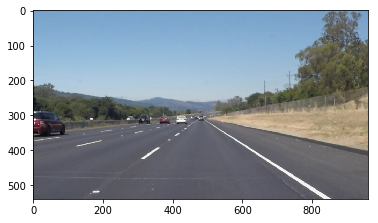

In [10]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [11]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def find_hi_low_point(intrcpt, slope):
    # Here we make a assumption that all intercepts are made on X-axis (hence y = 0)
    # y = mx +c
    # y = 0; x = -m/c
    # Using this point (x, 0) and intercept, find the other end of line in the form of x and y
    y = 0
    x = -slope/intrcpt
    
    return x,y

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_avg = 0
    right_avg = 0
    infinity = math.inf
    x = 0
    two_line = 0
    c_left = []
    c_right =[]
    
    for lin_num in range(0,len(lines)):
        print ("[%s] is the line now!" % lin_num)
        line = lines[lin_num]
        if two_line == 2:
            x = x + 1
            two_line = 0
        for x1,y1,x2,y2 in line:
            print ( line)
            slope = (y2 - y1)/(x2 - x1)
            if slope > 0:
                left_avg = ((x) * left_avg + slope)/(x + 1)
                print ("[%d] We have +ve slope here is %s (left line) avg: %s" % (x, slope, left_avg))
                c1 = y1 - left_avg*x1
                c2 = y2 - left_avg*x2
                c_left.append(c1)
                c_left.append(c1)
                c_left.sort(key=float)
                print ('[%d]' % x)
                print (c_left)
                a1, b1 = find_hi_low_point(c_left[0], left_avg)
                a2, b2 = find_hi_low_point(c_left[-1], left_avg)
                two_line = two_line + 1
            elif slope < 0:
                right_avg = -((-x) * right_avg + (-slope))/(x + 1)
                print ("[%d] We have -ve slope here is %s (right line) avg: %s" % (x, slope, right_avg))
                c1 = y1 - right_avg*x1
                c2 = y2 - right_avg*x2
                c_right.append(c1)
                c_right.append(c2)
                c_right.sort(key=float)
                print ('[%d]' % x)
                print (c_right)
                a1, b1 = find_hi_low_point(c_right[0], right_avg)
                a2, b2 = find_hi_low_point(c_right[-1], right_avg)
                two_line = two_line + 1
            
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Processing test_images/whiteCarLaneSwitch.jpg
[0] is the line now!
[[194 538 473 320]]
[0] We have -ve slope here is -0.781362007168 (right line) avg: -0.781362007168
[0]
[689.584229390681, 689.584229390681]
[1] is the line now!
[[497 319 863 539]]
[0] We have +ve slope here is 0.601092896175 (left line) avg: 0.601092896175
[0]
[20.256830601092872, 20.256830601092872]
[2] is the line now!
[[277 462 473 319]]
[1] We have -ve slope here is -0.729591836735 (right line) avg: -0.755476921952
[1]
[671.26710738058659, 676.34058408309556, 689.584229390681, 689.584229390681]
[3] is the line now!
[[505 322 793 488]]
[1] We have +ve slope here is 0.576388888889 (left line) avg: 0.588740892532
[1]
[20.256830601092872, 20.256830601092872, 24.68584927140256, 24.68584927140256]
[4] is the line now!
[[175 538 468 325]]
[2] We have -ve slope here is -0.726962457338 (right line) avg: -0.745972100414
[2]
[668.54511757239379, 671.26710738058659, 674.11494299360174, 676.34058408309556, 689.584229390681, 68

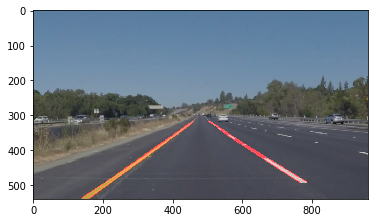

In [12]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
# This pipeline is highly based on snippet code shared in lectures

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

    
def process_individual_frame(image):
    each_gray = grayscale(image)
    plt.imshow(each_gray)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    each_blur_gray = gaussian_blur(each_gray,kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(each_blur_gray, low_threshold, high_threshold)

    # creating here a image mask
    a = (0, image.shape[0])
    b = (image.shape[1]/2 - (image.shape[0] * 0.08), image.shape[0]/2 + (image.shape[1] * 0.05))
    c = (image.shape[1]/2 + (image.shape[0] * 0.08), image.shape[0]/2 + (image.shape[1] * 0.05))
    d = (image.shape[1], image.shape[0])
    vertices = np.array([[a, b, c, d]], dtype=np.int32)
    
    masked_edges = region_of_interest(edges, vertices)
    
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 65 # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 4 #minimum number of pixels making up a line
    max_line_gap = 240  # maximum gap in pixels between connectable line segments
    
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    
    lines_edges = weighted_img(lines, image)
    plt.imshow(lines_edges)
    return lines_edges

import os
os.listdir("test_images/")
test_images = os.listdir("test_images/")

for each_inp in test_images:
    each_inp = "test_images/" + each_inp
    print ("Processing " + each_inp)
    image = mpimg.imread(each_inp)
    process_individual_frame(image)
    
    
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return process_individual_frame(image)

Let's try the one with the solid white lane on the right first ...

[0] is the line now!
[[513 324 869 538]]
[0] We have +ve slope here is 0.601123595506 (left line) avg: 0.601123595506
[0]
[15.623595505617971, 15.623595505617971]
[1] is the line now!
[[498 318 742 471]]
[0] We have +ve slope here is 0.627049180328 (left line) avg: 0.627049180328
[0]
[5.7295081967213264, 5.7295081967213264, 15.623595505617971, 15.623595505617971]
[2] is the line now!
[[200 515 462 318]]
[1] We have -ve slope here is -0.751908396947 (right line) avg: -0.375954198473
[1]
[491.69083969465646, 590.19083969465646]
[3] is the line now!
[[504 318 870 538]]
[1] We have +ve slope here is 0.601092896175 (left line) avg: 0.614071038251
[1]
[5.7295081967213264, 5.7295081967213264, 8.5081967213114922, 8.5081967213114922, 15.623595505617971, 15.623595505617971]
[4] is the line now!
[[187 512 464 318]]
[2] We have -ve slope here is -0.70036101083 (right line) avg: -0.484089802592
[2]
[491.69083969465646, 542.61766840282564, 590.19083969465646, 602.52479308475949]
[5] is the line now!

  1%|▏         | 3/222 [00:00<00:08, 25.57it/s]

[0] is the line now!
[[513 324 869 538]]
[0] We have +ve slope here is 0.601123595506 (left line) avg: 0.601123595506
[0]
[15.623595505617971, 15.623595505617971]
[1] is the line now!
[[498 318 742 471]]
[0] We have +ve slope here is 0.627049180328 (left line) avg: 0.627049180328
[0]
[5.7295081967213264, 5.7295081967213264, 15.623595505617971, 15.623595505617971]
[2] is the line now!
[[200 515 462 318]]
[1] We have -ve slope here is -0.751908396947 (right line) avg: -0.375954198473
[1]
[491.69083969465646, 590.19083969465646]
[3] is the line now!
[[504 318 870 538]]
[1] We have +ve slope here is 0.601092896175 (left line) avg: 0.614071038251
[1]
[5.7295081967213264, 5.7295081967213264, 8.5081967213114922, 8.5081967213114922, 15.623595505617971, 15.623595505617971]
[4] is the line now!
[[187 512 464 318]]
[2] We have -ve slope here is -0.70036101083 (right line) avg: -0.484089802592
[2]
[491.69083969465646, 542.61766840282564, 590.19083969465646, 602.52479308475949]
[5] is the line now!

  4%|▍         | 9/222 [00:00<00:08, 25.46it/s]

[0] is the line now!
[[505 322 779 494]]
[0] We have +ve slope here is 0.627737226277 (left line) avg: 0.627737226277
[0]
[4.9927007299269803, 4.9927007299269803]
[1] is the line now!
[[501 318 870 539]]
[0] We have +ve slope here is 0.59891598916 (left line) avg: 0.59891598916
[0]
[4.9927007299269803, 4.9927007299269803, 17.943089430894304, 17.943089430894304]
[2] is the line now!
[[505 318 867 536]]
[1] We have +ve slope here is 0.602209944751 (left line) avg: 0.600562966956
[1]
[4.9927007299269803, 4.9927007299269803, 14.715701687403566, 14.715701687403566, 17.943089430894304, 17.943089430894304]
[3] is the line now!
[[509 321 870 538]]
[1] We have +ve slope here is 0.601108033241 (left line) avg: 0.600835500098
[1]
[4.9927007299269803, 4.9927007299269803, 14.715701687403566, 14.715701687403566, 15.174730449956712, 15.174730449956712, 17.943089430894304, 17.943089430894304]
[4] is the line now!
[[775 493 847 537]]
[2] We have +ve slope here is 0.611111111111 (left line) avg: 0.60426

  7%|▋         | 15/222 [00:00<00:08, 24.85it/s]

[0] is the line now!
[[488 318 856 539]]
[0] We have +ve slope here is 0.600543478261 (left line) avg: 0.600543478261
[0]
[24.934782608695684, 24.934782608695684]
[1] is the line now!
[[493 318 829 536]]
[0] We have +ve slope here is 0.64880952381 (left line) avg: 0.64880952381
[0]
[-1.8630952380952408, -1.8630952380952408, 24.934782608695684, 24.934782608695684]
[2] is the line now!
[[230 482 464 318]]
[1] We have -ve slope here is -0.700854700855 (right line) avg: -0.350427350427
[1]
[480.59829059829059, 562.59829059829053]
[3] is the line now!
[[239 485 470 318]]
[1] We have -ve slope here is -0.722943722944 (right line) avg: -0.536685536686
[1]
[480.59829059829059, 562.59829059829053, 570.24220224220221, 613.26784326784332]
[4] is the line now!
[[498 318 731 463]]
[2] We have +ve slope here is 0.622317596567 (left line) avg: 0.639978881395
[2]
[-1.8630952380952408, -1.8630952380952408, -0.70948293480483926, -0.70948293480483926, 24.934782608695684, 24.934782608695684]
[5] is the li

  8%|▊         | 18/222 [00:00<00:09, 21.23it/s]

[0] is the line now!
[[555 351 738 474]]
[0] We have +ve slope here is 0.672131147541 (left line) avg: 0.672131147541
[0]
[-22.032786885245912, -22.032786885245912]
[1] is the line now!
[[521 327 859 539]]
[0] We have +ve slope here is 0.627218934911 (left line) avg: 0.627218934911
[0]
[-22.032786885245912, -22.032786885245912, 0.21893491124262709, 0.21893491124262709]
[2] is the line now!
[[508 318 860 538]]
[1] We have +ve slope here is 0.625 (left line) avg: 0.626109467456
[1]
[-22.032786885245912, -22.032786885245912, -0.063609467455648883, -0.063609467455648883, 0.21893491124262709, 0.21893491124262709]
[3] is the line now!
[[724 464 837 538]]
[1] We have +ve slope here is 0.654867256637 (left line) avg: 0.640488362046
[1]
[-22.032786885245912, -22.032786885245912, -0.063609467455648883, -0.063609467455648883, 0.21893491124262709, 0.21893491124262709, 0.28642587841017075, 0.28642587841017075]
[4] is the line now!
[[502 318 543 345]]
[2] We have +ve slope here is 0.658536585366 (le

 11%|█         | 24/222 [00:01<00:08, 23.21it/s]

[1]
[-4.7439774741891938, -4.7439774741891938, -3.7674418604651692, -3.7674418604651692, 5.7620396600566437, 5.7620396600566437]
[3] is the line now!
[[189 520 468 318]]
[1] We have -ve slope here is -0.724014336918 (right line) avg: -0.362007168459
[1]
[487.41935483870964, 588.41935483870964]
[4] is the line now!
[[162 523 466 318]]
[2] We have -ve slope here is -0.674342105263 (right line) avg: -0.46611881406
[2]
[487.41935483870964, 535.21136735207187, 588.41935483870964, 598.51124787775893]
[5] is the line now!
[[319 425 461 318]]
[2] We have -ve slope here is -0.753521126761 (right line) avg: -0.56191958496
[2]
[487.41935483870964, 535.21136735207187, 577.04492866672035, 588.41935483870964, 598.51124787775893, 604.25234760235094]
[6] is the line now!
[[498 320 793 512]]
[3] We have +ve slope here is 0.650847457627 (left line) avg: 0.650731991636
[3]
[-4.7439774741891938, -4.7439774741891938, -4.0645318346764157, -4.0645318346764157, -3.7674418604651692, -3.7674418604651692, 5.7620

 14%|█▎        | 30/222 [00:01<00:07, 25.07it/s]

[0] is the line now!
[[520 333 799 515]]
[0] We have +ve slope here is 0.652329749104 (left line) avg: 0.652329749104
[0]
[-6.2114695340501953, -6.2114695340501953]
[1] is the line now!
[[503 318 855 538]]
[0] We have +ve slope here is 0.625 (left line) avg: 0.625
[0]
[-6.2114695340501953, -6.2114695340501953, 3.625, 3.625]
[2] is the line now!
[[164 539 347 406]]
[1] We have -ve slope here is -0.726775956284 (right line) avg: -0.363387978142
[1]
[532.09562841530055, 598.59562841530055]
[3] is the line now!
[[149 535 460 318]]
[1] We have -ve slope here is -0.697749196141 (right line) avg: -0.530568587142
[1]
[532.09562841530055, 562.06155008521773, 598.59562841530055, 614.05471948412492]
[4] is the line now!
[[703 453 833 538]]
[2] We have +ve slope here is 0.653846153846 (left line) avg: 0.634615384615
[2]
[-6.2114695340501953, -6.2114695340501953, 3.625, 3.625, 6.8653846153846416, 6.8653846153846416]
[5] is the line now!
[[504 318 525 331]]
[2] We have +ve slope here is 0.6190476190

 16%|█▌        | 36/222 [00:01<00:07, 25.67it/s]

[0] is the line now!
[[505 318 858 539]]
[0] We have +ve slope here is 0.626062322946 (left line) avg: 0.626062322946
[0]
[1.8385269121813508, 1.8385269121813508]
[1] is the line now!
[[558 357 836 538]]
[0] We have +ve slope here is 0.651079136691 (left line) avg: 0.651079136691
[0]
[-6.3021582733812807, -6.3021582733812807, 1.8385269121813508, 1.8385269121813508]
[2] is the line now!
[[500 318 704 451]]
[1] We have +ve slope here is 0.651960784314 (left line) avg: 0.651519960502
[1]
[-7.759980251093225, -7.759980251093225, -6.3021582733812807, -6.3021582733812807, 1.8385269121813508, 1.8385269121813508]
[3] is the line now!
[[539 340 832 523]]
[1] We have +ve slope here is 0.62457337884 (left line) avg: 0.638046669671
[1]
[-7.759980251093225, -7.759980251093225, -6.3021582733812807, -6.3021582733812807, -3.9071549526088347, -3.9071549526088347, 1.8385269121813508, 1.8385269121813508]
[4] is the line now!
[[169 521 457 319]]
[2] We have -ve slope here is -0.701388888889 (right line) a

 19%|█▉        | 42/222 [00:01<00:06, 26.08it/s]

[0] is the line now!
[[500 318 854 539]]
[0] We have +ve slope here is 0.624293785311 (left line) avg: 0.624293785311
[0]
[5.8531073446328037, 5.8531073446328037]
[1] is the line now!
[[501 319 683 441]]
[0] We have +ve slope here is 0.67032967033 (left line) avg: 0.67032967033
[0]
[-16.83516483516479, -16.83516483516479, 5.8531073446328037, 5.8531073446328037]
[2] is the line now!
[[504 318 802 519]]
[1] We have +ve slope here is 0.674496644295 (left line) avg: 0.672413157312
[1]
[-20.896231285493002, -20.896231285493002, -16.83516483516479, -16.83516483516479, 5.8531073446328037, 5.8531073446328037]
[3] is the line now!
[[166 539 460 318]]
[1] We have -ve slope here is -0.751700680272 (right line) avg: -0.375850340136
[1]
[490.89115646258506, 601.39115646258506]
[4] is the line now!
[[145 538 456 320]]
[2] We have -ve slope here is -0.700964630225 (right line) avg: -0.484221770166
[2]
[490.89115646258506, 540.80512719557271, 601.39115646258506, 608.21215667403078]
[5] is the line now

 22%|██▏       | 48/222 [00:01<00:06, 26.62it/s]

[0] is the line now!
[[501 318 854 538]]
[0] We have +ve slope here is 0.623229461756 (left line) avg: 0.623229461756
[0]
[5.7620396600566437, 5.7620396600566437]
[1] is the line now!
[[502 318 792 513]]
[0] We have +ve slope here is 0.672413793103 (left line) avg: 0.672413793103
[0]
[-19.551724137931046, -19.551724137931046, 5.7620396600566437, 5.7620396600566437]
[2] is the line now!
[[513 323 619 390]]
[1] We have +ve slope here is 0.632075471698 (left line) avg: 0.652244632401
[1]
[-19.551724137931046, -19.551724137931046, -11.601496421600473, -11.601496421600473, 5.7620396600566437, 5.7620396600566437]
[3] is the line now!
[[173 517 455 320]]
[1] We have -ve slope here is -0.698581560284 (right line) avg: -0.349290780142
[1]
[478.92730496453896, 577.42730496453896]
[4] is the line now!
[[198 514 452 323]]
[2] We have -ve slope here is -0.751968503937 (right line) avg: -0.483516688074
[2]
[478.92730496453896, 541.54954300925147, 577.42730496453896, 609.73630423856594]
[5] is the li

 24%|██▍       | 54/222 [00:02<00:06, 24.82it/s]

[4] is the line now!
[[509 325 679 428]]
[2] We have +ve slope here is 0.605882352941 (left line) avg: 0.651191553544
[2]
[-21.966153846153873, -21.966153846153873, -6.4565007541477826, -6.4565007541477826, 4.875, 4.875]
[5] is the line now!
[[549 345 767 497]]
[2] We have +ve slope here is 0.697247706422 (left line) avg: 0.666543604504
[2]
[-21.966153846153873, -21.966153846153873, -20.93243887251441, -20.93243887251441, -6.4565007541477826, -6.4565007541477826, 4.875, 4.875]
[6] is the line now!
[[506 318 642 413]]
[3] We have +ve slope here is 0.698529411765 (left line) avg: 0.674540056319
[3]
[-23.317268497377711, -23.317268497377711, -21.966153846153873, -21.966153846153873, -20.93243887251441, -20.93243887251441, -6.4565007541477826, -6.4565007541477826, 4.875, 4.875]
[7] is the line now!
[[580 365 713 461]]
[3] We have +ve slope here is 0.721804511278 (left line) avg: 0.686356170059
[3]
[-33.086578634072112, -33.086578634072112, -23.317268497377711, -23.317268497377711, -21.9661

 26%|██▌       | 57/222 [00:02<00:07, 22.66it/s]


[0]
[2.0232558139534831, 2.0232558139534831]
[1] is the line now!
[[540 344 808 524]]
[0] We have +ve slope here is 0.671641791045 (left line) avg: 0.671641791045
[0]
[-18.68656716417911, -18.68656716417911, 2.0232558139534831, 2.0232558139534831]
[2] is the line now!
[[268 455 457 318]]
[1] We have -ve slope here is -0.724867724868 (right line) avg: -0.362433862434
[1]
[483.63227513227514, 552.13227513227514]
[3] is the line now!
[[665 419 808 511]]
[1] We have +ve slope here is 0.643356643357 (left line) avg: 0.657499217201
[1]
[-18.68656716417911, -18.68656716417911, -18.236979438471963, -18.236979438471963, 2.0232558139534831, 2.0232558139534831]
[4] is the line now!
[[503 321 694 446]]
[2] We have +ve slope here is 0.65445026178 (left line) avg: 0.656482898727
[2]
[-18.68656716417911, -18.68656716417911, -18.236979438471963, -18.236979438471963, -9.2108980597688515, -9.2108980597688515, 2.0232558139534831, 2.0232558139534831]
[5] is the line now!
[[253 457 393 359]]
[2] We have -

 28%|██▊       | 63/222 [00:02<00:06, 23.92it/s]


[[260 452 459 318]]
[1] We have -ve slope here is -0.673366834171 (right line) avg: -0.336683417085
[1]
[472.53768844221105, 539.53768844221111]
[4] is the line now!
[[506 326 668 424]]
[2] We have +ve slope here is 0.604938271605 (left line) avg: 0.64969421619
[2]
[-18.39143730886849, -18.39143730886849, -15.902765215144086, -15.902765215144086, -2.7452733921557524, -2.7452733921557524, 8.2820512820512704, 8.2820512820512704]
[5] is the line now!
[[268 455 463 319]]
[2] We have -ve slope here is -0.697435897436 (right line) avg: -0.456934243869
[2]
[472.53768844221105, 530.56055491130871, 539.53768844221111, 577.45837735686985]
[6] is the line now!
[[545 346 700 454]]
[3] We have +ve slope here is 0.696774193548 (left line) avg: 0.66146421053
[3]
[-18.39143730886849, -18.39143730886849, -15.902765215144086, -15.902765215144086, -14.497994738642944, -14.497994738642944, -2.7452733921557524, -2.7452733921557524, 8.2820512820512704, 8.2820512820512704]
[7] is the line now!
[[495 318 849

 30%|██▉       | 66/222 [00:02<00:06, 23.92it/s]

[0] is the line now!
[[507 327 837 534]]
[0] We have +ve slope here is 0.627272727273 (left line) avg: 0.627272727273
[0]
[8.9727272727272407, 8.9727272727272407]
[1] is the line now!
[[567 366 816 534]]
[0] We have +ve slope here is 0.674698795181 (left line) avg: 0.674698795181
[0]
[-16.554216867469847, -16.554216867469847, 8.9727272727272407, 8.9727272727272407]
[2] is the line now!
[[501 318 842 539]]
[1] We have +ve slope here is 0.648093841642 (left line) avg: 0.661396318411
[1]
[-16.554216867469847, -16.554216867469847, -13.359555524149357, -13.359555524149357, 8.9727272727272407, 8.9727272727272407]
[3] is the line now!
[[494 318 821 539]]
[1] We have +ve slope here is 0.675840978593 (left line) avg: 0.668618648502
[1]
[-16.554216867469847, -16.554216867469847, -13.359555524149357, -13.359555524149357, -12.297612360172707, -12.297612360172707, 8.9727272727272407, 8.9727272727272407]
[4] is the line now!
[[497 319 713 454]]
[2] We have +ve slope here is 0.625 (left line) avg: 0.

 32%|███▏      | 72/222 [00:02<00:06, 24.33it/s]

[0] is the line now!
[[502 318 809 517]]
[0] We have +ve slope here is 0.648208469055 (left line) avg: 0.648208469055
[0]
[-7.4006514657980347, -7.4006514657980347]
[1] is the line now!
[[496 318 823 538]]
[0] We have +ve slope here is 0.672782874618 (left line) avg: 0.672782874618
[0]
[-15.700305810397538, -15.700305810397538, -7.4006514657980347, -7.4006514657980347]
[2] is the line now!
[[286 433 457 318]]
[1] We have -ve slope here is -0.672514619883 (right line) avg: -0.336257309942
[1]
[471.66959064327489, 529.16959064327489]
[3] is the line now!
[[294 433 454 321]]
[1] We have -ve slope here is -0.7 (right line) avg: -0.518128654971
[1]
[471.66959064327489, 529.16959064327489, 556.2304093567252, 585.32982456140348]
[4] is the line now!
[[511 329 822 539]]
[2] We have +ve slope here is 0.675241157556 (left line) avg: 0.673602302264
[2]
[-15.700305810397538, -15.700305810397538, -15.210776456860401, -15.210776456860401, -7.4006514657980347, -7.4006514657980347]
[5] is the line now

 35%|███▌      | 78/222 [00:03<00:05, 24.77it/s]

[2] We have +ve slope here is 0.64880952381 (left line) avg: 0.649603174603
[2]
[-15.023255813953483, -15.023255813953483, -7.6500000000000341, -7.6500000000000341, -6.0928571428571558, -6.0928571428571558]
[6] is the line now!
[[495 318 741 484]]
[3] We have +ve slope here is 0.674796747967 (left line) avg: 0.655901567944
[3]
[-15.023255813953483, -15.023255813953483, -7.6500000000000341, -7.6500000000000341, -6.6712761324042162, -6.6712761324042162, -6.0928571428571558, -6.0928571428571558]
[0] is the line now!
[[515 327 841 539]]
[0] We have +ve slope here is 0.650306748466 (left line) avg: 0.650306748466
[0]
[-7.9079754601227137, -7.9079754601227137]
[1] is the line now!
[[516 332 798 523]]
[0] We have +ve slope here is 0.677304964539 (left line) avg: 0.677304964539
[0]
[-17.489361702127667, -17.489361702127667, -7.9079754601227137, -7.9079754601227137]
[2] is the line now!
[[140 538 455 318]]
[1] We have -ve slope here is -0.698412698413 (right line) avg: -0.349206349206
[1]
[476.

 38%|███▊      | 84/222 [00:03<00:05, 24.14it/s]

[0] is the line now!
[[499 320 834 538]]
[0] We have +ve slope here is 0.650746268657 (left line) avg: 0.650746268657
[0]
[-4.7223880597014727, -4.7223880597014727]
[1] is the line now!
[[496 318 745 492]]
[0] We have +ve slope here is 0.698795180723 (left line) avg: 0.698795180723
[0]
[-28.602409638554207, -28.602409638554207, -4.7223880597014727, -4.7223880597014727]
[2] is the line now!
[[602 385 813 538]]
[1] We have +ve slope here is 0.725118483412 (left line) avg: 0.711956832068
[1]
[-43.598012904699374, -43.598012904699374, -28.602409638554207, -28.602409638554207, -4.7223880597014727, -4.7223880597014727]
[3] is the line now!
[[302 417 461 318]]
[1] We have -ve slope here is -0.622641509434 (right line) avg: -0.311320754717
[1]
[461.51886792452831, 511.01886792452831]
[4] is the line now!
[[502 318 583 374]]
[2] We have +ve slope here is 0.691358024691 (left line) avg: 0.705090562942
[2]
[-43.598012904699374, -43.598012904699374, -35.955462596979658, -35.955462596979658, -28.60

 39%|███▉      | 87/222 [00:03<00:05, 23.06it/s]

[0] is the line now!
[[497 318 811 538]]
[0] We have +ve slope here is 0.700636942675 (left line) avg: 0.700636942675
[0]
[-30.216560509554142, -30.216560509554142]
[1] is the line now!
[[137 537 462 318]]
[0] We have -ve slope here is -0.673846153846 (right line) avg: -0.673846153846
[0]
[629.3169230769231, 629.3169230769231]
[2] is the line now!
[[503 318 803 520]]
[1] We have +ve slope here is 0.673333333333 (left line) avg: 0.686985138004
[1]
[-30.216560509554142, -30.216560509554142, -27.553524416135815, -27.553524416135815]
[3] is the line now!
[[521 331 705 455]]
[1] We have +ve slope here is 0.673913043478 (left line) avg: 0.680449090741
[1]
[-30.216560509554142, -30.216560509554142, -27.553524416135815, -27.553524416135815, -23.513976276193091, -23.513976276193091]
[4] is the line now!
[[122 536 457 318]]
[2] We have -ve slope here is -0.650746268657 (right line) avg: -0.666146192116
[2]
[617.2698354381937, 622.42880979716801, 629.3169230769231, 629.3169230769231]
[5] is the l

 42%|████▏     | 93/222 [00:03<00:05, 21.89it/s]

[0] is the line now!
[[543 347 749 486]]
[0] We have +ve slope here is 0.674757281553 (left line) avg: 0.674757281553
[0]
[-19.393203883495175, -19.393203883495175]
[1] is the line now!
[[573 373 808 538]]
[0] We have +ve slope here is 0.702127659574 (left line) avg: 0.702127659574
[0]
[-29.319148936170222, -29.319148936170222, -19.393203883495175, -19.393203883495175]
[2] is the line now!
[[503 318 829 538]]
[1] We have +ve slope here is 0.674846625767 (left line) avg: 0.688487142671
[1]
[-29.319148936170222, -29.319148936170222, -28.309032763346806, -28.309032763346806, -19.393203883495175, -19.393203883495175]
[3] is the line now!
[[498 318 609 398]]
[1] We have +ve slope here is 0.720720720721 (left line) avg: 0.704603931696
[1]
[-32.892757984456182, -32.892757984456182, -29.319148936170222, -29.319148936170222, -28.309032763346806, -28.309032763346806, -19.393203883495175, -19.393203883495175]
[4] is the line now!
[[334 401 466 318]]
[2] We have -ve slope here is -0.628787878788 (

 45%|████▍     | 99/222 [00:04<00:05, 23.19it/s]

[0] is the line now!
[[506 320 831 539]]
[0] We have +ve slope here is 0.673846153846 (left line) avg: 0.673846153846
[0]
[-20.966153846153873, -20.966153846153873]
[1] is the line now!
[[503 318 714 471]]
[0] We have +ve slope here is 0.725118483412 (left line) avg: 0.725118483412
[0]
[-46.734597156398138, -46.734597156398138, -20.966153846153873, -20.966153846153873]
[2] is the line now!
[[507 318 811 539]]
[1] We have +ve slope here is 0.726973684211 (left line) avg: 0.726046083811
[1]
[-50.105364492392141, -50.105364492392141, -46.734597156398138, -46.734597156398138, -20.966153846153873, -20.966153846153873]
[3] is the line now!
[[231 465 462 320]]
[1] We have -ve slope here is -0.627705627706 (right line) avg: -0.313852813853
[1]
[465.0, 537.5]
[4] is the line now!
[[243 468 458 318]]
[2] We have -ve slope here is -0.697674418605 (right line) avg: -0.44179334877
[2]
[465.0, 520.34135373670256, 537.5, 575.35578375113255]
[5] is the line now!
[[534 335 730 482]]
[2] We have +ve slo

 47%|████▋     | 105/222 [00:04<00:04, 24.65it/s]

[0] is the line now!
[[505 318 832 538]]
[0] We have +ve slope here is 0.672782874618 (left line) avg: 0.672782874618
[0]
[-21.755351681957166, -21.755351681957166]
[1] is the line now!
[[509 321 736 485]]
[0] We have +ve slope here is 0.722466960352 (left line) avg: 0.722466960352
[0]
[-46.735682819383214, -46.735682819383214, -21.755351681957166, -21.755351681957166]
[2] is the line now!
[[551 345 767 507]]
[1] We have +ve slope here is 0.75 (left line) avg: 0.736233480176
[1]
[-60.664647577092467, -60.664647577092467, -46.735682819383214, -46.735682819383214, -21.755351681957166, -21.755351681957166]
[3] is the line now!
[[603 382 812 539]]
[1] We have +ve slope here is 0.751196172249 (left line) avg: 0.743714826213
[1]
[-66.460040206142082, -66.460040206142082, -60.664647577092467, -60.664647577092467, -46.735682819383214, -46.735682819383214, -21.755351681957166, -21.755351681957166]
[4] is the line now!
[[137 537 456 322]]
[2] We have -ve slope here is -0.673981191223 (right line

 50%|█████     | 111/222 [00:04<00:04, 24.97it/s]

[0] is the line now!
[[501 318 814 522]]
[0] We have +ve slope here is 0.651757188498 (left line) avg: 0.651757188498
[0]
[-8.5303514376997214, -8.5303514376997214]
[1] is the line now!
[[507 320 641 414]]
[0] We have +ve slope here is 0.701492537313 (left line) avg: 0.701492537313
[0]
[-35.656716417910445, -35.656716417910445, -8.5303514376997214, -8.5303514376997214]
[2] is the line now!
[[540 338 817 539]]
[1] We have +ve slope here is 0.725631768953 (left line) avg: 0.713562153133
[1]
[-47.323562691955431, -47.323562691955431, -35.656716417910445, -35.656716417910445, -8.5303514376997214, -8.5303514376997214]
[3] is the line now!
[[268 446 464 319]]
[1] We have -ve slope here is -0.647959183673 (right line) avg: -0.323979591837
[1]
[469.32653061224494, 532.82653061224494]
[4] is the line now!
[[573 360 737 483]]
[2] We have +ve slope here is 0.75 (left line) avg: 0.725708102089
[2]
[-55.830742496901792, -55.830742496901792, -47.323562691955431, -47.323562691955431, -35.656716417910

 51%|█████▏    | 114/222 [00:04<00:04, 24.67it/s]

[0] We have +ve slope here is 0.699300699301 (left line) avg: 0.699300699301
[0]
[-34.027972027971998, -34.027972027971998]
[1] is the line now!
[[597 376 838 538]]
[0] We have +ve slope here is 0.672199170124 (left line) avg: 0.672199170124
[0]
[-34.027972027971998, -34.027972027971998, -25.302904564315384, -25.302904564315384]
[2] is the line now!
[[505 318 539 340]]
[1] We have +ve slope here is 0.647058823529 (left line) avg: 0.659628996827
[1]
[-34.027972027971998, -34.027972027971998, -25.302904564315384, -25.302904564315384, -15.112643397608053, -15.112643397608053]
[3] is the line now!
[[153 538 468 318]]
[1] We have -ve slope here is -0.698412698413 (right line) avg: -0.349206349206
[1]
[481.42857142857144, 591.42857142857144]
[4] is the line now!
[[509 319 680 434]]
[2] We have +ve slope here is 0.672514619883 (left line) avg: 0.663924204512
[2]
[-34.027972027971998, -34.027972027971998, -25.302904564315384, -25.302904564315384, -18.937420096766516, -18.937420096766516, -15.1

 54%|█████▍    | 120/222 [00:04<00:04, 24.94it/s]

[0] is the line now!
[[506 318 846 539]]
[0] We have +ve slope here is 0.65 (left line) avg: 0.65
[0]
[-10.900000000000034, -10.900000000000034]
[1] is the line now!
[[512 320 825 539]]
[0] We have +ve slope here is 0.699680511182 (left line) avg: 0.699680511182
[0]
[-38.236421725239609, -38.236421725239609, -10.900000000000034, -10.900000000000034]
[2] is the line now!
[[501 318 715 452]]
[1] We have +ve slope here is 0.626168224299 (left line) avg: 0.662924367741
[1]
[-38.236421725239609, -38.236421725239609, -14.125108238034045, -14.125108238034045, -10.900000000000034, -10.900000000000034]
[3] is the line now!
[[543 345 567 361]]
[1] We have +ve slope here is 0.666666666667 (left line) avg: 0.664795517204
[1]
[-38.236421725239609, -38.236421725239609, -15.983965841569386, -15.983965841569386, -14.125108238034045, -14.125108238034045, -10.900000000000034, -10.900000000000034]
[4] is the line now!
[[197 503 462 318]]
[2] We have -ve slope here is -0.698113207547 (right line) avg: -0.

 57%|█████▋    | 126/222 [00:05<00:03, 25.88it/s]


[5] We have -ve slope here is -0.7 (right line) avg: -0.55640122966
[5]
[484.18556701030923, 551.28918278714104, 565.98699444885006, 566.95493057690601, 576.17017056211603, 586.18556701030923, 593.50431363567395, 594.27565424266459, 605.20758428993531, 619.24980166419618]
[11] is the line now!
[[580 366 746 473]]
[5] We have +ve slope here is 0.644578313253 (left line) avg: 0.677207328913
[5]
[-30.667615378440644, -30.667615378440644, -26.78025076959949, -26.78025076959949, -25.869928505987218, -25.869928505987218, -21.927080707818732, -21.927080707818732, -16.584928646014589, -16.584928646014589, -16.443037974683534, -16.443037974683534, 6.3786982248520872, 6.3786982248520872]
[12] is the line now!
[[518 326 690 446]]
[6] We have +ve slope here is 0.697674418605 (left line) avg: 0.680131198869
[6]
[-30.667615378440644, -30.667615378440644, -26.78025076959949, -26.78025076959949, -26.30796101416172, -26.30796101416172, -25.869928505987218, -25.869928505987218, -21.927080707818732, -21

 59%|█████▉    | 132/222 [00:05<00:03, 25.54it/s]


[1]
[-8.1226415094339472, -8.1226415094339472, -6.8068270626325784, -6.8068270626325784, 1.8385269121813508, 1.8385269121813508]
[3] is the line now!
[[248 473 469 318]]
[1] We have -ve slope here is -0.701357466063 (right line) avg: -0.350678733032
[1]
[482.46832579185519, 559.96832579185525]
[4] is the line now!
[[234 474 463 319]]
[2] We have -ve slope here is -0.676855895197 (right line) avg: -0.459404453753
[2]
[482.46832579185519, 531.70426208777099, 559.96832579185525, 581.50064217826866]
[5] is the line now!
[[500 318 818 525]]
[2] We have +ve slope here is 0.650943396226 (left line) avg: 0.650924788806
[2]
[-8.1226415094339472, -8.1226415094339472, -7.4623944028878668, -7.4623944028878668, -6.8068270626325784, -6.8068270626325784, 1.8385269121813508, 1.8385269121813508]
[6] is the line now!
[[506 318 858 538]]
[3] We have +ve slope here is 0.625 (left line) avg: 0.644443591604
[3]
[-8.1226415094339472, -8.1226415094339472, -8.0884573517919307, -8.0884573517919307, -7.46239440

 62%|██████▏   | 138/222 [00:05<00:03, 25.67it/s]

[0] is the line now!
[[506 318 860 539]]
[0] We have +ve slope here is 0.624293785311 (left line) avg: 0.624293785311
[0]
[2.1073446327683882, 2.1073446327683882]
[1] is the line now!
[[500 318 839 538]]
[0] We have +ve slope here is 0.648967551622 (left line) avg: 0.648967551622
[0]
[-6.4837758112094548, -6.4837758112094548, 2.1073446327683882, 2.1073446327683882]
[2] is the line now!
[[178 528 468 318]]
[1] We have -ve slope here is -0.724137931034 (right line) avg: -0.362068965517
[1]
[487.44827586206895, 592.44827586206895]
[3] is the line now!
[[164 527 463 318]]
[1] We have -ve slope here is -0.698996655518 (right line) avg: -0.530532810518
[1]
[487.44827586206895, 563.63669126974969, 592.44827586206895, 614.00738092492213]
[4] is the line now!
[[499 318 838 539]]
[2] We have +ve slope here is 0.65191740413 (left line) avg: 0.649950835792
[2]
[-6.4837758112094548, -6.4837758112094548, -6.3254670599803262, -6.3254670599803262, 2.1073446327683882, 2.1073446327683882]
[5] is the lin

 65%|██████▍   | 144/222 [00:05<00:03, 25.98it/s]

[0] is the line now!
[[501 318 840 538]]
[0] We have +ve slope here is 0.648967551622 (left line) avg: 0.648967551622
[0]
[-7.1327433628318886, -7.1327433628318886]
[1] is the line now!
[[507 319 778 488]]
[0] We have +ve slope here is 0.623616236162 (left line) avg: 0.623616236162
[0]
[-7.1327433628318886, -7.1327433628318886, 2.8265682656826812, 2.8265682656826812]
[2] is the line now!
[[509 319 861 539]]
[1] We have +ve slope here is 0.625 (left line) avg: 0.624308118081
[1]
[-7.1327433628318886, -7.1327433628318886, 1.2271678966789636, 1.2271678966789636, 2.8265682656826812, 2.8265682656826812]
[3] is the line now!
[[256 471 467 318]]
[1] We have -ve slope here is -0.725118483412 (right line) avg: -0.362559241706
[1]
[487.31516587677726, 563.8151658767772]
[4] is the line now!
[[245 470 462 318]]
[2] We have -ve slope here is -0.700460829493 (right line) avg: -0.475193104302
[2]
[487.31516587677726, 537.53921418743312, 563.8151658767772, 586.42231055394177]
[5] is the line now!
[[5

 68%|██████▊   | 150/222 [00:06<00:02, 25.20it/s]


[3]
[-15.959728165114541, -15.959728165114541, -12.610886060782491, -12.610886060782491, -7.3138686131386521, -7.3138686131386521, 3.6458923512747674, 3.6458923512747674]
[8] is the line now!
[[240 488 465 318]]
[4] We have -ve slope here is -0.755555555556 (right line) avg: -0.651860512673
[4]
[493.01754385964909, 572.04052782170015, 579.01754385964909, 600.99284454140729, 609.43465290587471, 609.59754536555988, 621.11513839292832, 627.58389568536654, 630.59517117343808, 644.44652304151134]
[9] is the line now!
[[502 320 838 538]]
[4] We have +ve slope here is 0.64880952381 (left line) avg: 0.649338294595
[4]
[-15.959728165114541, -15.959728165114541, -12.610886060782491, -12.610886060782491, -7.3138686131386521, -7.3138686131386521, -5.9678238864656805, -5.9678238864656805, 3.6458923512747674, 3.6458923512747674]
[0] is the line now!
[[507 318 788 493]]
[0] We have +ve slope here is 0.622775800712 (left line) avg: 0.622775800712
[0]
[2.2526690391459283, 2.2526690391459283]
[1] is th

 69%|██████▉   | 153/222 [00:06<00:02, 24.47it/s]

[0] is the line now!
[[614 383 872 538]]
[0] We have +ve slope here is 0.600775193798 (left line) avg: 0.600775193798
[0]
[14.124031007751967, 14.124031007751967]
[1] is the line now!
[[508 318 812 515]]
[0] We have +ve slope here is 0.648026315789 (left line) avg: 0.648026315789
[0]
[-11.197368421052602, -11.197368421052602, 14.124031007751967, 14.124031007751967]
[2] is the line now!
[[502 318 871 539]]
[1] We have +ve slope here is 0.59891598916 (left line) avg: 0.623471152475
[1]
[-11.197368421052602, -11.197368421052602, 5.017481457709323, 5.017481457709323, 14.124031007751967, 14.124031007751967]
[3] is the line now!
[[516 322 850 539]]
[1] We have +ve slope here is 0.649700598802 (left line) avg: 0.636585875639
[1]
[-11.197368421052602, -11.197368421052602, -6.478311829486131, -6.478311829486131, 5.017481457709323, 5.017481457709323, 14.124031007751967, 14.124031007751967]
[4] is the line now!
[[503 319 652 412]]
[2] We have +ve slope here is 0.624161073826 (left line) avg: 0.63

 72%|███████▏  | 159/222 [00:06<00:02, 24.38it/s]

[0] is the line now!
[[509 318 849 539]]
[0] We have +ve slope here is 0.65 (left line) avg: 0.65
[0]
[-12.850000000000023, -12.850000000000023]
[1] is the line now!
[[573 355 805 499]]
[0] We have +ve slope here is 0.620689655172 (left line) avg: 0.620689655172
[0]
[-12.850000000000023, -12.850000000000023, -0.65517241379313873, -0.65517241379313873]
[2] is the line now!
[[510 318 849 538]]
[1] We have +ve slope here is 0.648967551622 (left line) avg: 0.634828603397
[1]
[-12.850000000000023, -12.850000000000023, -5.7625877326823911, -5.7625877326823911, -0.65517241379313873, -0.65517241379313873]
[3] is the line now!
[[292 450 462 318]]
[1] We have -ve slope here is -0.776470588235 (right line) avg: -0.388235294118
[1]
[497.36470588235295, 563.36470588235295]
[4] is the line now!
[[262 461 466 318]]
[2] We have -ve slope here is -0.700980392157 (right line) avg: -0.492483660131
[2]
[497.36470588235295, 547.49738562091511, 563.36470588235295, 590.03071895424841]
[5] is the line now!
[[

 74%|███████▍  | 165/222 [00:06<00:02, 25.83it/s]


[0]
[11.656934306569326, 11.656934306569326]
[1] is the line now!
[[508 318 860 538]]
[0] We have +ve slope here is 0.625 (left line) avg: 0.625
[0]
[0.5, 0.5, 11.656934306569326, 11.656934306569326]
[2] is the line now!
[[507 318 860 539]]
[1] We have +ve slope here is 0.626062322946 (left line) avg: 0.625531161473
[1]
[0.5, 0.5, 0.85570113314446417, 0.85570113314446417, 11.656934306569326, 11.656934306569326]
[3] is the line now!
[[511 319 593 368]]
[1] We have +ve slope here is 0.59756097561 (left line) avg: 0.611546068541
[1]
[0.5, 0.5, 0.85570113314446417, 0.85570113314446417, 6.4999589753333566, 6.4999589753333566, 11.656934306569326, 11.656934306569326]
[4] is the line now!
[[160 538 463 318]]
[2] We have -ve slope here is -0.726072607261 (right line) avg: -0.24202420242
[2]
[430.05720572057203, 576.72387238723877]
[5] is the line now!
[[179 539 403 370]]
[2] We have -ve slope here is -0.754464285714 (right line) avg: -0.412837563518
[2]
[430.05720572057203, 536.37353809785736,

 77%|███████▋  | 171/222 [00:06<00:01, 25.73it/s]

[0] is the line now!
[[502 318 885 539]]
[0] We have +ve slope here is 0.577023498695 (left line) avg: 0.577023498695
[0]
[28.334203655352496, 28.334203655352496]
[1] is the line now!
[[498 318 864 538]]
[0] We have +ve slope here is 0.601092896175 (left line) avg: 0.601092896175
[0]
[18.65573770491801, 18.65573770491801, 28.334203655352496, 28.334203655352496]
[2] is the line now!
[[506 319 886 538]]
[1] We have +ve slope here is 0.576315789474 (left line) avg: 0.588704342824
[1]
[18.65573770491801, 18.65573770491801, 21.115602530917499, 21.115602530917499, 28.334203655352496, 28.334203655352496]
[3] is the line now!
[[301 442 468 321]]
[1] We have -ve slope here is -0.724550898204 (right line) avg: -0.362275449102
[1]
[490.54491017964074, 551.04491017964074]
[4] is the line now!
[[311 444 467 318]]
[2] We have -ve slope here is -0.807692307692 (right line) avg: -0.510747735299
[2]
[490.54491017964074, 551.04491017964074, 556.5191923844618, 602.84254567787502]
[5] is the line now!
[[3

 78%|███████▊  | 174/222 [00:07<00:01, 24.77it/s]

[0] is the line now!
[[503 318 885 538]]
[0] We have +ve slope here is 0.575916230366 (left line) avg: 0.575916230366
[0]
[28.314136125654443, 28.314136125654443]
[1] is the line now!
[[500 320 863 538]]
[0] We have +ve slope here is 0.600550964187 (left line) avg: 0.600550964187
[0]
[19.724517906336132, 19.724517906336132, 28.314136125654443, 28.314136125654443]
[2] is the line now!
[[176 539 460 325]]
[1] We have -ve slope here is -0.753521126761 (right line) avg: -0.37676056338
[1]
[498.30985915492954, 605.30985915492954]
[3] is the line now!
[[509 325 686 424]]
[1] We have +ve slope here is 0.559322033898 (left line) avg: 0.579936499043
[1]
[19.724517906336132, 19.724517906336132, 28.314136125654443, 28.314136125654443, 29.812321987206474, 29.812321987206474]
[4] is the line now!
[[194 538 466 318]]
[2] We have -ve slope here is -0.808823529412 (right line) avg: -0.520781552057
[2]
[498.30985915492954, 560.68420325876832, 605.30985915492954, 639.03162109914388]
[5] is the line now!

 81%|████████  | 180/222 [00:07<00:01, 25.90it/s]

[3] is the line now!
[[234 494 467 318]]
[1] We have -ve slope here is -0.755364806867 (right line) avg: -0.377682403433
[1]
[494.37768240343348, 582.37768240343348]
[4] is the line now!
[[503 322 863 538]]
[2] We have +ve slope here is 0.6 (left line) avg: 0.592389728327
[2]
[18.175824175824175, 18.175824175824175, 23.707703754578745, 23.707703754578745, 24.027966651404199, 24.027966651404199, 27.553805774278203, 27.553805774278203]
[5] is the line now!
[[248 496 468 318]]
[2] We have -ve slope here is -0.809090909091 (right line) avg: -0.521485238653
[2]
[494.37768240343348, 562.05509168942649, 582.37768240343348, 625.32833918584993]
[6] is the line now!
[[504 318 564 352]]
[3] We have +ve slope here is 0.566666666667 (left line) avg: 0.585958962912
[3]
[18.175824175824175, 18.175824175824175, 22.676682692307736, 22.676682692307736, 23.707703754578745, 23.707703754578745, 24.027966651404199, 24.027966651404199, 27.553805774278203, 27.553805774278203]
[7] is the line now!
[[246 496 47

 84%|████████▍ | 186/222 [00:07<00:01, 25.59it/s]

[2]
[15.736167661961645, 15.736167661961645, 16.480662983425418, 16.480662983425418, 26.786458333333314, 26.786458333333314]
[5] is the line now!
[[511 319 763 476]]
[2] We have +ve slope here is 0.623015873016 (left line) avg: 0.601714514072
[2]
[11.523883309204962, 11.523883309204962, 15.736167661961645, 15.736167661961645, 16.480662983425418, 16.480662983425418, 26.786458333333314, 26.786458333333314]
[6] is the line now!
[[502 318 673 413]]
[3] We have +ve slope here is 0.555555555556 (left line) avg: 0.590174774443
[3]
[11.523883309204962, 11.523883309204962, 15.736167661961645, 15.736167661961645, 16.480662983425418, 16.480662983425418, 21.732263229667524, 21.732263229667524, 26.786458333333314, 26.786458333333314]
[7] is the line now!
[[510 319 890 538]]
[3] We have +ve slope here is 0.576315789474 (left line) avg: 0.586710028201
[3]
[11.523883309204962, 11.523883309204962, 15.736167661961645, 15.736167661961645, 16.480662983425418, 16.480662983425418, 19.777885617698587, 19.777

 86%|████████▋ | 192/222 [00:07<00:01, 27.02it/s]

[0] is the line now!
[[508 318 876 539]]
[0] We have +ve slope here is 0.600543478261 (left line) avg: 0.600543478261
[0]
[12.923913043478308, 12.923913043478308]
[1] is the line now!
[[716 434 897 538]]
[0] We have +ve slope here is 0.574585635359 (left line) avg: 0.574585635359
[0]
[12.923913043478308, 12.923913043478308, 22.596685082872966, 22.596685082872966]
[2] is the line now!
[[526 326 855 515]]
[1] We have +ve slope here is 0.574468085106 (left line) avg: 0.574526860233
[1]
[12.923913043478308, 12.923913043478308, 22.596685082872966, 22.596685082872966, 23.79887151757373, 23.79887151757373]
[3] is the line now!
[[342 409 461 319]]
[1] We have -ve slope here is -0.756302521008 (right line) avg: -0.378151260504
[1]
[493.32773109243698, 538.32773109243703]
[4] is the line now!
[[254 492 461 318]]
[2] We have -ve slope here is -0.840579710145 (right line) avg: -0.532294077051
[2]
[493.32773109243698, 538.32773109243703, 563.3875695205619, 627.20269557098209]
[0] is the line now!
[

 89%|████████▉ | 198/222 [00:07<00:00, 26.51it/s]

[0] is the line now!
[[507 318 889 538]]
[0] We have +ve slope here is 0.575916230366 (left line) avg: 0.575916230366
[0]
[26.010471204188434, 26.010471204188434]
[1] is the line now!
[[505 319 870 538]]
[0] We have +ve slope here is 0.6 (left line) avg: 0.6
[0]
[16.0, 16.0, 26.010471204188434, 26.010471204188434]
[2] is the line now!
[[177 538 456 327]]
[1] We have -ve slope here is -0.756272401434 (right line) avg: -0.378136200717
[1]
[499.43010752688173, 604.93010752688178]
[3] is the line now!
[[198 538 458 327]]
[1] We have -ve slope here is -0.811538461538 (right line) avg: -0.594837331128
[1]
[499.43010752688173, 599.43549765646537, 604.93010752688178, 655.7777915632754]
[4] is the line now!
[[502 318 869 539]]
[2] We have +ve slope here is 0.602179836512 (left line) avg: 0.600726612171
[2]
[16.0, 16.0, 16.435240690281546, 16.435240690281546, 26.010471204188434, 26.010471204188434]
[5] is the line now!
[[463 326 471 320]]
[2] We have -ve slope here is -0.75 (right line) avg: -0.

 92%|█████████▏| 204/222 [00:08<00:00, 27.03it/s]

[0] is the line now!
[[502 320 864 521]]
[0] We have +ve slope here is 0.555248618785 (left line) avg: 0.555248618785
[0]
[41.265193370165775, 41.265193370165775]
[1] is the line now!
[[505 319 872 539]]
[0] We have +ve slope here is 0.599455040872 (left line) avg: 0.599455040872
[0]
[16.275204359673012, 16.275204359673012, 41.265193370165775, 41.265193370165775]
[2] is the line now!
[[493 318 623 390]]
[1] We have +ve slope here is 0.553846153846 (left line) avg: 0.576650597359
[1]
[16.275204359673012, 16.275204359673012, 33.711255501991218, 33.711255501991218, 41.265193370165775, 41.265193370165775]
[3] is the line now!
[[530 332 691 424]]
[1] We have +ve slope here is 0.571428571429 (left line) avg: 0.574039584394
[1]
[16.275204359673012, 16.275204359673012, 27.759020271281884, 27.759020271281884, 33.711255501991218, 33.711255501991218, 41.265193370165775, 41.265193370165775]
[4] is the line now!
[[340 413 456 326]]
[2] We have -ve slope here is -0.75 (right line) avg: -0.25
[2]
[44

 93%|█████████▎| 207/222 [00:08<00:00, 27.22it/s]

[0] is the line now!
[[508 318 784 471]]
[0] We have +ve slope here is 0.554347826087 (left line) avg: 0.554347826087
[0]
[36.391304347826065, 36.391304347826065]
[1] is the line now!
[[504 318 771 473]]
[0] We have +ve slope here is 0.580524344569 (left line) avg: 0.580524344569
[0]
[25.415730337078685, 25.415730337078685, 36.391304347826065, 36.391304347826065]
[2] is the line now!
[[196 539 469 318]]
[1] We have -ve slope here is -0.809523809524 (right line) avg: -0.404761904762
[1]
[507.83333333333337, 618.33333333333337]
[3] is the line now!
[[175 538 467 318]]
[1] We have -ve slope here is -0.753424657534 (right line) avg: -0.579093281148
[1]
[507.83333333333337, 588.43656229615135, 618.33333333333337, 639.34132420091328]
[4] is the line now!
[[777 478 881 539]]
[2] We have +ve slope here is 0.586538461538 (left line) avg: 0.582529050226
[2]
[25.374927974647164, 25.374927974647164, 25.415730337078685, 25.415730337078685, 36.391304347826065, 36.391304347826065]
[5] is the line now

 96%|█████████▌| 213/222 [00:08<00:00, 23.28it/s]

[0] is the line now!
[[505 319 885 538]]
[0] We have +ve slope here is 0.576315789474 (left line) avg: 0.576315789474
[0]
[27.96052631578948, 27.96052631578948]
[1] is the line now!
[[509 320 808 485]]
[0] We have +ve slope here is 0.551839464883 (left line) avg: 0.551839464883
[0]
[27.96052631578948, 27.96052631578948, 39.113712374581951, 39.113712374581951]
[2] is the line now!
[[816 488 890 530]]
[1] We have +ve slope here is 0.567567567568 (left line) avg: 0.559703516225
[1]
[27.96052631578948, 27.96052631578948, 31.281930760191699, 31.281930760191699, 39.113712374581951, 39.113712374581951]
[3] is the line now!
[[306 446 463 319]]
[1] We have -ve slope here is -0.808917197452 (right line) avg: -0.404458598726
[1]
[506.26433121019113, 569.76433121019113]
[4] is the line now!
[[506 320 882 537]]
[2] We have +ve slope here is 0.577127659574 (left line) avg: 0.565511564008
[2]
[27.96052631578948, 27.96052631578948, 31.281930760191699, 31.281930760191699, 33.851148611786925, 33.8511486

100%|█████████▉| 221/222 [00:08<00:00, 24.86it/s]


[[489 319 752 465]]
[2] We have +ve slope here is 0.555133079848 (left line) avg: 0.569524077762
[2]
[32.793650793650784, 32.793650793650784, 40.502725974208829, 40.502725974208829, 41.89285714285711, 41.89285714285711]
[5] is the line now!
[[488 319 897 537]]
[2] We have +ve slope here is 0.533007334963 (left line) avg: 0.557351830163
[2]
[32.793650793650784, 32.793650793650784, 40.502725974208829, 40.502725974208829, 41.89285714285711, 41.89285714285711, 47.01230688061321, 47.01230688061321]
[6] is the line now!
[[511 318 807 488]]
[3] We have +ve slope here is 0.574324324324 (left line) avg: 0.561594953703
[3]
[31.024978657721249, 31.024978657721249, 32.793650793650784, 32.793650793650784, 40.502725974208829, 40.502725974208829, 41.89285714285711, 41.89285714285711, 47.01230688061321, 47.01230688061321]
[7] is the line now!
[[281 460 463 323]]
[3] We have -ve slope here is -0.752747252747 (right line) avg: -0.618345844885
[3]
[523.08163265306121, 584.58163265306121, 590.992781155015

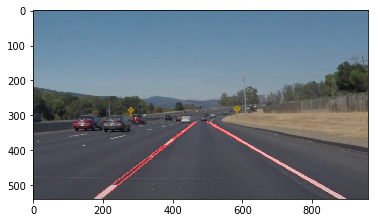

In [15]:
white_output = 'mysolidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[0] is the line now!
[[109 535 457 325]]
[0] We have -ve slope here is -0.603448275862 (right line) avg: -0.603448275862
[0]
[600.77586206896547, 600.77586206896558]
[1] is the line now!
[[124 538 414 357]]
[0] We have -ve slope here is -0.624137931034 (right line) avg: -0.624137931034
[0]
[600.77586206896547, 600.77586206896558, 615.39310344827584, 615.39310344827595]
[2] is the line now!
[[217 479 440 339]]
[1] We have -ve slope here is -0.627802690583 (right line) avg: -0.625970310809
[1]
[600.77586206896547, 600.77586206896558, 614.42693675583735, 614.83555744549244, 615.39310344827584, 615.39310344827595]
[3] is the line now!
[[524 332 759 497]]
[1] We have +ve slope here is 0.702127659574 (left line) avg: 0.351063829787
[1]
[148.04255319148936, 148.04255319148936]
[4] is the line now!
[[563 359 775 497]]
[2] We have +ve slope here is 0.650943396226 (left line) avg: 0.451023685267
[2]
[105.07366519470091, 105.07366519470091, 148.04255319148936, 148.04255319148936]
[5] is the line 

  0%|          | 2/682 [00:00<00:35, 19.33it/s]

[0] is the line now!
[[109 535 457 325]]
[0] We have -ve slope here is -0.603448275862 (right line) avg: -0.603448275862
[0]
[600.77586206896547, 600.77586206896558]
[1] is the line now!
[[124 538 414 357]]
[0] We have -ve slope here is -0.624137931034 (right line) avg: -0.624137931034
[0]
[600.77586206896547, 600.77586206896558, 615.39310344827584, 615.39310344827595]
[2] is the line now!
[[217 479 440 339]]
[1] We have -ve slope here is -0.627802690583 (right line) avg: -0.625970310809
[1]
[600.77586206896547, 600.77586206896558, 614.42693675583735, 614.83555744549244, 615.39310344827584, 615.39310344827595]
[3] is the line now!
[[524 332 759 497]]
[1] We have +ve slope here is 0.702127659574 (left line) avg: 0.351063829787
[1]
[148.04255319148936, 148.04255319148936]
[4] is the line now!
[[563 359 775 497]]
[2] We have +ve slope here is 0.650943396226 (left line) avg: 0.451023685267
[2]
[105.07366519470091, 105.07366519470091, 148.04255319148936, 148.04255319148936]
[5] is the line 

  1%|          | 5/682 [00:00<00:32, 20.81it/s]

[0] is the line now!
[[138 538 407 363]]
[0] We have -ve slope here is -0.650557620818 (right line) avg: -0.650557620818
[0]
[627.77695167286242, 627.77695167286242]
[1] is the line now!
[[118 538 456 327]]
[0] We have -ve slope here is -0.62426035503 (right line) avg: -0.62426035503
[0]
[611.66272189349115, 611.66272189349115, 627.77695167286242, 627.77695167286242]
[2] is the line now!
[[512 319 610 393]]
[1] We have +ve slope here is 0.755102040816 (left line) avg: 0.377551020408
[1]
[125.69387755102042, 125.69387755102042]
[3] is the line now!
[[513 323 684 434]]
[1] We have +ve slope here is 0.649122807018 (left line) avg: 0.513336913713
[1]
[59.658163265306086, 59.658163265306086, 125.69387755102042, 125.69387755102042]
[4] is the line now!
[[265 455 455 322]]
[2] We have -ve slope here is -0.7 (right line) avg: -0.649506903353
[2]
[611.66272189349115, 611.66272189349115, 617.52564102564099, 627.11932938856012, 627.77695167286242, 627.77695167286242]
[5] is the line now!
[[373 38

  1%|          | 8/682 [00:00<00:29, 22.47it/s]

[0] is the line now!
[[120 538 446 334]]
[0] We have -ve slope here is -0.625766871166 (right line) avg: -0.625766871166
[0]
[613.09202453987734, 613.09202453987734]
[1] is the line now!
[[139 538 375 384]]
[0] We have -ve slope here is -0.652542372881 (right line) avg: -0.652542372881
[0]
[613.09202453987734, 613.09202453987734, 628.70338983050851, 628.70338983050851]
[2] is the line now!
[[141 539 376 386]]
[1] We have -ve slope here is -0.651063829787 (right line) avg: -0.651803101334
[1]
[613.09202453987734, 613.09202453987734, 628.70338983050851, 628.70338983050851, 630.90423728813562, 631.07796610169498]
[3] is the line now!
[[512 320 763 496]]
[1] We have +ve slope here is 0.701195219124 (left line) avg: 0.350597609562
[1]
[140.49402390438246, 140.49402390438246]
[4] is the line now!
[[140 538 379 383]]
[2] We have -ve slope here is -0.648535564854 (right line) avg: -0.650713922507
[2]
[613.09202453987734, 613.09202453987734, 628.70338983050851, 628.70338983050851, 629.099949151

  2%|▏         | 11/682 [00:00<00:28, 23.49it/s]

[0] is the line now!
[[144 539 430 346]]
[0] We have -ve slope here is -0.674825174825 (right line) avg: -0.674825174825
[0]
[636.17482517482517, 636.17482517482517]
[1] is the line now!
[[141 528 454 325]]
[0] We have -ve slope here is -0.648562300319 (right line) avg: -0.648562300319
[0]
[619.44728434504793, 619.44728434504793, 636.17482517482517, 636.17482517482517]
[2] is the line now!
[[535 337 729 458]]
[1] We have +ve slope here is 0.623711340206 (left line) avg: 0.311855670103
[1]
[170.15721649484536, 170.15721649484536]
[3] is the line now!
[[144 538 443 336]]
[1] We have -ve slope here is -0.675585284281 (right line) avg: -0.6620737923
[1]
[619.44728434504793, 619.44728434504793, 629.29868998899428, 633.33862609123059, 636.17482517482517, 636.17482517482517]
[4] is the line now!
[[261 452 449 330]]
[2] We have -ve slope here is -0.648936170213 (right line) avg: -0.657694584938
[2]
[619.44728434504793, 619.44728434504793, 623.65828666874768, 625.30486863704095, 629.29868998899

  2%|▏         | 14/682 [00:00<00:27, 24.39it/s]

[0] is the line now!
[[129 538 446 332]]
[0] We have -ve slope here is -0.649842271293 (right line) avg: -0.649842271293
[0]
[621.82965299684543, 621.82965299684543]
[1] is the line now!
[[269 458 436 341]]
[0] We have -ve slope here is -0.700598802395 (right line) avg: -0.700598802395
[0]
[621.82965299684543, 621.82965299684543, 646.46107784431138, 646.46107784431138]
[2] is the line now!
[[523 329 858 538]]
[1] We have +ve slope here is 0.623880597015 (left line) avg: 0.311940298507
[1]
[165.85522388059701, 165.85522388059701]
[3] is the line now!
[[206 501 443 335]]
[1] We have -ve slope here is -0.700421940928 (right line) avg: -0.700510371662
[1]
[621.82965299684543, 621.82965299684543, 645.30513656231847, 645.32609464615075, 646.46107784431138, 646.46107784431138]
[4] is the line now!
[[624 399 838 538]]
[2] We have +ve slope here is 0.64953271028 (left line) avg: 0.424471102432
[2]
[134.13003208257777, 134.13003208257777, 165.85522388059701, 165.85522388059701]
[5] is the line n

  2%|▏         | 17/682 [00:00<00:26, 24.88it/s]

[0] is the line now!
[[156 539 422 352]]
[0] We have -ve slope here is -0.703007518797 (right line) avg: -0.703007518797
[0]
[648.66917293233087, 648.66917293233087]
[1] is the line now!
[[177 512 450 328]]
[0] We have -ve slope here is -0.673992673993 (right line) avg: -0.673992673993
[0]
[631.2967032967033, 631.2967032967033, 648.66917293233087, 648.66917293233087]
[2] is the line now!
[[136 539 453 325]]
[1] We have -ve slope here is -0.675078864353 (right line) avg: -0.674535769173
[1]
[630.56470343536591, 630.73686460752708, 631.2967032967033, 631.2967032967033, 648.66917293233087, 648.66917293233087]
[3] is the line now!
[[516 324 846 530]]
[1] We have +ve slope here is 0.624242424242 (left line) avg: 0.312121212121
[1]
[162.94545454545454, 162.94545454545454]
[4] is the line now!
[[156 538 431 345]]
[2] We have -ve slope here is -0.701818181818 (right line) avg: -0.683629906721
[2]
[630.56470343536591, 630.73686460752708, 631.2967032967033, 631.2967032967033, 639.64448979691883,

  3%|▎         | 20/682 [00:00<00:25, 25.88it/s]

[0] is the line now!
[[135 538 450 325]]
[0] We have -ve slope here is -0.67619047619 (right line) avg: -0.67619047619
[0]
[629.28571428571422, 629.28571428571433]
[1] is the line now!
[[220 491 426 346]]
[0] We have -ve slope here is -0.703883495146 (right line) avg: -0.703883495146
[0]
[629.28571428571422, 629.28571428571433, 645.85436893203882, 645.85436893203882]
[2] is the line now!
[[155 539 380 381]]
[1] We have -ve slope here is -0.702222222222 (right line) avg: -0.703052858684
[1]
[629.28571428571422, 629.28571428571433, 645.85436893203882, 645.85436893203882, 647.97319309600857, 648.1600862998921]
[3] is the line now!
[[517 323 767 479]]
[1] We have +ve slope here is 0.624 (left line) avg: 0.312
[1]
[161.696, 161.696]
[4] is the line now!
[[550 347 759 483]]
[2] We have +ve slope here is 0.650717703349 (left line) avg: 0.424905901116
[2]
[113.30175438596493, 113.30175438596493, 161.696, 161.696]
[5] is the line now!
[[154 538 457 318]]
[2] We have -ve slope here is -0.7260726

  3%|▎         | 23/682 [00:00<00:24, 26.40it/s]

[0] is the line now!
[[154 538 406 361]]
[0] We have -ve slope here is -0.702380952381 (right line) avg: -0.702380952381
[0]
[646.16666666666663, 646.16666666666663]
[1] is the line now!
[[134 539 446 328]]
[0] We have -ve slope here is -0.676282051282 (right line) avg: -0.676282051282
[0]
[629.62179487179492, 629.62179487179492, 646.16666666666663, 646.16666666666663]
[2] is the line now!
[[134 538 449 325]]
[1] We have -ve slope here is -0.67619047619 (right line) avg: -0.676236263736
[1]
[628.61565934065936, 628.63008241758246, 629.62179487179492, 629.62179487179492, 646.16666666666663, 646.16666666666663]
[3] is the line now!
[[530 332 823 515]]
[1] We have +ve slope here is 0.62457337884 (left line) avg: 0.31228668942
[1]
[166.48805460750853, 166.48805460750853]
[4] is the line now!
[[153 538 418 352]]
[2] We have -ve slope here is -0.701886792453 (right line) avg: -0.684786439975
[2]
[628.61565934065936, 628.63008241758246, 629.62179487179492, 629.62179487179492, 638.240731909599

  4%|▍         | 26/682 [00:00<00:24, 26.61it/s]

[0] is the line now!
[[139 538 437 337]]
[0] We have -ve slope here is -0.674496644295 (right line) avg: -0.674496644295
[0]
[631.755033557047, 631.755033557047]
[1] is the line now!
[[158 538 366 392]]
[0] We have -ve slope here is -0.701923076923 (right line) avg: -0.701923076923
[0]
[631.755033557047, 631.755033557047, 648.90384615384619, 648.90384615384619]
[2] is the line now!
[[539 340 860 533]]
[1] We have +ve slope here is 0.601246105919 (left line) avg: 0.30062305296
[1]
[177.96417445482868, 177.96417445482868]
[3] is the line now!
[[622 396 844 535]]
[1] We have +ve slope here is 0.626126126126 (left line) avg: 0.463374589543
[1]
[107.78100530436978, 107.78100530436978, 177.96417445482868, 177.96417445482868]
[4] is the line now!
[[314 427 410 359]]
[2] We have -ve slope here is -0.708333333333 (right line) avg: -0.70405982906
[2]
[631.755033557047, 631.755033557047, 647.66452991452991, 648.07478632478637, 648.90384615384619, 648.90384615384619]
[5] is the line now!
[[317 432

  4%|▍         | 29/682 [00:01<00:29, 22.05it/s]

[0] We have -ve slope here is -0.675675675676 (right line) avg: -0.675675675676
[0]
[631.91891891891896, 631.91891891891896]
[1] is the line now!
[[523 327 855 527]]
[0] We have +ve slope here is 0.602409638554 (left line) avg: 0.602409638554
[0]
[11.939759036144551, 11.939759036144551]
[2] is the line now!
[[160 537 363 394]]
[1] We have -ve slope here is -0.704433497537 (right line) avg: -0.690054586606
[1]
[631.91891891891896, 631.91891891891896, 644.48981493809083, 647.40873385700979]
[3] is the line now!
[[539 338 872 538]]
[1] We have +ve slope here is 0.600600600601 (left line) avg: 0.601505119577
[1]
[11.939759036144551, 11.939759036144551, 13.788740547776626, 13.788740547776626]
[4] is the line now!
[[361 394 404 363]]
[2] We have -ve slope here is -0.720930232558 (right line) avg: -0.70034646859
[2]
[631.91891891891896, 631.91891891891896, 644.48981493809083, 645.93997331046251, 646.8250751610816, 647.40873385700979]
[5] is the line now!
[[635 403 852 538]]
[2] We have +ve sl

  5%|▌         | 35/682 [00:01<00:27, 23.54it/s]

[0] is the line now!
[[164 539 361 395]]
[0] We have -ve slope here is -0.730964467005 (right line) avg: -0.730964467005
[0]
[658.87817258883251, 658.87817258883251]
[1] is the line now!
[[168 522 441 331]]
[0] We have -ve slope here is -0.699633699634 (right line) avg: -0.699633699634
[0]
[639.53846153846155, 639.53846153846155, 658.87817258883251, 658.87817258883251]
[2] is the line now!
[[398 365 421 348]]
[1] We have -ve slope here is -0.739130434783 (right line) avg: -0.719382067208
[1]
[639.53846153846155, 639.53846153846155, 650.85985029463291, 651.31406274884534, 658.87817258883251, 658.87817258883251]
[3] is the line now!
[[517 319 760 470]]
[1] We have +ve slope here is 0.621399176955 (left line) avg: 0.310699588477
[1]
[158.36831275720166, 158.36831275720166]
[4] is the line now!
[[263 457 433 338]]
[2] We have -ve slope here is -0.7 (right line) avg: -0.712921378139
[2]
[639.53846153846155, 639.53846153846155, 644.4983224504964, 646.6949567340871, 650.85985029463291, 651.31

  6%|▌         | 41/682 [00:01<00:25, 24.86it/s]


[3]
[71.70633658868951, 71.70633658868951, 108.94365794365794, 108.94365794365794, 190.40540540540542, 190.40540540540542]
[7] is the line now!
[[344 399 420 342]]
[3] We have -ve slope here is -0.75 (right line) avg: -0.740317898567
[3]
[645.01580395098779, 646.23934426229505, 646.23934426229505, 652.12743185796444, 652.9335173983369, 653.66935710720929, 657.78457469500995, 662.09411874768978, 665.35348837209301, 665.35348837209301]
[8] is the line now!
[[148 538 420 347]]
[4] We have -ve slope here is -0.702205882353 (right line) avg: -0.732695495325
[4]
[645.01580395098779, 646.23934426229505, 646.23934426229505, 646.43893330803542, 652.12743185796444, 652.9335173983369, 653.66935710720929, 654.73210803631662, 657.78457469500995, 662.09411874768978, 665.35348837209301, 665.35348837209301]
[0] is the line now!
[[167 523 426 341]]
[0] We have -ve slope here is -0.702702702703 (right line) avg: -0.702702702703
[0]
[640.35135135135135, 640.35135135135135]
[1] is the line now!
[[167 538

  7%|▋         | 47/682 [00:01<00:24, 25.82it/s]

[0] is the line now!
[[165 538 441 330]]
[0] We have -ve slope here is -0.753623188406 (right line) avg: -0.753623188406
[0]
[662.3478260869565, 662.3478260869565]
[1] is the line now!
[[224 484 453 318]]
[0] We have -ve slope here is -0.724890829694 (right line) avg: -0.724890829694
[0]
[646.37554585152839, 646.37554585152839, 662.3478260869565, 662.3478260869565]
[2] is the line now!
[[148 537 444 322]]
[1] We have -ve slope here is -0.726351351351 (right line) avg: -0.725621090523
[1]
[644.1757641921397, 644.39192139737997, 646.37554585152839, 646.37554585152839, 662.3478260869565, 662.3478260869565]
[3] is the line now!
[[169 537 393 368]]
[1] We have -ve slope here is -0.754464285714 (right line) avg: -0.740042688119
[1]
[644.1757641921397, 644.39192139737997, 646.37554585152839, 646.37554585152839, 658.83677643059468, 662.06721429203685, 662.3478260869565, 662.3478260869565]
[4] is the line now!
[[512 318 738 459]]
[2] We have +ve slope here is 0.62389380531 (left line) avg: 0.20

  7%|▋         | 50/682 [00:02<00:24, 25.45it/s]

[3] is the line now!
[[164 538 451 321]]
[1] We have -ve slope here is -0.756097560976 (right line) avg: -0.741494158639
[1]
[645.65126050420167, 645.65126050420167, 655.4138655462184, 659.60504201680669, 663.83146067415726, 663.83146067415737]
[4] is the line now!
[[560 353 749 471]]
[2] We have +ve slope here is 0.624338624339 (left line) avg: 0.409192496912
[2]
[123.85220172939475, 123.85220172939475, 165.96761133603238, 165.96761133603238]
[5] is the line now!
[[258 459 453 318]]
[2] We have -ve slope here is -0.723076923077 (right line) avg: -0.735355080118
[2]
[645.65126050420167, 645.65126050420167, 648.72161067053457, 651.1158512936131, 655.4138655462184, 659.60504201680669, 663.83146067415726, 663.83146067415737]
[6] is the line now!
[[145 538 433 336]]
[3] We have -ve slope here is -0.701388888889 (right line) avg: -0.726863532311
[3]
[643.39521218509287, 645.65126050420167, 645.65126050420167, 648.72161067053457, 650.73190949065679, 651.1158512936131, 655.4138655462184, 659.

  8%|▊         | 53/682 [00:02<00:25, 24.60it/s]

[0] is the line now!
[[169 535 449 324]]
[0] We have -ve slope here is -0.753571428571 (right line) avg: -0.753571428571
[0]
[662.3535714285714, 662.3535714285714]
[1] is the line now!
[[143 538 452 321]]
[0] We have -ve slope here is -0.702265372168 (right line) avg: -0.702265372168
[0]
[638.42394822006474, 638.42394822006474, 662.3535714285714, 662.3535714285714]
[2] is the line now!
[[537 339 856 539]]
[1] We have +ve slope here is 0.626959247649 (left line) avg: 0.313479623824
[1]
[170.66144200626957, 170.66144200626957]
[3] is the line now!
[[509 318 876 538]]
[1] We have +ve slope here is 0.599455040872 (left line) avg: 0.456467332348
[1]
[85.658127834769743, 85.658127834769743, 170.66144200626957, 170.66144200626957]
[4] is the line now!
[[163 538 456 318]]
[2] We have -ve slope here is -0.750853242321 (right line) avg: -0.718461328886
[2]
[638.42394822006474, 638.42394822006474, 645.61836597192314, 655.10919660838476, 662.3535714285714, 662.3535714285714]
[5] is the line now!
[

  8%|▊         | 56/682 [00:02<00:24, 25.11it/s]

[0] is the line now!
[[142 539 455 319]]
[0] We have -ve slope here is -0.702875399361 (right line) avg: -0.702875399361
[0]
[638.80830670926514, 638.80830670926525]
[1] is the line now!
[[269 461 435 336]]
[0] We have -ve slope here is -0.753012048193 (right line) avg: -0.753012048193
[0]
[638.80830670926514, 638.80830670926525, 663.56024096385545, 663.56024096385545]
[2] is the line now!
[[247 477 448 320]]
[1] We have -ve slope here is -0.781094527363 (right line) avg: -0.767053287778
[1]
[638.80830670926514, 638.80830670926525, 663.56024096385545, 663.56024096385545, 663.63987292453396, 666.4621620811605]
[3] is the line now!
[[163 539 456 318]]
[1] We have -ve slope here is -0.754266211604 (right line) avg: -0.760659749691
[1]
[638.80830670926514, 638.80830670926525, 662.98753919963895, 663.56024096385545, 663.56024096385545, 663.63987292453396, 664.86084585911271, 666.4621620811605]
[4] is the line now!
[[148 535 448 325]]
[2] We have -ve slope here is -0.7 (right line) avg: -0.7

  9%|▊         | 59/682 [00:02<00:24, 25.42it/s]

[0] is the line now!
[[140 538 455 318]]
[0] We have -ve slope here is -0.698412698413 (right line) avg: -0.698412698413
[0]
[635.77777777777783, 635.77777777777783]
[1] is the line now!
[[218 495 426 343]]
[0] We have -ve slope here is -0.730769230769 (right line) avg: -0.730769230769
[0]


  9%|▉         | 62/682 [00:02<00:24, 24.88it/s]

[635.77777777777783, 635.77777777777783, 654.30769230769226, 654.30769230769226]
[2] is the line now!
[[160 539 238 482]]
[1] We have -ve slope here is -0.730769230769 (right line) avg: -0.730769230769
[1]
[635.77777777777783, 635.77777777777783, 654.30769230769226, 654.30769230769226, 655.92307692307691, 655.92307692307691]
[3] is the line now!
[[619 394 836 529]]
[1] We have +ve slope here is 0.622119815668 (left line) avg: 0.311059907834
[1]
[201.45391705069125, 201.45391705069125]
[4] is the line now!
[[514 324 848 525]]
[2] We have +ve slope here is 0.601796407186 (left line) avg: 0.407972074285
[2]
[114.30235381771021, 114.30235381771021, 201.45391705069125, 201.45391705069125]
[5] is the line now!
[[140 539 456 318]]
[2] We have -ve slope here is -0.699367088608 (right line) avg: -0.720301850049
[2]
[635.77777777777783, 635.77777777777783, 639.84225900681599, 646.45764362220052, 654.30769230769226, 654.30769230769226, 655.92307692307691, 655.92307692307691]
[6] is the line now!


 10%|▉         | 65/682 [00:02<00:25, 24.54it/s]

[0] is the line now!
[[220 493 417 350]]
[0] We have -ve slope here is -0.725888324873 (right line) avg: -0.725888324873
[0]
[652.69543147208117, 652.69543147208128]
[1] is the line now!
[[136 538 436 335]]
[0] We have -ve slope here is -0.676666666667 (right line) avg: -0.676666666667
[0]
[630.02666666666664, 630.02666666666664, 652.69543147208117, 652.69543147208128]
[2] is the line now!
[[571 364 850 539]]
[1] We have +ve slope here is 0.627240143369 (left line) avg: 0.313620071685
[1]
[184.92293906810036, 184.92293906810036]
[3] is the line now!
[[518 327 864 534]]
[1] We have +ve slope here is 0.598265895954 (left line) avg: 0.455942983819
[1]
[90.821534381668641, 90.821534381668641, 184.92293906810036, 184.92293906810036]
[4] is the line now!
[[202 506 445 323]]
[2] We have -ve slope here is -0.753086419753 (right line) avg: -0.702139917695
[2]
[630.02666666666664, 630.02666666666664, 635.4522633744856, 647.83226337448559, 652.69543147208117, 652.69543147208128]
[5] is the line n

 10%|▉         | 68/682 [00:02<00:24, 25.26it/s]

[0]
[652.478102189781, 652.478102189781]
[1] is the line now!
[[225 479 454 319]]
[0] We have -ve slope here is -0.698689956332 (right line) avg: -0.698689956332
[0]
[636.20524017467244, 636.20524017467255, 652.478102189781, 652.478102189781]
[2] is the line now!
[[185 506 438 329]]
[1] We have -ve slope here is -0.699604743083 (right line) avg: -0.699147349707
[1]
[635.22653917185903, 635.34225969587658, 636.20524017467244, 636.20524017467255, 652.478102189781, 652.478102189781]
[3] is the line now!
[[572 365 849 538]]
[1] We have +ve slope here is 0.624548736462 (left line) avg: 0.312274368231
[1]
[186.37906137184115, 186.37906137184115]
[4] is the line now!
[[519 328 870 539]]
[2] We have +ve slope here is 0.60113960114 (left line) avg: 0.408562779201
[2]
[115.95591759490677, 115.95591759490677, 186.37906137184115, 186.37906137184115]
[5] is the line now!
[[154 527 444 324]]
[2] We have -ve slope here is -0.7 (right line) avg: -0.699431566472
[2]
[634.54761551340243, 634.71246123663

 10%|█         | 71/682 [00:02<00:27, 21.89it/s]

[0] is the line now!
[[140 536 447 328]]
[0] We have -ve slope here is -0.677524429967 (right line) avg: -0.677524429967
[0]
[630.85342019543975, 630.85342019543975]
[1] is the line now!
[[158 539 437 336]]
[0] We have -ve slope here is -0.727598566308 (right line) avg: -0.727598566308
[0]
[630.85342019543975, 630.85342019543975, 653.96057347670251, 653.96057347670251]
[2] is the line now!
[[505 318 758 476]]
[1] We have +ve slope here is 0.624505928854 (left line) avg: 0.312252964427
[1]
[160.3122529644269, 160.3122529644269]
[3] is the line now!
[[507 320 736 474]]
[1] We have +ve slope here is 0.672489082969 (left line) avg: 0.492371023698
[1]
[70.367890985035473, 70.367890985035473, 160.3122529644269, 160.3122529644269]
[4] is the line now!
[[256 468 424 346]]
[2] We have -ve slope here is -0.72619047619 (right line) avg: -0.727129202936
[2]
[630.85342019543975, 630.85342019543975, 653.96057347670251, 653.96057347670251, 654.14507595152759, 654.30278204471756]
[5] is the line now!


 11%|█         | 74/682 [00:03<00:28, 21.28it/s]

[0] is the line now!
[[218 496 430 342]]
[0] We have -ve slope here is -0.72641509434 (right line) avg: -0.72641509434
[0]
[654.35849056603774, 654.35849056603774]
[1] is the line now!
[[167 532 448 328]]
[0] We have -ve slope here is -0.725978647687 (right line) avg: -0.725978647687
[0]
[653.23843416370107, 653.23843416370107, 654.35849056603774, 654.35849056603774]
[2] is the line now!
[[209 491 446 325]]
[1] We have -ve slope here is -0.700421940928 (right line) avg: -0.713200294308
[1]
[640.05886151027823, 643.08733126116795, 653.23843416370107, 653.23843416370107, 654.35849056603774, 654.35849056603774]
[3] is the line now!
[[264 454 459 318]]
[1] We have -ve slope here is -0.697435897436 (right line) avg: -0.705318095872
[1]
[640.05886151027823, 640.20397731013531, 641.74100600512156, 643.08733126116795, 653.23843416370107, 653.23843416370107, 654.35849056603774, 654.35849056603774]
[4] is the line now!
[[504 318 687 441]]
[2] We have +ve slope here is 0.672131147541 (left line) 

 11%|█▏        | 77/682 [00:03<00:31, 19.51it/s]

[0] is the line now!
[[138 538 443 332]]
[0] We have -ve slope here is -0.675409836066 (right line) avg: -0.675409836066
[0]
[631.20655737704919, 631.20655737704919]
[1] is the line now!
[[235 484 414 354]]
[0] We have -ve slope here is -0.72625698324 (right line) avg: -0.72625698324
[0]
[631.20655737704919, 631.20655737704919, 654.67039106145251, 654.67039106145251]
[2] is the line now!
[[537 343 861 538]]
[1] We have +ve slope here is 0.601851851852 (left line) avg: 0.300925925926
[1]
[181.40277777777777, 181.40277777777777]
[3] is the line now!
[[168 532 453 318]]
[1] We have -ve slope here is -0.750877192982 (right line) avg: -0.738567088111
[1]
[631.20655737704919, 631.20655737704919, 652.57089091443686, 654.67039106145251, 654.67039106145251, 656.07927080270508]
[4] is the line now!
[[510 321 750 482]]
[2] We have +ve slope here is 0.670833333333 (left line) avg: 0.424228395062
[2]
[104.64351851851856, 104.64351851851856, 181.40277777777777, 181.40277777777777]
[5] is the line no

 12%|█▏        | 80/682 [00:03<00:31, 19.28it/s]


[7] is the line now!
[[314 418 451 325]]
[3] We have -ve slope here is -0.678832116788 (right line) avg: -0.726396509652
[3]
[631.20655737704919, 631.20655737704919, 646.08850403065867, 652.57089091443686, 652.60482585295244, 654.67039106145251, 654.67039106145251, 655.27083696554655, 656.07927080270508, 657.77979021459089]
[8] is the line now!
[[158 539 448 328]]
[4] We have -ve slope here is -0.727586206897 (right line) avg: -0.726634449101
[4]
[631.20655737704919, 631.20655737704919, 646.08850403065867, 652.57089091443686, 652.60482585295244, 653.53223319712879, 653.80824295791592, 654.67039106145251, 654.67039106145251, 655.27083696554655, 656.07927080270508, 657.77979021459089]
[9] is the line now!
[[565 362 800 514]]
[4] We have +ve slope here is 0.646808510638 (left line) avg: 0.528908118505
[4]
[63.166913044403032, 63.166913044403032, 70.794262374888092, 70.794262374888092, 104.64351851851856, 104.64351851851856, 181.40277777777777, 181.40277777777777]
[0] is the line now!
[[1

 12%|█▏        | 83/682 [00:03<00:28, 20.82it/s]

[0] is the line now!
[[218 494 448 327]]
[0] We have -ve slope here is -0.726086956522 (right line) avg: -0.726086956522
[0]
[652.28695652173917, 652.28695652173917]
[1] is the line now!
[[239 469 447 323]]
[0] We have -ve slope here is -0.701923076923 (right line) avg: -0.701923076923
[0]
[636.75961538461536, 636.75961538461536, 652.28695652173917, 652.28695652173917]
[2] is the line now!
[[176 511 452 318]]
[1] We have -ve slope here is -0.699275362319 (right line) avg: -0.700599219621
[1]
[634.30546265328871, 634.67084726867336, 636.75961538461536, 636.75961538461536, 652.28695652173917, 652.28695652173917]
[3] is the line now!
[[155 539 458 318]]
[1] We have -ve slope here is -0.729372937294 (right line) avg: -0.714986078457
[1]
[634.30546265328871, 634.67084726867336, 636.75961538461536, 636.75961538461536, 645.46362393346362, 649.82284216088829, 652.28695652173917, 652.28695652173917]
[4] is the line now!
[[507 318 628 403]]
[2] We have +ve slope here is 0.702479338843 (left line

 13%|█▎        | 86/682 [00:03<00:27, 21.56it/s]

[0] is the line now!
[[221 492 444 330]]
[0] We have -ve slope here is -0.726457399103 (right line) avg: -0.726457399103
[0]
[652.54708520179372, 652.54708520179372]
[1] is the line now!
[[133 538 458 318]]
[0] We have -ve slope here is -0.676923076923 (right line) avg: -0.676923076923
[0]
[628.03076923076924, 628.03076923076924, 652.54708520179372, 652.54708520179372]
[2] is the line now!
[[134 539 450 325]]
[1] We have -ve slope here is -0.677215189873 (right line) avg: -0.677069133398
[1]
[628.03076923076924, 628.03076923076924, 629.68111002921125, 629.72726387536511, 652.54708520179372, 652.54708520179372]
[3] is the line now!
[[225 489 453 318]]
[1] We have -ve slope here is -0.75 (right line) avg: -0.713534566699
[1]
[628.03076923076924, 628.03076923076924, 629.68111002921125, 629.72726387536511, 641.23115871470304, 649.54527750730279, 652.54708520179372, 652.54708520179372]
[4] is the line now!
[[507 318 755 479]]
[2] We have +ve slope here is 0.649193548387 (left line) avg: 0.2

 13%|█▎        | 89/682 [00:03<00:26, 22.33it/s]

[0] is the line now!
[[149 539 327 414]]
[0] We have -ve slope here is -0.702247191011 (right line) avg: -0.702247191011
[0]
[643.63483146067415, 643.63483146067415]
[1] is the line now!
[[129 539 457 318]]
[0] We have -ve slope here is -0.673780487805 (right line) avg: -0.673780487805
[0]
[625.91768292682923, 625.91768292682923, 643.63483146067415, 643.63483146067415]
[2] is the line now!
[[505 318 796 500]]
[1] We have +ve slope here is 0.625429553265 (left line) avg: 0.312714776632
[1]
[160.07903780068727, 160.07903780068727]
[3] is the line now!
[[558 357 782 502]]
[1] We have +ve slope here is 0.647321428571 (left line) avg: 0.480018102602
[1]
[89.149898748159046, 89.149898748159046, 160.07903780068727, 160.07903780068727]
[4] is the line now!
[[149 538 437 336]]
[2] We have -ve slope here is -0.701388888889 (right line) avg: -0.682983288166
[2]
[625.91768292682923, 625.91768292682923, 634.46369692863595, 639.76450993676599, 643.63483146067415, 643.63483146067415]
[5] is the line 

 13%|█▎        | 92/682 [00:03<00:26, 22.23it/s]

[0] is the line now!
[[135 539 462 318]]
[0] We have -ve slope here is -0.675840978593 (right line) avg: -0.675840978593
[0]
[630.23853211009168, 630.23853211009168]
[1] is the line now!
[[155 538 437 340]]
[0] We have -ve slope here is -0.702127659574 (right line) avg: -0.702127659574
[0]
[630.23853211009168, 630.23853211009168, 646.82978723404256, 646.82978723404256]
[2] is the line now!
[[505 318 832 539]]
[1] We have +ve slope here is 0.675840978593 (left line) avg: 0.337920489297
[1]
[147.35015290519877, 147.35015290519877]
[3] is the line now!
[[154 538 446 333]]
[1] We have -ve slope here is -0.702054794521 (right line) avg: -0.702091227048
[1]
[630.23853211009168, 630.23853211009168, 646.12204896531625, 646.13268726318859, 646.82978723404256, 646.82978723404256]
[4] is the line now!
[[308 424 455 325]]
[2] We have -ve slope here is -0.673469387755 (right line) avg: -0.69255061395
[2]
[630.23853211009168, 630.23853211009168, 637.30558909661215, 640.11052934726786, 646.1220489653

 14%|█▍        | 95/682 [00:04<00:27, 21.20it/s]

[0] is the line now!
[[155 538 444 335]]
[0] We have -ve slope here is -0.702422145329 (right line) avg: -0.702422145329
[0]
[646.87543252595151, 646.87543252595151]
[1] is the line now!
[[151 529 464 318]]
[0] We have -ve slope here is -0.674121405751 (right line) avg: -0.674121405751
[0]
[630.79233226837061, 630.79233226837061, 646.87543252595151, 646.87543252595151]
[2] is the line now!
[[136 539 463 318]]
[1] We have -ve slope here is -0.675840978593 (right line) avg: -0.674981192172
[1]
[630.51629197565239, 630.79233226837061, 630.79233226837061, 630.79744213539686, 646.87543252595151, 646.87543252595151]
[3] is the line now!
[[499 318 675 432]]
[1] We have +ve slope here is 0.647727272727 (left line) avg: 0.323863636364
[1]
[156.39204545454547, 156.39204545454547]
[4] is the line now!
[[512 329 665 432]]
[2] We have +ve slope here is 0.673202614379 (left line) avg: 0.440309962369
[2]
[103.56129926718162, 103.56129926718162, 156.39204545454547, 156.39204545454547]
[5] is the line 

 15%|█▍        | 101/682 [00:04<00:25, 22.45it/s]

[2]
[218.37084673097536, 218.37084673097536]
[5] is the line now!
[[609 394 799 517]]
[2] We have +ve slope here is 0.647368421053 (left line) avg: 0.354410409733
[2]
[178.16406047272523, 178.16406047272523, 218.37084673097536, 218.37084673097536]
[6] is the line now!
[[166 531 373 391]]
[3] We have -ve slope here is -0.676328502415 (right line) avg: -0.692685965812
[3]
[629.49847094801225, 629.49847094801225, 633.46286862014847, 637.79557538706581, 643.87905804230195, 645.02664371208391, 645.98587032476894, 647.37218045112786, 647.37218045112786, 649.37186524782419]
[7] is the line now!
[[501 318 796 517]]
[3] We have +ve slope here is 0.674576271186 (left line) avg: 0.434451875096
[3]
[100.33961057679898, 100.33961057679898, 178.16406047272523, 178.16406047272523, 218.37084673097536, 218.37084673097536]
[0] is the line now!
[[137 538 463 318]]
[0] We have -ve slope here is -0.674846625767 (right line) avg: -0.674846625767
[0]
[630.45398773006127, 630.45398773006139]
[1] is the line n

 15%|█▌        | 104/682 [00:04<00:24, 23.58it/s]

[1] is the line now!
[[154 538 423 349]]
[0] We have -ve slope here is -0.702602230483 (right line) avg: -0.702602230483
[0]
[629.56766917293237, 629.56766917293237, 646.20074349442382, 646.20074349442382]
[2] is the line now!
[[502 318 854 538]]
[1] We have +ve slope here is 0.625 (left line) avg: 0.3125
[1]
[161.125, 161.125]
[3] is the line now!
[[708 458 832 539]]
[1] We have +ve slope here is 0.653225806452 (left line) avg: 0.482862903226
[1]
[116.13306451612902, 116.13306451612902, 161.125, 161.125]
[4] is the line now!
[[185 505 240 467]]
[2] We have -ve slope here is -0.690909090909 (right line) avg: -0.698704517292
[2]
[629.56766917293237, 629.56766917293237, 634.26033569899744, 634.68908415005069, 646.20074349442382, 646.20074349442382]
[5] is the line now!
[[568 365 828 521]]
[2] We have +ve slope here is 0.6 (left line) avg: 0.521908602151
[2]
[68.55591397849463, 68.55591397849463, 116.13306451612902, 116.13306451612902, 161.125, 161.125]
[6] is the line now!
[[155 538 400 

 16%|█▌        | 107/682 [00:04<00:23, 24.15it/s]

[0] is the line now!
[[215 485 464 318]]
[0] We have -ve slope here is -0.670682730924 (right line) avg: -0.670682730924
[0]
[629.19678714859435, 629.19678714859447]
[1] is the line now!
[[154 539 396 369]]
[0] We have -ve slope here is -0.702479338843 (right line) avg: -0.702479338843
[0]
[629.19678714859435, 629.19678714859447, 647.18181818181824, 647.18181818181824]
[2] is the line now!
[[153 538 431 343]]
[1] We have -ve slope here is -0.701438848921 (right line) avg: -0.701959093882
[1]
[629.19678714859435, 629.19678714859447, 645.39974136393369, 645.54436946310716, 647.18181818181824, 647.18181818181824]
[3] is the line now!
[[132 539 450 324]]
[1] We have -ve slope here is -0.676100628931 (right line) avg: -0.689029861406
[1]
[629.19678714859435, 629.19678714859447, 629.95194170564059, 634.06343763286577, 645.39974136393369, 645.54436946310716, 647.18181818181824, 647.18181818181824]
[4] is the line now!
[[501 318 694 448]]
[2] We have +ve slope here is 0.673575129534 (left line

 16%|█▌        | 110/682 [00:04<00:23, 24.80it/s]

[0] is the line now!
[[156 538 416 355]]
[0] We have -ve slope here is -0.703846153846 (right line) avg: -0.703846153846
[0]
[647.79999999999995, 647.79999999999995]
[1] is the line now!
[[135 538 410 359]]
[0] We have -ve slope here is -0.650909090909 (right line) avg: -0.650909090909
[0]
[625.87272727272727, 625.87272727272727, 647.79999999999995, 647.79999999999995]
[2] is the line now!
[[228 477 465 318]]
[1] We have -ve slope here is -0.670886075949 (right line) avg: -0.660897583429
[1]
[625.31737629459144, 625.87272727272727, 625.87272727272727, 627.68464902186417, 647.79999999999995, 647.79999999999995]
[3] is the line now!
[[514 329 779 495]]
[1] We have +ve slope here is 0.62641509434 (left line) avg: 0.31320754717
[1]
[168.01132075471699, 168.01132075471699]
[4] is the line now!
[[135 539 430 340]]
[2] We have -ve slope here is -0.674576271186 (right line) avg: -0.665457146015
[2]
[625.31737629459144, 625.87272727272727, 625.87272727272727, 626.1465727864354, 627.684649021864

 17%|█▋        | 113/682 [00:04<00:22, 25.33it/s]

[0] is the line now!
[[137 539 465 318]]
[0] We have -ve slope here is -0.673780487805 (right line) avg: -0.673780487805
[0]
[631.30792682926835, 631.30792682926835]
[1] is the line now!
[[157 538 391 374]]
[0] We have -ve slope here is -0.700854700855 (right line) avg: -0.700854700855
[0]
[631.30792682926835, 631.30792682926835, 648.03418803418799, 648.03418803418799]
[2] is the line now!
[[501 318 756 477]]
[1] We have +ve slope here is 0.623529411765 (left line) avg: 0.311764705882
[1]
[161.80588235294118, 161.80588235294118]
[3] is the line now!
[[533 342 744 479]]
[1] We have +ve slope here is 0.649289099526 (left line) avg: 0.480526902704
[1]
[85.879160858656235, 85.879160858656235, 161.80588235294118, 161.80588235294118]
[4] is the line now!
[[137 538 429 341]]
[2] We have -ve slope here is -0.674657534247 (right line) avg: -0.692122311985
[2]
[631.30792682926835, 631.30792682926835, 632.82075674198961, 637.92047184170474, 648.03418803418799, 648.03418803418799]
[5] is the line 

 17%|█▋        | 116/682 [00:04<00:23, 24.42it/s]

[0] is the line now!
[[197 499 466 318]]
[0] We have -ve slope here is -0.672862453532 (right line) avg: -0.672862453532
[0]
[631.55390334572485, 631.55390334572485]
[1] is the line now!
[[501 318 805 508]]
[0] We have +ve slope here is 0.625 (left line) avg: 0.625
[0]
[4.875, 4.875]
[2] is the line now!
[[232 485 408 361]]
[1] We have -ve slope here is -0.704545454545 (right line) avg: -0.688703954039
[1]
[631.55390334572485, 631.55390334572485, 641.99121324771886, 644.77931733693811]
[3] is the line now!
[[534 342 790 508]]
[1] We have +ve slope here is 0.6484375 (left line) avg: 0.63671875
[1]
[1.9921875, 1.9921875, 4.875, 4.875]
[4] is the line now!
[[158 539 328 419]]
[2] We have -ve slope here is -0.705882352941 (right line) avg: -0.694430087006
[2]
[631.55390334572485, 631.55390334572485, 641.99121324771886, 644.77931733693811, 646.77306853799314, 648.71995374696007]
[5] is the line now!
[[137 538 436 336]]
[2] We have -ve slope here is -0.675585284281 (right line) avg: -0.68814

 18%|█▊        | 122/682 [00:05<00:23, 23.40it/s]

[0] is the line now!
[[138 539 465 318]]
[0] We have -ve slope here is -0.675840978593 (right line) avg: -0.675840978593
[0]
[632.26605504587155, 632.26605504587155]
[1] is the line now!
[[159 539 282 450]]
[0] We have -ve slope here is -0.723577235772 (right line) avg: -0.723577235772
[0]
[632.26605504587155, 632.26605504587155, 654.04878048780483, 654.04878048780483]
[2] is the line now!
[[272 459 466 318]]
[1] We have -ve slope here is -0.726804123711 (right line) avg: -0.725190679742
[1]
[632.26605504587155, 632.26605504587155, 654.04878048780483, 654.04878048780483, 655.93885675970159, 656.25186488978295]
[3] is the line now!
[[394 364 461 318]]
[1] We have -ve slope here is -0.686567164179 (right line) avg: -0.70587892196
[1]
[632.26605504587155, 632.26605504587155, 642.11629525242779, 643.41018302377984, 654.04878048780483, 654.04878048780483, 655.93885675970159, 656.25186488978295]
[4] is the line now!
[[502 319 699 442]]
[2] We have +ve slope here is 0.624365482234 (left line)

 19%|█▉        | 128/682 [00:05<00:22, 24.62it/s]

[0] is the line now!
[[163 539 467 318]]
[0] We have -ve slope here is -0.726973684211 (right line) avg: -0.726973684211
[0]
[657.49671052631584, 657.49671052631584]
[1] is the line now!
[[224 484 462 318]]
[0] We have -ve slope here is -0.697478991597 (right line) avg: -0.697478991597
[0]
[640.23529411764707, 640.23529411764707, 657.49671052631584, 657.49671052631584]
[2] is the line now!
[[178 515 349 396]]
[1] We have -ve slope here is -0.695906432749 (right line) avg: -0.696692712173
[1]
[639.01130276672075, 639.14575654823329, 640.23529411764707, 640.23529411764707, 657.49671052631584, 657.49671052631584]
[3] is the line now!
[[498 318 706 453]]
[1] We have +ve slope here is 0.649038461538 (left line) avg: 0.324519230769
[1]
[156.38942307692307, 156.38942307692307]
[4] is the line now!
[[499 318 716 453]]
[2] We have +ve slope here is 0.622119815668 (left line) avg: 0.423719425736
[2]
[106.56400655795818, 106.56400655795818, 156.38942307692307, 156.38942307692307]
[5] is the line 

 19%|█▉        | 131/682 [00:05<00:21, 25.24it/s]

[0] is the line now!
[[143 538 469 318]]
[0] We have -ve slope here is -0.674846625767 (right line) avg: -0.674846625767
[0]
[634.50306748466255, 634.50306748466255]
[1] is the line now!
[[164 539 442 337]]
[0] We have -ve slope here is -0.726618705036 (right line) avg: -0.726618705036
[0]
[634.50306748466255, 634.50306748466255, 658.16546762589928, 658.16546762589928]
[2] is the line now!
[[396 365 465 318]]
[1] We have -ve slope here is -0.68115942029 (right line) avg: -0.703889062663
[1]
[634.50306748466255, 634.50306748466255, 643.74006881451362, 645.30841413825465, 658.16546762589928, 658.16546762589928]
[3] is the line now!
[[201 513 470 318]]
[1] We have -ve slope here is -0.724907063197 (right line) avg: -0.71439806293
[1]
[634.50306748466255, 634.50306748466255, 643.74006881451362, 645.30841413825465, 653.7670895770857, 656.59401064892381, 658.16546762589928, 658.16546762589928]
[4] is the line now!
[[503 321 839 539]]
[2] We have +ve slope here is 0.64880952381 (left line) av

 20%|█▉        | 134/682 [00:05<00:23, 23.76it/s]

[0] is the line now!
[[163 539 439 339]]
[0] We have -ve slope here is -0.724637681159 (right line) avg: -0.724637681159
[0]
[657.1159420289855, 657.1159420289855]
[1] is the line now!
[[143 538 469 318]]
[0] We have -ve slope here is -0.674846625767 (right line) avg: -0.674846625767
[0]
[634.50306748466255, 634.50306748466255, 657.1159420289855, 657.1159420289855]
[2] is the line now!
[[517 329 783 495]]
[1] We have +ve slope here is 0.624060150376 (left line) avg: 0.312030075188
[1]
[167.68045112781954, 167.68045112781954]
[3] is the line now!
[[351 396 464 319]]
[1] We have -ve slope here is -0.681415929204 (right line) avg: -0.678131277485
[1]
[633.6529127531353, 634.02407839730711, 634.50306748466255, 634.50306748466255, 657.1159420289855, 657.1159420289855]
[4] is the line now!
[[503 318 786 495]]
[2] We have +ve slope here is 0.625441696113 (left line) avg: 0.416500615496
[2]
[108.50019040534198, 108.50019040534198, 167.68045112781954, 167.68045112781954]
[5] is the line now!
[[

 20%|██        | 137/682 [00:05<00:24, 22.50it/s]

[0] is the line now!
[[143 538 469 318]]
[0] We have -ve slope here is -0.674846625767 (right line) avg: -0.674846625767
[0]
[634.50306748466255, 634.50306748466255]
[1] is the line now!
[[164 539 446 335]]
[0] We have -ve slope here is -0.723404255319 (right line) avg: -0.723404255319
[0]
[634.50306748466255, 634.50306748466255, 657.63829787234044, 657.63829787234044]
[2] is the line now!
[[503 319 841 530]]
[1] We have +ve slope here is 0.62426035503 (left line) avg: 0.312130177515
[1]
[161.99852071005918, 161.99852071005918]
[3] is the line now!
[[505 323 831 535]]
[1] We have +ve slope here is 0.650306748466 (left line) avg: 0.481218462991
[1]
[79.984676189784722, 79.984676189784722, 161.99852071005918, 161.99852071005918]
[4] is the line now!
[[375 380 464 319]]
[2] We have -ve slope here is -0.685393258427 (right line) avg: -0.710733923022
[2]
[634.50306748466255, 634.50306748466255, 646.52522113315808, 648.78054028209419, 657.63829787234044, 657.63829787234044]
[5] is the line n

 21%|██        | 140/682 [00:05<00:26, 20.09it/s]

[0] is the line now!
[[181 526 468 318]]
[0] We have -ve slope here is -0.724738675958 (right line) avg: -0.724738675958
[0]
[657.17770034843204, 657.17770034843215]
[1] is the line now!
[[270 452 461 319]]
[0] We have -ve slope here is -0.696335078534 (right line) avg: -0.696335078534
[0]
[640.01047120418843, 640.01047120418843, 657.17770034843204, 657.17770034843215]
[2] is the line now!
[[510 325 801 514]]
[1] We have +ve slope here is 0.649484536082 (left line) avg: 0.324742268041
[1]
[159.38144329896906, 159.38144329896906]
[3] is the line now!
[[497 319 816 511]]
[1] We have +ve slope here is 0.601880877743 (left line) avg: 0.463311572892
[1]
[88.734148272630335, 88.734148272630335, 159.38144329896906, 159.38144329896906]
[4] is the line now!
[[232 478 314 421]]
[2] We have -ve slope here is -0.69512195122 (right line) avg: -0.695930702763
[2]
[639.45592304090576, 639.52224066743281, 640.01047120418843, 640.01047120418843, 657.17770034843204, 657.17770034843215]
[5] is the line n

 21%|██        | 143/682 [00:06<00:25, 21.34it/s]

[0] is the line now!
[[164 538 467 318]]
[0] We have -ve slope here is -0.726072607261 (right line) avg: -0.726072607261
[0]
[657.07590759075902, 657.07590759075902]
[1] is the line now!
[[142 538 467 319]]
[0] We have -ve slope here is -0.673846153846 (right line) avg: -0.673846153846
[0]
[633.68615384615384, 633.68615384615384, 657.07590759075902, 657.07590759075902]
[2] is the line now!
[[376 378 464 318]]
[1] We have -ve slope here is -0.681818181818 (right line) avg: -0.677832167832
[1]
[632.51412587412585, 632.86489510489514, 633.68615384615384, 633.68615384615384, 657.07590759075902, 657.07590759075902]
[3] is the line now!
[[301 430 457 328]]
[1] We have -ve slope here is -0.653846153846 (right line) avg: -0.665839160839
[1]
[630.41758741258741, 632.2884965034965, 632.51412587412585, 632.86489510489514, 633.68615384615384, 633.68615384615384, 657.07590759075902, 657.07590759075902]
[4] is the line now!
[[496 320 841 527]]
[2] We have +ve slope here is 0.6 (left line) avg: 0.2
[

 21%|██▏       | 146/682 [00:06<00:23, 22.63it/s]

[0] is the line now!
[[165 538 467 318]]
[0] We have -ve slope here is -0.728476821192 (right line) avg: -0.728476821192
[0]
[658.19867549668879, 658.19867549668879]
[1] is the line now!
[[245 470 423 346]]
[0] We have -ve slope here is -0.696629213483 (right line) avg: -0.696629213483
[0]
[640.67415730337075, 640.67415730337075, 658.19867549668879, 658.19867549668879]
[2] is the line now!
[[163 526 287 440]]
[1] We have -ve slope here is -0.693548387097 (right line) avg: -0.69508880029
[1]
[639.29947444726349, 639.49048568321859, 640.67415730337075, 640.67415730337075, 658.19867549668879, 658.19867549668879]
[3] is the line now!
[[388 378 466 321]]
[1] We have -ve slope here is -0.730769230769 (right line) avg: -0.71292901553
[1]
[639.29947444726349, 639.49048568321859, 640.67415730337075, 640.67415730337075, 653.22492123679149, 654.6164580254831, 658.19867549668879, 658.19867549668879]
[4] is the line now!
[[495 320 625 395]]
[2] We have +ve slope here is 0.576923076923 (left line) a

 22%|██▏       | 149/682 [00:06<00:22, 23.80it/s]

[0] is the line now!
[[141 538 467 318]]
[0] We have -ve slope here is -0.674846625767 (right line) avg: -0.674846625767
[0]
[633.15337423312883, 633.15337423312883]
[1] is the line now!
[[163 539 421 352]]
[0] We have -ve slope here is -0.72480620155 (right line) avg: -0.72480620155
[0]
[633.15337423312883, 633.15337423312883, 657.14341085271315, 657.14341085271315]
[2] is the line now!
[[497 318 715 449]]
[1] We have +ve slope here is 0.600917431193 (left line) avg: 0.300458715596


 22%|██▏       | 152/682 [00:06<00:23, 22.88it/s]

[1]
[168.67201834862388, 168.67201834862388]
[3] is the line now!
[[498 318 704 451]]
[1] We have +ve slope here is 0.645631067961 (left line) avg: 0.473044891779
[1]
[82.42364389418367, 82.42364389418367, 168.67201834862388, 168.67201834862388]
[4] is the line now!
[[243 479 463 319]]
[2] We have -ve slope here is -0.727272727273 (right line) avg: -0.725628376791
[2]
[633.15337423312883, 633.15337423312883, 654.96593845431062, 655.32769556025369, 657.14341085271315, 657.14341085271315]
[5] is the line now!
[[365 385 465 322]]
[2] We have -ve slope here is -0.63 (right line) avg: -0.693752251194
[2]
[633.15337423312883, 633.15337423312883, 638.21957168585072, 644.59479680526192, 654.96593845431062, 655.32769556025369, 657.14341085271315, 657.14341085271315]
[6] is the line now!
[[317 426 466 321]]
[3] We have -ve slope here is -0.704697986577 (right line) avg: -0.69648868504
[3]
[633.15337423312883, 633.15337423312883, 638.21957168585072, 644.59479680526192, 645.56372722858362, 646.786

 23%|██▎       | 155/682 [00:06<00:24, 21.58it/s]

[2] We have -ve slope here is -0.700757575758 (right line) avg: -0.701534576535
[2]
[634.91338582677167, 634.91338582677167, 650.71153846153845, 650.71153846153845, 652.42686480186478, 652.63199300699307]
[5] is the line now!
[[166 523 374 387]]
[2] We have -ve slope here is -0.653846153846 (right line) avg: -0.685638435638
[2]
[634.91338582677167, 634.91338582677167, 636.81598031598037, 643.42877492877494, 650.71153846153845, 650.71153846153845, 652.42686480186478, 652.63199300699307]
[6] is the line now!
[[165 538 282 456]]
[3] We have -ve slope here is -0.700854700855 (right line) avg: -0.689442501943
[3]
[634.91338582677167, 634.91338582677167, 636.81598031598037, 643.42877492877494, 650.42278554778557, 650.71153846153845, 650.71153846153845, 651.75801282051282, 652.42686480186478, 652.63199300699307]
[7] is the line now!
[[495 318 718 457]]
[3] We have +ve slope here is 0.62331838565 (left line) avg: 0.502331462819
[3]
[69.345925904684918, 69.345925904684918, 92.384763194783517, 9

 24%|██▎       | 161/682 [00:06<00:23, 22.35it/s]

[0] is the line now!
[[151 538 473 321]]
[0] We have -ve slope here is -0.673913043478 (right line) avg: -0.673913043478
[0]
[639.76086956521738, 639.76086956521738]
[1] is the line now!
[[171 538 468 322]]
[0] We have -ve slope here is -0.727272727273 (right line) avg: -0.727272727273
[0]
[639.76086956521738, 639.76086956521738, 662.36363636363637, 662.36363636363637]
[2] is the line now!
[[496 321 757 471]]
[1] We have +ve slope here is 0.574712643678 (left line) avg: 0.287356321839
[1]
[178.4712643678161, 178.4712643678161]
[3] is the line now!
[[246 485 466 326]]
[1] We have -ve slope here is -0.722727272727 (right line) avg: -0.725
[1]
[639.76086956521738, 639.76086956521738, 662.36363636363637, 662.36363636363637, 663.35000000000002, 663.85000000000002]
[4] is the line now!
[[487 318 748 474]]
[2] We have +ve slope here is 0.597701149425 (left line) avg: 0.390804597701
[2]
[127.67816091954023, 127.67816091954023, 178.4712643678161, 178.4712643678161]
[5] is the line now!
[[373 35

 24%|██▍       | 167/682 [00:07<00:22, 22.92it/s]

[0] is the line now!
[[174 538 478 318]]
[0] We have -ve slope here is -0.723684210526 (right line) avg: -0.723684210526
[0]
[663.92105263157896, 663.92105263157896]
[1] is the line now!
[[184 519 472 318]]
[0] We have -ve slope here is -0.697916666667 (right line) avg: -0.697916666667
[0]
[647.41666666666663, 647.41666666666663, 663.92105263157896, 663.92105263157896]
[2] is the line now!
[[497 318 766 486]]
[1] We have +ve slope here is 0.624535315985 (left line) avg: 0.312267657993
[1]
[162.80297397769516, 162.80297397769516]
[3] is the line now!
[[209 500 460 330]]
[1] We have -ve slope here is -0.677290836653 (right line) avg: -0.68760375166
[1]
[643.70918409694559, 646.29772576361222, 647.41666666666663, 647.41666666666663, 663.92105263157896, 663.92105263157896]
[4] is the line now!
[[493 318 781 484]]
[2] We have +ve slope here is 0.576388888889 (left line) avg: 0.400308068291
[2]
[120.64812233236955, 120.64812233236955, 162.80297397769516, 162.80297397769516]
[5] is the line n

 25%|██▍       | 170/682 [00:07<00:22, 23.05it/s]

[0] is the line now!
[[158 539 473 318]]
[0] We have -ve slope here is -0.701587301587 (right line) avg: -0.701587301587
[0]
[649.85079365079355, 649.85079365079366]
[1] is the line now!
[[177 538 422 360]]
[0] We have -ve slope here is -0.726530612245 (right line) avg: -0.726530612245
[0]
[649.85079365079355, 649.85079365079366, 666.59591836734694, 666.59591836734694]
[2] is the line now!
[[429 353 477 318]]
[1] We have -ve slope here is -0.729166666667 (right line) avg: -0.727848639456
[1]
[649.85079365079355, 649.85079365079366, 665.18380102040817, 665.24706632653056, 666.59591836734694, 666.59591836734694]
[3] is the line now!
[[336 416 472 318]]
[1] We have -ve slope here is -0.720588235294 (right line) avg: -0.724218437375
[1]
[649.85079365079355, 649.85079365079366, 659.33739495798318, 659.83110244097645, 665.18380102040817, 665.24706632653056, 666.59591836734694, 666.59591836734694]
[4] is the line now!
[[492 318 857 529]]
[2] We have +ve slope here is 0.578082191781 (left line

 25%|██▌       | 173/682 [00:07<00:24, 20.94it/s]

[0] is the line now!
[[275 460 445 341]]
[0] We have -ve slope here is -0.7 (right line) avg: -0.7
[0]
[652.5, 652.5]
[1] is the line now!
[[162 539 477 318]]
[0] We have -ve slope here is -0.701587301587 (right line) avg: -0.701587301587
[0]
[652.5, 652.5, 652.65714285714284, 652.65714285714284]
[2] is the line now!
[[181 539 465 325]]
[1] We have -ve slope here is -0.753521126761 (right line) avg: -0.727554214174
[1]
[652.5, 652.5, 652.65714285714284, 652.65714285714284, 663.31270959087851, 670.68731276548181]
[3] is the line now!
[[236 497 385 388]]
[1] We have -ve slope here is -0.731543624161 (right line) avg: -0.729548919168
[1]
[652.5, 652.5, 652.65714285714284, 652.65714285714284, 663.31270959087851, 668.8763338794887, 669.1735449235307, 670.68731276548181]
[4] is the line now!
[[498 322 831 514]]
[2] We have +ve slope here is 0.576576576577 (left line) avg: 0.192192192192
[2]
[226.2882882882883, 226.2882882882883]
[5] is the line now!
[[161 538 466 324]]
[2] We have -ve slope 

 26%|██▌       | 179/682 [00:07<00:26, 19.33it/s]


[2] We have +ve slope here is 0.555970149254 (left line) avg: 0.476902717521
[2]
[80.979349392035999, 80.979349392035999, 102.38127413127413, 102.38127413127413, 168.98455598455598, 168.98455598455598]
[6] is the line now!
[[165 538 433 350]]
[3] We have -ve slope here is -0.701492537313 (right line) avg: -0.744583746841
[3]
[659.98069498069503, 659.98069498069503, 660.85631822870585, 672.40476238199767, 677.7411071077629, 677.85583578993339, 679.25581395348831, 679.25581395348831]
[7] is the line now!
[[558 350 771 473]]
[3] We have +ve slope here is 0.577464788732 (left line) avg: 0.502043235324
[3]
[69.859874689269702, 69.859874689269702, 80.979349392035999, 80.979349392035999, 102.38127413127413, 102.38127413127413, 168.98455598455598, 168.98455598455598]
[8] is the line now!
[[184 538 476 318]]
[4] We have -ve slope here is -0.753424657534 (right line) avg: -0.746351928979
[4]
[659.98069498069503, 659.98069498069503, 660.85631822870585, 672.40476238199767, 673.26351819417641, 675

 27%|██▋       | 185/682 [00:08<00:23, 21.23it/s]

[0] is the line now!
[[192 539 475 318]]
[0] We have -ve slope here is -0.780918727915 (right line) avg: -0.780918727915
[0]
[688.93639575971724, 688.93639575971724]
[1] is the line now!
[[171 538 474 318]]
[0] We have -ve slope here is -0.726072607261 (right line) avg: -0.726072607261
[0]
[662.1584158415842, 662.1584158415842, 688.93639575971724, 688.93639575971724]
[2] is the line now!
[[498 322 705 436]]
[1] We have +ve slope here is 0.550724637681 (left line) avg: 0.275362318841
[1]
[184.86956521739131, 184.86956521739131]
[3] is the line now!
[[247 482 472 318]]
[1] We have -ve slope here is -0.728888888889 (right line) avg: -0.727480748075
[1]
[661.37091309130915, 661.68774477447744, 662.1584158415842, 662.1584158415842, 688.93639575971724, 688.93639575971724]
[4] is the line now!
[[195 536 464 318]]
[2] We have -ve slope here is -0.810408921933 (right line) avg: -0.755123472694
[2]
[661.37091309130915, 661.68774477447744, 662.1584158415842, 662.1584158415842, 668.37729133012442,

 28%|██▊       | 191/682 [00:08<00:21, 22.52it/s]

[0] is the line now!
[[278 462 469 319]]
[0] We have -ve slope here is -0.748691099476 (right line) avg: -0.748691099476
[0]
[670.13612565445021, 670.13612565445032]
[1] is the line now!
[[193 538 473 319]]
[0] We have -ve slope here is -0.782142857143 (right line) avg: -0.782142857143
[0]
[670.13612565445021, 670.13612565445032, 688.95357142857142, 688.95357142857142]
[2] is the line now!
[[194 539 315 444]]
[1] We have -ve slope here is -0.785123966942 (right line) avg: -0.783633412043
[1]
[670.13612565445021, 670.13612565445032, 688.95357142857142, 688.95357142857142, 690.84452479338847, 691.02488193624561]
[3] is the line now!
[[489 318 715 448]]
[1] We have +ve slope here is 0.575221238938 (left line) avg: 0.287610619469
[1]
[177.35840707964601, 177.35840707964601]
[4] is the line now!
[[497 320 728 448]]
[2] We have +ve slope here is 0.554112554113 (left line) avg: 0.376444597684
[2]
[132.90703495128272, 132.90703495128272, 177.35840707964601, 177.35840707964601]
[5] is the line 

 28%|██▊       | 194/682 [00:08<00:21, 22.62it/s]

[0] is the line now!
[[209 513 467 319]]
[0] We have -ve slope here is -0.751937984496 (right line) avg: -0.751937984496
[0]
[670.15503875968989, 670.15503875968989]
[1] is the line now!
[[193 538 373 397]]
[0] We have -ve slope here is -0.783333333333 (right line) avg: -0.783333333333
[0]
[670.15503875968989, 670.15503875968989, 689.18333333333339, 689.18333333333339]
[2] is the line now!
[[495 320 873 538]]
[1] We have +ve slope here is 0.57671957672 (left line) avg: 0.28835978836
[1]
[177.26190476190476, 177.26190476190476]
[3] is the line now!
[[173 539 465 319]]
[1] We have -ve slope here is -0.753424657534 (right line) avg: -0.768378995434
[1]
[670.15503875968989, 670.15503875968989, 671.92956621004566, 676.29623287671234, 689.18333333333339, 689.18333333333339]
[4] is the line now!
[[497 319 894 539]]
[2] We have +ve slope here is 0.554156171285 (left line) avg: 0.376958582668
[2]
[131.65158441396895, 131.65158441396895, 177.26190476190476, 177.26190476190476]
[5] is the line no

 29%|██▉       | 197/682 [00:08<00:23, 20.99it/s]

[0] is the line now!
[[172 539 465 318]]
[0] We have -ve slope here is -0.754266211604 (right line) avg: -0.754266211604
[0]
[668.73378839590441, 668.73378839590441]
[1] is the line now!
[[192 539 462 321]]
[0] We have -ve slope here is -0.807407407407 (right line) avg: -0.807407407407
[0]
[668.73378839590441, 668.73378839590441, 694.02222222222224, 694.02222222222224]
[2] is the line now!
[[371 395 469 318]]
[1] We have -ve slope here is -0.785714285714 (right line) avg: -0.796560846561
[1]
[668.73378839590441, 668.73378839590441, 690.52407407407406, 691.58703703703702, 694.02222222222224, 694.02222222222224]
[3] is the line now!
[[493 318 640 406]]
[1] We have +ve slope here is 0.598639455782 (left line) avg: 0.299319727891
[1]
[170.43537414965985, 170.43537414965985]
[4] is the line now!
[[172 538 462 319]]
[2] We have -ve slope here is -0.755172413793 (right line) avg: -0.782764702305
[2]
[668.73378839590441, 668.73378839590441, 672.6355287964484, 680.63729246487867, 690.5240740740

 30%|██▉       | 203/682 [00:08<00:23, 20.80it/s]

[0] is the line now!
[[213 505 469 319]]
[0] We have -ve slope here is -0.7265625 (right line) avg: -0.7265625
[0]
[659.7578125, 659.7578125]
[1] is the line now!
[[189 538 454 331]]
[0] We have -ve slope here is -0.781132075472 (right line) avg: -0.781132075472
[0]
[659.7578125, 659.7578125, 685.63396226415102, 685.63396226415102]
[2] is the line now!
[[329 419 466 319]]
[1] We have -ve slope here is -0.729927007299 (right line) avg: -0.755529541385
[1]
[659.7578125, 659.7578125, 667.56921911582424, 671.07676628563559, 685.63396226415102, 685.63396226415102]
[3] is the line now!
[[168 538 482 318]]
[1] We have -ve slope here is -0.700636942675 (right line) avg: -0.72808324203
[1]
[659.7578125, 659.7578125, 660.31798466109399, 667.56921911582424, 668.93612265861498, 671.07676628563559, 685.63396226415102, 685.63396226415102]
[4] is the line now!
[[495 319 722 455]]
[2] We have +ve slope here is 0.599118942731 (left line) avg: 0.199706314244
[2]
[220.14537444933922, 220.14537444933922]


 30%|███       | 206/682 [00:09<00:24, 19.31it/s]


[[493 319 836 525]]
[1] We have +ve slope here is 0.600583090379 (left line) avg: 0.577369630832
[1]
[34.356771999911928, 34.356771999911928, 50.342569269521391, 50.342569269521391]
[4] is the line now!
[[187 538 457 320]]
[2] We have -ve slope here is -0.807407407407 (right line) avg: -0.780216761311
[2]
[665.95793758480329, 676.55905991925886, 676.7788331071913, 683.900534365211, 691.35820895522386, 691.35820895522386]
[5] is the line now!
[[382 384 473 318]]
[2] We have -ve slope here is -0.725274725275 (right line) avg: -0.761902749299
[2]
[665.95793758480329, 675.04685023225647, 676.55905991925886, 676.7788331071913, 678.38000041847465, 683.900534365211, 691.35820895522386, 691.35820895522386]
[6] is the line now!
[[311 430 471 318]]
[3] We have -ve slope here is -0.7 (right line) avg: -0.746427061974
[3]
[662.1388162740152, 665.95793758480329, 669.56714618990736, 675.04685023225647, 676.55905991925886, 676.7788331071913, 678.38000041847465, 683.900534365211, 691.35820895522386, 

 31%|███       | 212/682 [00:09<00:22, 21.03it/s]

[0] is the line now!
[[183 539 464 320]]
[0] We have -ve slope here is -0.779359430605 (right line) avg: -0.779359430605
[0]
[681.62277580071179, 681.62277580071179]
[1] is the line now!
[[163 538 460 322]]
[0] We have -ve slope here is -0.727272727273 (right line) avg: -0.727272727273
[0]
[656.5454545454545, 656.5454545454545, 681.62277580071179, 681.62277580071179]
[2] is the line now!
[[496 323 734 455]]
[1] We have +ve slope here is 0.554621848739 (left line) avg: 0.27731092437
[1]
[185.45378151260505, 185.45378151260505]
[3] is the line now!
[[482 318 723 457]]
[1] We have +ve slope here is 0.576763485477 (left line) avg: 0.427037204923
[1]
[112.16806722689077, 112.16806722689077, 185.45378151260505, 185.45378151260505]
[4] is the line now!
[[258 479 452 332]]
[2] We have -ve slope here is -0.757731958763 (right line) avg: -0.737425804436
[2]
[656.5454545454545, 656.5454545454545, 665.31646360512332, 669.25585754451731, 681.62277580071179, 681.62277580071179]
[5] is the line now!


 32%|███▏      | 215/682 [00:09<00:21, 22.15it/s]

[0] is the line now!
[[159 539 452 326]]
[0] We have -ve slope here is -0.726962457338 (right line) avg: -0.726962457338
[0]
[654.58703071672358, 654.58703071672358]
[1] is the line now!
[[179 538 471 318]]
[0] We have -ve slope here is -0.753424657534 (right line) avg: -0.753424657534
[0]
[654.58703071672358, 654.58703071672358, 672.86301369863008, 672.86301369863008]
[2] is the line now!
[[495 323 737 468]]
[1] We have +ve slope here is 0.599173553719 (left line) avg: 0.29958677686
[1]
[174.70454545454547, 174.70454545454547]
[3] is the line now!
[[178 538 470 318]]
[1] We have -ve slope here is -0.753424657534 (right line) avg: -0.753424657534
[1]
[654.58703071672358, 654.58703071672358, 672.10958904109589, 672.10958904109589, 672.86301369863008, 672.86301369863008]
[4] is the line now!
[[498 320 735 468]]
[2] We have +ve slope here is 0.62447257384 (left line) avg: 0.40788204252
[2]
[116.87474282526065, 116.87474282526065, 174.70454545454547, 174.70454545454547]
[5] is the line now

 32%|███▏      | 221/682 [00:09<00:19, 23.83it/s]

[0] is the line now!
[[175 539 449 332]]
[0] We have -ve slope here is -0.755474452555 (right line) avg: -0.755474452555
[0]
[671.20802919708035, 671.20802919708035]
[1] is the line now!
[[153 538 454 327]]
[0] We have -ve slope here is -0.700996677741 (right line) avg: -0.700996677741
[0]
[645.2524916943521, 645.2524916943521, 671.20802919708035, 671.20802919708035]
[2] is the line now!
[[493 325 848 538]]
[1] We have +ve slope here is 0.6 (left line) avg: 0.3
[1]
[177.09999999999999, 177.09999999999999]
[3] is the line now!
[[492 321 870 539]]
[1] We have +ve slope here is 0.57671957672 (left line) avg: 0.43835978836
[1]
[105.32698412698412, 105.32698412698412, 177.09999999999999, 177.09999999999999]
[4] is the line now!
[[175 538 450 331]]
[2] We have -ve slope here is -0.752727272727 (right line) avg: -0.718240209403
[2]
[645.2524916943521, 645.2524916943521, 654.20809423135006, 663.69203664552504, 671.20802919708035, 671.20802919708035]
[5] is the line now!
[[484 318 849 538]]
[2]

 33%|███▎      | 227/682 [00:09<00:18, 24.86it/s]

[0] is the line now!
[[151 539 467 318]]
[0] We have -ve slope here is -0.699367088608 (right line) avg: -0.699367088608
[0]
[644.60443037974687, 644.60443037974687]
[1] is the line now!
[[172 539 363 400]]
[0] We have -ve slope here is -0.727748691099 (right line) avg: -0.727748691099
[0]
[644.60443037974687, 644.60443037974687, 664.17277486910996, 664.17277486910996]
[2] is the line now!
[[278 461 448 333]]
[1] We have -ve slope here is -0.752941176471 (right line) avg: -0.740344933785
[1]
[644.60443037974687, 644.60443037974687, 664.17277486910996, 664.17277486910996, 664.6745303356945, 666.81589159223904]
[3] is the line now!
[[499 323 691 442]]
[1] We have +ve slope here is 0.619791666667 (left line) avg: 0.309895833333
[1]
[168.36197916666669, 168.36197916666669]
[4] is the line now!
[[252 480 459 319]]
[2] We have -ve slope here is -0.777777777778 (right line) avg: -0.752822548449
[2]
[644.60443037974687, 644.60443037974687, 664.17277486910996, 664.17277486910996, 664.5455497382

 34%|███▍      | 233/682 [00:10<00:17, 26.07it/s]

[0] is the line now!
[[150 538 458 322]]
[0] We have -ve slope here is -0.701298701299 (right line) avg: -0.701298701299
[0]
[643.19480519480521, 643.19480519480521]
[1] is the line now!
[[171 539 455 325]]
[0] We have -ve slope here is -0.753521126761 (right line) avg: -0.753521126761
[0]
[643.19480519480521, 643.19480519480521, 667.85211267605632, 667.85211267605632]
[2] is the line now!
[[493 318 848 539]]
[1] We have +ve slope here is 0.622535211268 (left line) avg: 0.311267605634
[1]
[164.54507042253522, 164.54507042253522]
[3] is the line now!
[[151 539 457 324]]
[1] We have -ve slope here is -0.702614379085 (right line) avg: -0.728067752923
[1]
[643.19480519480521, 643.19480519480521, 648.93823069133759, 656.7269630857038, 667.85211267605632, 667.85211267605632]
[4] is the line now!
[[505 323 847 537]]
[2] We have +ve slope here is 0.625730994152 (left line) avg: 0.41608873514
[2]
[112.8751887543585, 112.8751887543585, 164.54507042253522, 164.54507042253522]
[5] is the line now!

 35%|███▌      | 239/682 [00:10<00:17, 25.34it/s]

[0] is the line now!
[[165 538 444 335]]
[0] We have -ve slope here is -0.727598566308 (right line) avg: -0.727598566308
[0]
[658.05376344086017, 658.05376344086017]
[1] is the line now!
[[192 507 460 320]]
[0] We have -ve slope here is -0.69776119403 (right line) avg: -0.69776119403
[0]
[640.97014925373128, 640.97014925373128, 658.05376344086017, 658.05376344086017]
[2] is the line now!
[[166 539 423 352]]
[1] We have -ve slope here is -0.727626459144 (right line) avg: -0.712693826587
[1]
[640.97014925373128, 640.97014925373128, 653.46948864626279, 657.30717521342706, 658.05376344086017, 658.05376344086017]
[3] is the line now!
[[495 320 693 434]]
[1] We have +ve slope here is 0.575757575758 (left line) avg: 0.287878787879
[1]
[177.5, 177.5]
[4] is the line now!
[[145 539 461 318]]
[2] We have -ve slope here is -0.699367088608 (right line) avg: -0.708251580594
[2]
[640.97014925373128, 640.97014925373128, 641.69647918610167, 644.50397865374407, 653.46948864626279, 657.30717521342706, 6

 36%|███▌      | 245/682 [00:10<00:17, 24.65it/s]

[0] is the line now!
[[164 538 454 327]]
[0] We have -ve slope here is -0.727586206897 (right line) avg: -0.727586206897
[0]
[657.32413793103444, 657.32413793103456]
[1] is the line now!
[[158 530 461 318]]
[0] We have -ve slope here is -0.699669966997 (right line) avg: -0.699669966997
[0]
[640.54785478547853, 640.54785478547853, 657.32413793103444, 657.32413793103456]
[2] is the line now!
[[493 319 859 530]]
[1] We have +ve slope here is 0.57650273224 (left line) avg: 0.28825136612
[1]
[176.89207650273224, 176.89207650273224]
[3] is the line now!
[[588 371 848 539]]
[1] We have +ve slope here is 0.646153846154 (left line) avg: 0.467202606137
[1]
[96.284867591424984, 96.284867591424984, 176.89207650273224, 176.89207650273224]
[4] is the line now!
[[165 538 447 333]]
[2] We have -ve slope here is -0.72695035461 (right line) avg: -0.708763429534
[2]
[640.54785478547853, 640.54785478547853, 649.81725300189601, 654.94596587318301, 657.32413793103444, 657.32413793103456]
[5] is the line now

 36%|███▋      | 248/682 [00:10<00:17, 25.43it/s]

[0] is the line now!
[[166 539 444 337]]
[0] We have -ve slope here is -0.726618705036 (right line) avg: -0.726618705036
[0]
[659.61870503597129, 659.61870503597129]
[1] is the line now!
[[200 500 457 326]]
[0] We have -ve slope here is -0.677042801556 (right line) avg: -0.677042801556
[0]
[635.40856031128408, 635.40856031128408, 659.61870503597129, 659.61870503597129]
[2] is the line now!
[[145 538 454 329]]
[1] We have -ve slope here is -0.676375404531 (right line) avg: -0.676709103044
[1]
[635.40856031128408, 635.40856031128408, 636.12281994131945, 636.22593278178636, 659.61870503597129, 659.61870503597129]
[3] is the line now!
[[486 318 753 478]]
[1] We have +ve slope here is 0.59925093633 (left line) avg: 0.299625468165
[1]
[172.38202247191012, 172.38202247191012]
[4] is the line now!
[[491 318 769 478]]
[2] We have +ve slope here is 0.575539568345 (left line) avg: 0.391596834892
[2]
[125.72595406820611, 125.72595406820611, 172.38202247191012, 172.38202247191012]
[5] is the line n

 37%|███▋      | 254/682 [00:11<00:18, 23.02it/s]

[0] is the line now!
[[143 538 447 333]]
[0] We have -ve slope here is -0.674342105263 (right line) avg: -0.674342105263
[0]
[634.43092105263156, 634.43092105263156]
[1] is the line now!
[[173 531 346 409]]
[0] We have -ve slope here is -0.705202312139 (right line) avg: -0.705202312139
[0]
[634.43092105263156, 634.43092105263156, 653.0, 653.0]
[2] is the line now!
[[490 320 727 456]]
[1] We have +ve slope here is 0.573839662447 (left line) avg: 0.286919831224
[1]
[179.40928270042195, 179.40928270042195]
[3] is the line now!
[[337 418 460 318]]
[1] We have -ve slope here is -0.813008130081 (right line) avg: -0.75910522111
[1]
[634.43092105263156, 634.43092105263156, 653.0, 653.0, 667.18840171060674, 673.8184595140749]
[4] is the line now!
[[500 324 716 458]]
[2] We have +ve slope here is 0.62037037037 (left line) avg: 0.398070010939
[2]
[124.96499453039539, 124.96499453039539, 179.40928270042195, 179.40928270042195]
[5] is the line now!
[[192 519 455 321]]
[2] We have -ve slope here is 

 38%|███▊      | 257/682 [00:11<00:19, 21.58it/s]

[1]
[642.20309785755649, 642.27885543331399, 643.09090909090912, 643.09090909090912, 660.04484304932737, 660.04484304932737]
[4] is the line now!
[[489 318 843 539]]
[2] We have +ve slope here is 0.624293785311 (left line) avg: 0.400070005226
[2]
[122.36576744461206, 122.36576744461206, 179.49214659685862, 179.49214659685862]
[5] is the line now!
[[169 539 342 413]]
[2] We have -ve slope here is -0.728323699422 (right line) avg: -0.70758187523
[2]
[642.20309785755649, 642.27885543331399, 643.09090909090912, 643.09090909090912, 654.99300132877693, 658.58133691392777, 660.04484304932737, 660.04484304932737]
[6] is the line now!
[[499 325 847 526]]
[3] We have +ve slope here is 0.577586206897 (left line) avg: 0.444449055643
[3]
[103.21992123392113, 103.21992123392113, 122.36576744461206, 122.36576744461206, 179.49214659685862, 179.49214659685862]
[7] is the line now!
[[377 385 453 329]]
[3] We have -ve slope here is -0.736842105263 (right line) avg: -0.714896932739
[3]
[642.20309785755649

 39%|███▊      | 263/682 [00:11<00:18, 22.15it/s]

[0] is the line now!
[[234 493 465 319]]
[0] We have -ve slope here is -0.753246753247 (right line) avg: -0.753246753247
[0]
[669.25974025974028, 669.25974025974028]
[1] is the line now!
[[151 538 466 318]]
[0] We have -ve slope here is -0.698412698413 (right line) avg: -0.698412698413
[0]
[643.46031746031747, 643.46031746031747, 669.25974025974028, 669.25974025974028]
[2] is the line now!
[[215 493 463 319]]
[1] We have -ve slope here is -0.701612903226 (right line) avg: -0.700012800819
[1]
[643.1059267793139, 643.46031746031747, 643.46031746031747, 643.50275217613921, 669.25974025974028, 669.25974025974028]
[3] is the line now!
[[172 539 455 326]]
[1] We have -ve slope here is -0.752650176678 (right line) avg: -0.726331488749
[1]
[643.1059267793139, 643.46031746031747, 643.46031746031747, 643.50275217613921, 656.48082738072617, 663.929016064802, 669.25974025974028, 669.25974025974028]
[4] is the line now!
[[484 319 639 405]]
[2] We have +ve slope here is 0.554838709677 (left line) av

 39%|███▉      | 266/682 [00:11<00:19, 21.76it/s]

[5] is the line now!
[[533 341 709 455]]
[2] We have +ve slope here is 0.647727272727 (left line) avg: 0.400342255038
[2]
[127.61757806491309, 127.61757806491309, 184.65482233502539, 184.65482233502539]
[6] is the line now!
[[170 538 449 328]]
[3] We have -ve slope here is -0.752688172043 (right line) avg: -0.702242237659
[3]
[639.10690045248862, 639.6019698298802, 640.55882352941171, 641.41025641025635, 641.41025641025635, 641.41900519103319, 643.30676470876631, 657.38118040198276, 661.05703422053239, 661.05703422053239]
[7] is the line now!
[[488 318 723 453]]
[3] We have +ve slope here is 0.574468085106 (left line) avg: 0.443873712555
[3]
[101.389628273228, 101.389628273228, 127.61757806491309, 127.61757806491309, 184.65482233502539, 184.65482233502539]
[8] is the line now!
[[315 432 467 318]]
[4] We have -ve slope here is -0.75 (right line) avg: -0.711793790127
[4]
[639.10690045248862, 639.6019698298802, 640.55882352941171, 641.41025641025635, 641.41025641025635, 641.41900519103319

 40%|███▉      | 272/682 [00:11<00:17, 23.20it/s]

[[149 539 460 322]]
[0] We have -ve slope here is -0.697749196141 (right line) avg: -0.697749196141
[0]
[642.96463022508033, 642.96463022508033]
[1] is the line now!
[[169 538 451 333]]
[0] We have -ve slope here is -0.72695035461 (right line) avg: -0.72695035461
[0]
[642.96463022508033, 642.96463022508033, 660.85460992907804, 660.85460992907804]
[2] is the line now!
[[489 319 869 538]]
[1] We have +ve slope here is 0.576315789474 (left line) avg: 0.288157894737
[1]
[178.0907894736842, 178.0907894736842]
[3] is the line now!
[[493 318 848 539]]
[1] We have +ve slope here is 0.622535211268 (left line) avg: 0.455346553002
[1]
[93.514149369903663, 93.514149369903663, 178.0907894736842, 178.0907894736842]
[4] is the line now!
[[150 538 460 321]]
[2] We have -ve slope here is -0.7 (right line) avg: -0.717966903073
[2]
[642.96463022508033, 642.96463022508033, 645.69503546099293, 651.2647754137115, 660.85460992907804, 660.85460992907804]
[5] is the line now!
[[352 398 448 335]]
[2] We have -v

 41%|████      | 278/682 [00:12<00:16, 24.16it/s]

[0] is the line now!
[[173 538 350 409]]
[0] We have -ve slope here is -0.728813559322 (right line) avg: -0.728813559322
[0]
[664.0847457627118, 664.08474576271192]
[1] is the line now!
[[234 481 454 332]]
[0] We have -ve slope here is -0.677272727273 (right line) avg: -0.677272727273
[0]
[639.4818181818182, 639.4818181818182, 664.0847457627118, 664.08474576271192]
[2] is the line now!
[[152 538 466 318]]
[1] We have -ve slope here is -0.700636942675 (right line) avg: -0.688954834974
[1]
[639.05295309785754, 639.4818181818182, 639.4818181818182, 642.72113491603932, 664.0847457627118, 664.08474576271192]
[3] is the line now!
[[153 539 468 318]]
[1] We have -ve slope here is -0.701587301587 (right line) avg: -0.695271068281
[1]
[639.05295309785754, 639.4818181818182, 639.4818181818182, 642.72113491603932, 643.38685995533126, 645.37647344693528, 664.0847457627118, 664.08474576271192]
[4] is the line now!
[[278 460 455 331]]
[2] We have -ve slope here is -0.728813559322 (right line) avg: -

 41%|████      | 281/682 [00:12<00:16, 24.73it/s]


[1] is the line now!
[[171 538 434 347]]
[0] We have -ve slope here is -0.726235741445 (right line) avg: -0.726235741445
[0]
[645.59740259740261, 645.59740259740261, 662.18631178707221, 662.18631178707221]
[2] is the line now!
[[493 319 847 532]]
[1] We have +ve slope here is 0.601694915254 (left line) avg: 0.300847457627
[1]
[170.68220338983053, 170.68220338983053]
[3] is the line now!
[[496 318 862 529]]
[1] We have +ve slope here is 0.57650273224 (left line) avg: 0.438675094934
[1]
[100.41715291284618, 100.41715291284618, 170.68220338983053, 170.68220338983053]
[4] is the line now!
[[182 529 454 331]]
[2] We have -ve slope here is -0.727941176471 (right line) avg: -0.726804219787
[2]
[645.59740259740261, 645.59740259740261, 660.96911578319532, 661.2783680011928, 662.18631178707221, 662.18631178707221]
[5] is the line now!
[[211 498 460 324]]
[2] We have -ve slope here is -0.698795180723 (right line) avg: -0.717467873432
[2]
[645.59740259740261, 645.59740259740261, 649.3857212941829

 42%|████▏     | 287/682 [00:12<00:15, 25.23it/s]

[0] is the line now!
[[174 539 458 325]]
[0] We have -ve slope here is -0.753521126761 (right line) avg: -0.753521126761
[0]
[670.11267605633805, 670.11267605633805]
[1] is the line now!
[[154 539 459 325]]
[0] We have -ve slope here is -0.701639344262 (right line) avg: -0.701639344262
[0]
[647.05245901639341, 647.05245901639341, 670.11267605633805, 670.11267605633805]
[2] is the line now!
[[153 538 458 324]]
[1] We have -ve slope here is -0.701639344262 (right line) avg: -0.701639344262
[1]
[645.35081967213114, 645.35081967213114, 647.05245901639341, 647.05245901639341, 670.11267605633805, 670.11267605633805]
[3] is the line now!
[[487 320 762 472]]
[1] We have +ve slope here is 0.552727272727 (left line) avg: 0.276363636364
[1]
[185.41090909090909, 185.41090909090909]
[4] is the line now!
[[480 318 753 475]]
[2] We have +ve slope here is 0.575091575092 (left line) avg: 0.37593961594
[2]
[137.54898434898433, 137.54898434898433, 185.41090909090909, 185.41090909090909]
[5] is the line n

 43%|████▎     | 293/682 [00:12<00:16, 23.40it/s]

[1] is the line now!
[[226 500 473 320]]
[0] We have -ve slope here is -0.728744939271 (right line) avg: -0.728744939271
[0]
[647.75241157556275, 647.75241157556275, 664.69635627530363, 664.69635627530363]
[2] is the line now!
[[493 321 770 494]]
[1] We have +ve slope here is 0.624548736462 (left line) avg: 0.312274368231
[1]
[167.04873646209387, 167.04873646209387]
[3] is the line now!
[[472 320 783 492]]
[1] We have +ve slope here is 0.553054662379 (left line) avg: 0.432664515305
[1]
[115.78234877592951, 115.78234877592951, 167.04873646209387, 167.04873646209387]
[4] is the line now!
[[205 516 457 326]]
[2] We have -ve slope here is -0.753968253968 (right line) avg: -0.737152710837
[2]
[647.75241157556275, 647.75241157556275, 662.87878885247301, 664.69635627530363, 664.69635627530363, 667.11630572156889]
[5] is the line now!
[[488 321 781 490]]
[2] We have +ve slope here is 0.576791808874 (left line) avg: 0.480706946495
[2]
[86.415010110572013, 86.415010110572013, 115.78234877592951,

 44%|████▍     | 299/682 [00:12<00:15, 24.97it/s]

[0] is the line now!
[[153 539 456 327]]
[0] We have -ve slope here is -0.699669966997 (right line) avg: -0.699669966997
[0]
[646.04950495049502, 646.04950495049502]
[1] is the line now!
[[175 539 455 328]]
[0] We have -ve slope here is -0.753571428571 (right line) avg: -0.753571428571
[0]
[646.04950495049502, 646.04950495049502, 670.875, 670.875]
[2] is the line now!
[[336 420 442 340]]
[1] We have -ve slope here is -0.754716981132 (right line) avg: -0.754144204852
[1]
[646.04950495049502, 646.04950495049502, 670.875, 670.875, 673.33173854447432, 673.39245283018863]
[3] is the line now!
[[238 493 457 322]]
[1] We have -ve slope here is -0.780821917808 (right line) avg: -0.76748306133
[1]
[646.04950495049502, 646.04950495049502, 670.875, 670.875, 672.73975902780353, 673.33173854447432, 673.39245283018863, 675.66096859653658]
[4] is the line now!
[[478 318 691 436]]
[2] We have +ve slope here is 0.553990610329 (left line) avg: 0.184663536776
[2]
[229.73082942097028, 229.73082942097028]


 45%|████▍     | 305/682 [00:13<00:14, 25.63it/s]

[0] is the line now!
[[155 539 454 329]]
[0] We have -ve slope here is -0.702341137124 (right line) avg: -0.702341137124
[0]
[647.86287625418061, 647.86287625418061]
[1] is the line now!
[[174 538 417 361]]
[0] We have -ve slope here is -0.728395061728 (right line) avg: -0.728395061728
[0]
[647.86287625418061, 647.86287625418061, 664.74074074074076, 664.74074074074076]
[2] is the line now!
[[482 318 728 461]]
[1] We have +ve slope here is 0.581300813008 (left line) avg: 0.290650406504
[1]
[177.90650406504065, 177.90650406504065]
[3] is the line now!
[[302 444 415 362]]
[1] We have -ve slope here is -0.725663716814 (right line) avg: -0.727029389271
[1]
[647.86287625418061, 647.86287625418061, 663.56287555992571, 663.71719654757999, 664.74074074074076, 664.74074074074076]
[4] is the line now!
[[489 318 727 461]]
[2] We have +ve slope here is 0.600840336134 (left line) avg: 0.394047049714
[2]
[125.31099268975885, 125.31099268975885, 177.90650406504065, 177.90650406504065]
[5] is the line 

 46%|████▌     | 311/682 [00:13<00:14, 24.80it/s]

[0] is the line now!
[[152 538 450 329]]
[0] We have -ve slope here is -0.701342281879 (right line) avg: -0.701342281879
[0]
[644.60402684563758, 644.60402684563758]
[1] is the line now!
[[210 511 430 345]]
[0] We have -ve slope here is -0.754545454545 (right line) avg: -0.754545454545
[0]
[644.60402684563758, 644.60402684563758, 669.4545454545455, 669.4545454545455]
[2] is the line now!
[[232 494 457 319]]
[1] We have -ve slope here is -0.777777777778 (right line) avg: -0.766161616162
[1]
[644.60402684563758, 644.60402684563758, 669.13585858585861, 669.4545454545455, 669.4545454545455, 671.74949494949499]
[3] is the line now!
[[495 319 860 538]]
[1] We have +ve slope here is 0.6 (left line) avg: 0.3
[1]
[170.5, 170.5]
[4] is the line now!
[[489 320 619 392]]
[2] We have +ve slope here is 0.553846153846 (left line) avg: 0.384615384615
[2]
[131.92307692307693, 131.92307692307693, 170.5, 170.5]
[5] is the line now!
[[501 321 837 539]]
[2] We have +ve slope here is 0.64880952381 (left lin

 46%|████▌     | 314/682 [00:13<00:15, 23.55it/s]

[0] is the line now!
[[146 539 455 323]]
[0] We have -ve slope here is -0.699029126214 (right line) avg: -0.699029126214
[0]
[641.05825242718447, 641.05825242718447]
[1] is the line now!
[[246 479 421 351]]
[0] We have -ve slope here is -0.731428571429 (right line) avg: -0.731428571429
[0]
[641.05825242718447, 641.05825242718447, 658.93142857142857, 658.93142857142857]
[2] is the line now!
[[146 538 455 322]]
[1] We have -ve slope here is -0.699029126214 (right line) avg: -0.715228848821
[1]
[641.05825242718447, 641.05825242718447, 642.42341192787796, 647.42912621359221, 658.93142857142857, 658.93142857142857]
[3] is the line now!
[[245 480 359 400]]
[1] We have -ve slope here is -0.701754385965 (right line) avg: -0.708491617393
[1]
[641.05825242718447, 641.05825242718447, 642.42341192787796, 647.42912621359221, 653.58044626128424, 654.34849064408593, 658.93142857142857, 658.93142857142857]
[4] is the line now!
[[492 318 697 436]]
[2] We have +ve slope here is 0.575609756098 (left line

 47%|████▋     | 320/682 [00:13<00:15, 22.74it/s]

[0] is the line now!
[[177 518 454 324]]
[0] We have -ve slope here is -0.70036101083 (right line) avg: -0.70036101083
[0]
[641.96389891696754, 641.96389891696754]
[1] is the line now!
[[307 437 452 328]]
[0] We have -ve slope here is -0.751724137931 (right line) avg: -0.751724137931
[0]
[641.96389891696754, 641.96389891696754, 667.77931034482754, 667.77931034482754]
[2] is the line now!
[[493 320 843 539]]
[1] We have +ve slope here is 0.625714285714 (left line) avg: 0.312857142857
[1]
[165.76142857142858, 165.76142857142858]
[3] is the line now!
[[630 398 860 536]]
[1] We have +ve slope here is 0.6 (left line) avg: 0.456428571429
[1]
[110.44999999999999, 110.44999999999999, 165.76142857142858, 165.76142857142858]
[4] is the line now!
[[205 511 296 443]]
[2] We have -ve slope here is -0.747252747253 (right line) avg: -0.750233674372
[2]
[641.96389891696754, 641.96389891696754, 664.79790324617909, 665.06916761399521, 667.77931034482754, 667.77931034482754]
[5] is the line now!
[[166 53

 47%|████▋     | 323/682 [00:13<00:15, 23.86it/s]

[0] is the line now!
[[147 539 454 324]]
[0] We have -ve slope here is -0.700325732899 (right line) avg: -0.700325732899
[0]
[641.94788273615632, 641.94788273615632]
[1] is the line now!
[[177 532 300 440]]
[0] We have -ve slope here is -0.747967479675 (right line) avg: -0.747967479675
[0]
[641.94788273615632, 641.94788273615632, 664.39024390243901, 664.39024390243901]
[2] is the line now!
[[346 408 453 325]]
[1] We have -ve slope here is -0.775700934579 (right line) avg: -0.761834207127
[1]
[641.94788273615632, 641.94788273615632, 664.39024390243901, 664.39024390243901, 670.11089582858449, 671.59463566598288]
[3] is the line now!
[[274 461 455 320]]
[1] We have -ve slope here is -0.779005524862 (right line) avg: -0.770419865994
[1]
[641.94788273615632, 641.94788273615632, 664.39024390243901, 664.39024390243901, 670.11089582858449, 670.54103902749671, 671.59463566598288, 672.0950432824925]
[4] is the line now!
[[499 322 734 458]]
[2] We have +ve slope here is 0.578723404255 (left line)

 48%|████▊     | 329/682 [00:14<00:16, 21.00it/s]

[0] is the line now!
[[194 506 454 324]]
[0] We have -ve slope here is -0.7 (right line) avg: -0.7
[0]
[641.79999999999995, 641.79999999999995]
[1] is the line now!
[[344 407 450 330]]
[0] We have -ve slope here is -0.72641509434 (right line) avg: -0.72641509434
[0]
[641.79999999999995, 641.79999999999995, 656.88679245283015, 656.88679245283015]
[2] is the line now!
[[496 322 708 454]]
[1] We have +ve slope here is 0.622641509434 (left line) avg: 0.311320754717
[1]
[167.58490566037736, 167.58490566037736]
[3] is the line now!
[[220 498 348 408]]
[1] We have -ve slope here is -0.703125 (right line) avg: -0.71477004717
[1]
[641.79999999999995, 641.79999999999995, 655.24941037735846, 656.73997641509436, 656.88679245283015, 656.88679245283015]
[4] is the line now!
[[497 323 723 453]]
[2] We have +ve slope here is 0.575221238938 (left line) avg: 0.399287582791
[2]
[124.55407135303616, 124.55407135303616, 167.58490566037736, 167.58490566037736]
[5] is the line now!
[[146 538 454 323]]
[2] We

 49%|████▊     | 332/682 [00:14<00:15, 22.39it/s]

[0] is the line now!
[[209 494 453 324]]
[0] We have -ve slope here is -0.696721311475 (right line) avg: -0.696721311475
[0]
[639.61475409836066, 639.61475409836066]
[1] is the line now!
[[163 538 448 331]]
[0] We have -ve slope here is -0.726315789474 (right line) avg: -0.726315789474
[0]
[639.61475409836066, 639.61475409836066, 656.38947368421054, 656.38947368421054]
[2] is the line now!
[[496 323 796 496]]
[1] We have +ve slope here is 0.576666666667 (left line) avg: 0.288333333333
[1]
[179.98666666666668, 179.98666666666668]
[3] is the line now!
[[171 532 449 330]]
[1] We have -ve slope here is -0.726618705036 (right line) avg: -0.726467247255
[1]
[639.61475409836066, 639.61475409836066, 656.18379401741765, 656.2258992805755, 656.38947368421054, 656.38947368421054]
[4] is the line now!
[[143 539 454 321]]
[2] We have -ve slope here is -0.700964630225 (right line) avg: -0.717966374912
[2]
[639.61475409836066, 639.61475409836066, 641.66919161235569, 646.95673420985668, 656.1837940174

 50%|████▉     | 338/682 [00:14<00:14, 24.41it/s]

[0] is the line now!
[[232 485 445 335]]
[0] We have -ve slope here is -0.704225352113 (right line) avg: -0.704225352113
[0]
[648.38028169014081, 648.38028169014081]
[1] is the line now!
[[138 539 465 318]]
[0] We have -ve slope here is -0.675840978593 (right line) avg: -0.675840978593
[0]
[632.26605504587155, 632.26605504587155, 648.38028169014081, 648.38028169014081]
[2] is the line now!
[[494 323 687 434]]
[1] We have +ve slope here is 0.575129533679 (left line) avg: 0.287564766839
[1]
[180.94300518134713, 180.94300518134713]
[3] is the line now!
[[137 538 464 318]]
[1] We have -ve slope here is -0.672782874618 (right line) avg: -0.674311926606
[1]
[630.38073394495416, 630.88073394495416, 632.26605504587155, 632.26605504587155, 648.38028169014081, 648.38028169014081]
[4] is the line now!
[[495 324 677 437]]
[2] We have +ve slope here is 0.620879120879 (left line) avg: 0.398669551519
[2]
[126.65857199795025, 126.65857199795025, 180.94300518134713, 180.94300518134713]
[5] is the line 

 50%|█████     | 344/682 [00:14<00:13, 24.72it/s]

[0] is the line now!
[[156 538 440 339]]
[0] We have -ve slope here is -0.700704225352 (right line) avg: -0.700704225352
[0]
[647.30985915492954, 647.30985915492954]
[1] is the line now!
[[336 406 467 318]]
[0] We have -ve slope here is -0.671755725191 (right line) avg: -0.671755725191
[0]
[631.70992366412213, 631.70992366412213, 647.30985915492954, 647.30985915492954]
[2] is the line now!
[[489 320 839 538]]
[1] We have +ve slope here is 0.622857142857 (left line) avg: 0.311428571429
[1]
[167.71142857142857, 167.71142857142857]
[3] is the line now!
[[136 538 453 324]]
[1] We have -ve slope here is -0.675078864353 (right line) avg: -0.673417294772
[1]
[629.05803453175042, 629.58475208900234, 631.70992366412213, 631.70992366412213, 647.30985915492954, 647.30985915492954]
[4] is the line now!
[[144 534 451 327]]
[2] We have -ve slope here is -0.674267100977 (right line) avg: -0.673700563507
[2]
[629.05803453175042, 629.58475208900234, 630.83895414170968, 631.01288114502483, 631.709923664

 51%|█████▏    | 350/682 [00:15<00:13, 24.71it/s]


[2]
[227.70297029702971, 227.70297029702971]
[6] is the line now!
[[492 322 786 505]]
[3] We have +ve slope here is 0.622448979592 (left line) avg: 0.300001683842
[3]
[174.39917154980805, 174.39917154980805, 227.70297029702971, 227.70297029702971]
[7] is the line now!
[[482 318 799 501]]
[3] We have +ve slope here is 0.577287066246 (left line) avg: 0.369323029443
[3]
[139.9862998085201, 139.9862998085201, 174.39917154980805, 174.39917154980805, 227.70297029702971, 227.70297029702971]
[0] is the line now!
[[139 539 467 318]]
[0] We have -ve slope here is -0.673780487805 (right line) avg: -0.673780487805
[0]
[632.65548780487802, 632.65548780487802]
[1] is the line now!
[[158 538 433 345]]
[0] We have -ve slope here is -0.701818181818 (right line) avg: -0.701818181818
[0]
[632.65548780487802, 632.65548780487802, 648.88727272727272, 648.88727272727272]
[2] is the line now!
[[492 322 834 535]]
[1] We have +ve slope here is 0.622807017544 (left line) avg: 0.311403508772
[1]
[168.78947368421

 52%|█████▏    | 353/682 [00:15<00:15, 21.30it/s]

[0] is the line now!
[[139 539 445 333]]
[0] We have -ve slope here is -0.673202614379 (right line) avg: -0.673202614379
[0]
[632.57516339869278, 632.57516339869289]
[1] is the line now!
[[159 539 335 415]]
[0] We have -ve slope here is -0.704545454545 (right line) avg: -0.704545454545
[0]
[632.57516339869278, 632.57516339869289, 651.02272727272725, 651.02272727272725]
[2] is the line now!
[[510 330 837 526]]
[1] We have +ve slope here is 0.599388379205 (left line) avg: 0.299694189602
[1]
[177.1559633027523, 177.1559633027523]
[3] is the line now!
[[488 320 822 528]]
[1] We have +ve slope here is 0.622754491018 (left line) avg: 0.46122434031
[1]
[94.922521928619801, 94.922521928619801, 177.1559633027523, 177.1559633027523]
[4] is the line now!
[[482 318 824 516]]
[2] We have +ve slope here is 0.578947368421 (left line) avg: 0.50046534968
[2]
[76.775701454004917, 76.775701454004917, 94.922521928619801, 94.922521928619801, 177.1559633027523, 177.1559633027523]
[5] is the line now!
[[282 

 53%|█████▎    | 359/682 [00:15<00:15, 20.56it/s]


[632.74418604651169, 632.74418604651169, 637.33943031774902, 638.22464369457794, 648.82850683912318, 649.02157614605392, 649.77227722772273, 649.77227722772273]
[5] is the line now!
[[139 538 445 331]]
[2] We have -ve slope here is -0.676470588235 (right line) avg: -0.69381196752
[2]
[632.74418604651169, 632.74418604651169, 634.43986348528654, 637.33943031774902, 638.22464369457794, 639.74632554642108, 648.82850683912318, 649.02157614605392, 649.77227722772273, 649.77227722772273]
[6] is the line now!
[[493 318 676 436]]
[3] We have +ve slope here is 0.644808743169 (left line) avg: 0.361583865182
[3]
[139.73915446544027, 139.73915446544027, 192.8854961832061, 192.8854961832061]
[7] is the line now!
[[500 329 618 394]]
[3] We have +ve slope here is 0.550847457627 (left line) avg: 0.408899763293
[3]
[124.55011835348665, 124.55011835348665, 139.73915446544027, 139.73915446544027, 192.8854961832061, 192.8854961832061]
[0] is the line now!
[[139 538 466 318]]
[0] We have -ve slope here is 

 53%|█████▎    | 362/682 [00:15<00:15, 20.76it/s]


[[155 538 413 357]]
[0] We have -ve slope here is -0.701550387597 (right line) avg: -0.701550387597
[0]
[646.74031007751933, 646.74031007751933]
[1] is the line now!
[[158 524 444 331]]
[0] We have -ve slope here is -0.674825174825 (right line) avg: -0.674825174825
[0]
[630.6223776223776, 630.6223776223776, 646.74031007751933, 646.74031007751933]
[2] is the line now!
[[498 325 837 536]]
[1] We have +ve slope here is 0.622418879056 (left line) avg: 0.311209439528
[1]
[170.01769911504425, 170.01769911504425]
[3] is the line now!
[[495 318 843 535]]
[1] We have +ve slope here is 0.623563218391 (left line) avg: 0.467386328959
[1]
[86.643767165089997, 86.643767165089997, 170.01769911504425, 170.01769911504425]
[4] is the line now!
[[134 538 415 355]]
[2] We have -ve slope here is -0.651245551601 (right line) avg: -0.666965300417
[2]
[627.37335025591256, 630.6223776223776, 630.6223776223776, 631.79059967316198, 646.74031007751933, 646.74031007751933]
[5] is the line now!
[[223 492 452 320]]

 54%|█████▎    | 365/682 [00:15<00:14, 21.91it/s]

[0] is the line now!
[[195 515 418 353]]
[0] We have -ve slope here is -0.726457399103 (right line) avg: -0.726457399103
[0]
[656.65919282511209, 656.65919282511209]
[1] is the line now!
[[531 343 857 539]]
[0] We have +ve slope here is 0.601226993865 (left line) avg: 0.601226993865
[0]
[23.748466257668724, 23.748466257668724]
[2] is the line now!
[[140 538 437 337]]
[1] We have -ve slope here is -0.676767676768 (right line) avg: -0.701612537935
[1]
[636.22575531095708, 643.6046790777732, 656.65919282511209, 656.65919282511209]
[3] is the line now!
[[140 539 430 343]]
[1] We have -ve slope here is -0.675862068966 (right line) avg: -0.68873730345
[1]
[635.42322248306482, 636.22575531095708, 639.15704048369889, 643.6046790777732, 656.65919282511209, 656.65919282511209]
[4] is the line now!
[[497 325 777 500]]
[2] We have +ve slope here is 0.625 (left line) avg: 0.609151329243
[2]
[22.251789366053174, 22.251789366053174, 23.748466257668724, 23.748466257668724]
[5] is the line now!
[[482 3

 54%|█████▍    | 371/682 [00:16<00:16, 19.27it/s]

[0] is the line now!
[[163 539 395 370]]
[0] We have -ve slope here is -0.728448275862 (right line) avg: -0.728448275862
[0]
[657.73706896551721, 657.73706896551721]
[1] is the line now!
[[143 538 421 350]]
[0] We have -ve slope here is -0.676258992806 (right line) avg: -0.676258992806
[0]
[634.70503597122297, 634.70503597122297, 657.73706896551721, 657.73706896551721]
[2] is the line now!
[[482 318 699 448]]
[1] We have +ve slope here is 0.599078341014 (left line) avg: 0.299539170507
[1]
[173.62211981566821, 173.62211981566821]
[3] is the line now!
[[202 497 429 343]]
[1] We have -ve slope here is -0.678414096916 (right line) avg: -0.677336544861
[1]
[633.57737774538077, 633.82198206192754, 634.70503597122297, 634.70503597122297, 657.73706896551721, 657.73706896551721]
[4] is the line now!
[[487 320 626 397]]
[2] We have +ve slope here is 0.553956834532 (left line) avg: 0.384345058515
[2]
[132.82395650300037, 132.82395650300037, 173.62211981566821, 173.62211981566821]
[5] is the line 

 55%|█████▌    | 377/682 [00:16<00:14, 21.35it/s]

[3] is the line now!
[[487 320 685 443]]
[1] We have +ve slope here is 0.621212121212 (left line) avg: 0.310606060606
[1]
[168.73484848484847, 168.73484848484847]
[4] is the line now!
[[230 480 447 328]]
[2] We have -ve slope here is -0.700460829493 (right line) avg: -0.727019234036
[2]
[639.92700729927003, 639.92700729927014, 647.21442382838814, 652.97759761430234, 659.66864511823042, 663.71936975591154, 666.28985507246375, 666.28985507246375]
[5] is the line now!
[[497 322 695 441]]
[2] We have +ve slope here is 0.60101010101 (left line) avg: 0.407407407407
[2]
[119.5185185185185, 119.5185185185185, 168.73484848484847, 168.73484848484847]
[6] is the line now!
[[163 538 385 376]]
[3] We have -ve slope here is -0.72972972973 (right line) avg: -0.72769685796
[3]
[639.92700729927003, 639.92700729927014, 647.21442382838814, 652.97759761430234, 656.16329031451733, 656.61458784744502, 659.66864511823042, 663.71936975591154, 666.28985507246375, 666.28985507246375]
[7] is the line now!
[[426 

 56%|█████▌    | 380/682 [00:16<00:13, 22.48it/s]

[0] is the line now!
[[188 505 454 319]]
[0] We have -ve slope here is -0.699248120301 (right line) avg: -0.699248120301
[0]
[636.45864661654139, 636.45864661654139]
[1] is the line now!
[[159 538 438 335]]
[0] We have -ve slope here is -0.727598566308 (right line) avg: -0.727598566308
[0]
[636.45864661654139, 636.45864661654139, 653.68817204301081, 653.68817204301081]
[2] is the line now!
[[481 319 805 506]]
[1] We have +ve slope here is 0.577160493827 (left line) avg: 0.288580246914
[1]
[180.1929012345679, 180.1929012345679]
[3] is the line now!
[[516 334 857 539]]
[1] We have +ve slope here is 0.601173020528 (left line) avg: 0.444876633721
[1]
[104.44365700010863, 104.44365700010863, 180.1929012345679, 180.1929012345679]
[4] is the line now!
[[138 538 448 321]]
[2] We have -ve slope here is -0.7 (right line) avg: -0.718399044205
[2]
[636.45864661654139, 636.45864661654139, 637.13906810035837, 642.84277180406207, 653.68817204301081, 653.68817204301081]
[5] is the line now!
[[484 318 

 57%|█████▋    | 386/682 [00:16<00:12, 23.74it/s]

[0] is the line now!
[[135 539 453 324]]
[0] We have -ve slope here is -0.676100628931 (right line) avg: -0.676100628931
[0]
[630.2735849056603, 630.27358490566041]
[1] is the line now!
[[222 493 449 328]]
[0] We have -ve slope here is -0.726872246696 (right line) avg: -0.726872246696
[0]
[630.2735849056603, 630.27358490566041, 654.36563876651985, 654.36563876651985]
[2] is the line now!
[[500 328 827 517]]
[1] We have +ve slope here is 0.577981651376 (left line) avg: 0.288990825688
[1]
[183.50458715596332, 183.50458715596332]
[3] is the line now!
[[164 534 450 327]]
[1] We have -ve slope here is -0.723776223776 (right line) avg: -0.725324235236
[1]
[630.2735849056603, 630.27358490566041, 652.95317457872522, 653.39590585625831, 654.36563876651985, 654.36563876651985]
[4] is the line now!
[[485 319 813 524]]
[2] We have +ve slope here is 0.625 (left line) avg: 0.400993883792
[2]
[124.51796636085629, 124.51796636085629, 183.50458715596332, 183.50458715596332]
[5] is the line now!
[[488 3

 57%|█████▋    | 392/682 [00:17<00:12, 24.07it/s]


[0] We have -ve slope here is -0.704918032787 (right line) avg: -0.704918032787
[0]
[645.70491803278685, 645.70491803278696]
[1] is the line now!
[[133 538 457 319]]
[0] We have -ve slope here is -0.675925925926 (right line) avg: -0.675925925926
[0]
[627.89814814814815, 627.89814814814815, 645.70491803278685, 645.70491803278696]
[2] is the line now!
[[489 318 856 538]]
[1] We have +ve slope here is 0.599455040872 (left line) avg: 0.299727520436
[1]
[171.43324250681201, 171.43324250681201]
[3] is the line now!
[[484 319 836 539]]
[1] We have +ve slope here is 0.625 (left line) avg: 0.462363760218
[1]
[95.215940054495917, 95.215940054495917, 171.43324250681201, 171.43324250681201]
[4] is the line now!
[[133 539 453 323]]
[2] We have -ve slope here is -0.675 (right line) avg: -0.675617283951
[2]
[627.89814814814815, 627.89814814814815, 628.85709876543206, 629.05462962962963, 645.70491803278685, 645.70491803278696]
[5] is the line now!
[[487 318 847 534]]
[2] We have +ve slope here is 0.6

 58%|█████▊    | 395/682 [00:17<00:13, 21.42it/s]

[0] is the line now!
[[153 538 411 357]]
[0] We have -ve slope here is -0.701550387597 (right line) avg: -0.701550387597
[0]
[645.33720930232562, 645.33720930232562]
[1] is the line now!
[[240 466 441 335]]
[0] We have -ve slope here is -0.651741293532 (right line) avg: -0.651741293532
[0]
[622.41791044776119, 622.41791044776119, 645.33720930232562, 645.33720930232562]
[2] is the line now!
[[132 539 457 320]]
[1] We have -ve slope here is -0.673846153846 (right line) avg: -0.662793723689
[1]
[622.41791044776119, 622.41791044776119, 622.89673172598543, 626.48877152698049, 645.33720930232562, 645.33720930232562]
[3] is the line now!
[[483 319 722 457]]
[1] We have +ve slope here is 0.577405857741 (left line) avg: 0.28870292887
[1]
[179.55648535564853, 179.55648535564853]
[4] is the line now!
[[311 426 369 386]]
[2] We have -ve slope here is -0.689655172414 (right line) avg: -0.671747539931
[2]
[622.41791044776119, 622.41791044776119, 622.89673172598543, 626.48877152698049, 633.8748422344

 59%|█████▉    | 401/682 [00:17<00:13, 21.23it/s]

[0] is the line now!
[[151 538 449 329]]
[0] We have -ve slope here is -0.701342281879 (right line) avg: -0.701342281879
[0]
[643.90268456375838, 643.90268456375838]
[1] is the line now!
[[131 539 459 318]]
[0] We have -ve slope here is -0.673780487805 (right line) avg: -0.673780487805
[0]
[627.26524390243901, 627.26524390243912, 643.90268456375838, 643.90268456375838]
[2] is the line now!
[[223 478 457 321]]
[1] We have -ve slope here is -0.67094017094 (right line) avg: -0.672360329373
[1]
[627.26524390243901, 627.26524390243912, 627.93635345007294, 628.2686705232436, 643.90268456375838, 643.90268456375838]
[3] is the line now!
[[492 323 693 453]]
[1] We have +ve slope here is 0.646766169154 (left line) avg: 0.323383084577
[1]
[163.89552238805967, 163.89552238805967]
[4] is the line now!
[[496 321 706 452]]
[2] We have +ve slope here is 0.62380952381 (left line) avg: 0.423525230988
[2]
[110.9314854299929, 110.9314854299929, 163.89552238805967, 163.89552238805967]
[5] is the line now!


 60%|█████▉    | 407/682 [00:17<00:12, 22.60it/s]

[0] is the line now!
[[242 475 449 330]]
[0] We have -ve slope here is -0.700483091787 (right line) avg: -0.700483091787
[0]
[644.51690821256034, 644.51690821256034]
[1] is the line now!
[[130 536 465 318]]
[0] We have -ve slope here is -0.650746268657 (right line) avg: -0.650746268657
[0]
[620.59701492537306, 620.59701492537317, 644.51690821256034, 644.51690821256034]
[2] is the line now!
[[535 346 820 538]]
[1] We have +ve slope here is 0.673684210526 (left line) avg: 0.336842105263
[1]
[165.78947368421052, 165.78947368421052]
[3] is the line now!
[[501 325 842 538]]
[1] We have +ve slope here is 0.624633431085 (left line) avg: 0.480737768174
[1]
[84.150378144775402, 84.150378144775402, 165.78947368421052, 165.78947368421052]
[4] is the line now!
[[149 538 456 323]]
[2] We have -ve slope here is -0.700325732899 (right line) avg: -0.667272756737
[2]
[620.59701492537306, 620.59701492537317, 627.27637707229326, 637.42364075388525, 644.51690821256034, 644.51690821256034]
[5] is the line 

 60%|██████    | 410/682 [00:17<00:11, 23.18it/s]

[0] is the line now!
[[130 538 447 332]]
[0] We have -ve slope here is -0.649842271293 (right line) avg: -0.649842271293
[0]
[622.47949526813875, 622.47949526813886]
[1] is the line now!
[[174 523 467 318]]
[0] We have -ve slope here is -0.699658703072 (right line) avg: -0.699658703072
[0]
[622.47949526813875, 622.47949526813886, 644.74061433447105, 644.74061433447105]
[2] is the line now!
[[500 324 798 510]]
[1] We have +ve slope here is 0.624161073826 (left line) avg: 0.312080536913
[1]
[167.95973154362417, 167.95973154362417]
[3] is the line now!
[[508 332 786 513]]
[1] We have +ve slope here is 0.651079136691 (left line) avg: 0.481579836802
[1]
[87.357442904736615, 87.357442904736615, 167.95973154362417, 167.95973154362417]
[4] is the line now!
[[325 410 456 324]]
[2] We have -ve slope here is -0.656488549618 (right line) avg: -0.685268651921
[2]
[622.47949526813875, 622.47949526813886, 632.71231187418039, 636.48250527577306, 644.74061433447105, 644.74061433447105]
[5] is the line 

 61%|██████    | 416/682 [00:18<00:10, 24.58it/s]

[0] is the line now!
[[151 538 453 326]]
[0] We have -ve slope here is -0.701986754967 (right line) avg: -0.701986754967
[0]
[644.0, 644.0]
[1] is the line now!
[[502 322 814 532]]
[0] We have +ve slope here is 0.673076923077 (left line) avg: 0.673076923077
[0]
[-15.884615384615415, -15.884615384615415]
[2] is the line now!
[[326 410 458 321]]
[1] We have -ve slope here is -0.674242424242 (right line) avg: -0.688114589605
[1]
[634.32535621111788, 636.15648203893238, 644.0, 644.0]
[3] is the line now!
[[493 318 833 531]]
[1] We have +ve slope here is 0.626470588235 (left line) avg: 0.649773755656
[1]
[-15.884615384615415, -15.884615384615415, -2.3384615384615586, -2.3384615384615586]
[4] is the line now!
[[133 537 455 320]]
[2] We have -ve slope here is -0.673913043478 (right line) avg: -0.683380740896
[2]
[627.88963853914902, 630.93823710761512, 634.32535621111788, 636.15648203893238, 644.0, 644.0]
[5] is the line now!
[[487 318 733 466]]
[2] We have +ve slope here is 0.60162601626 (le

 62%|██████▏   | 422/682 [00:18<00:11, 23.57it/s]

[[236 472 465 318]]
[1] We have -ve slope here is -0.672489082969 (right line) avg: -0.672675768251
[1]
[629.86245353159848, 629.86245353159848, 630.75148130712159, 630.79423223648962, 647.06101694915253, 647.06101694915264]
[3] is the line now!
[[490 320 629 400]]
[1] We have +ve slope here is 0.575539568345 (left line) avg: 0.287769784173
[1]
[178.99280575539569, 178.99280575539569]
[4] is the line now!
[[493 318 706 451]]
[2] We have +ve slope here is 0.62441314554 (left line) avg: 0.399984237962
[2]
[120.80777068486057, 120.80777068486057, 178.99280575539569, 178.99280575539569]
[5] is the line now!
[[489 320 701 452]]
[2] We have +ve slope here is 0.622641509434 (left line) avg: 0.474203328452
[2]
[88.114572386735858, 88.114572386735858, 120.80777068486057, 120.80777068486057, 178.99280575539569, 178.99280575539569]
[6] is the line now!
[[133 538 367 391]]
[3] We have -ve slope here is -0.628205128205 (right line) avg: -0.661558108239
[3]
[625.98722839580944, 629.86245353159848, 6

 62%|██████▏   | 425/682 [00:18<00:12, 20.75it/s]

[0] is the line now!
[[155 538 439 339]]
[0] We have -ve slope here is -0.700704225352 (right line) avg: -0.700704225352
[0]
[646.60915492957747, 646.60915492957747]
[1] is the line now!
[[134 539 455 322]]
[0] We have -ve slope here is -0.676012461059 (right line) avg: -0.676012461059
[0]
[629.58566978193141, 629.58566978193153, 646.60915492957747, 646.60915492957747]
[2] is the line now!
[[282 441 465 318]]
[1] We have -ve slope here is -0.672131147541 (right line) avg: -0.6740718043
[1]
[629.58566978193141, 629.58566978193153, 631.08824881262444, 631.44338899954039, 646.60915492957747, 646.60915492957747]
[3] is the line now!
[[495 318 733 466]]
[1] We have +ve slope here is 0.621848739496 (left line) avg: 0.310924369748
[1]
[164.0924369747899, 164.0924369747899]
[4] is the line now!
[[494 321 718 466]]
[2] We have +ve slope here is 0.647321428571 (left line) avg: 0.423056722689
[2]
[112.00997899159665, 112.00997899159665, 164.0924369747899, 164.0924369747899]
[5] is the line now!
[

 63%|██████▎   | 431/682 [00:18<00:11, 22.01it/s]

[0] is the line now!
[[266 453 465 319]]
[0] We have -ve slope here is -0.673366834171 (right line) avg: -0.673366834171
[0]
[632.1155778894472, 632.1155778894472]
[1] is the line now!
[[156 539 432 345]]
[0] We have -ve slope here is -0.702898550725 (right line) avg: -0.702898550725
[0]
[632.1155778894472, 632.1155778894472, 648.6521739130435, 648.6521739130435]
[2] is the line now!
[[491 320 828 539]]
[1] We have +ve slope here is 0.649851632047 (left line) avg: 0.324925816024
[1]
[160.46142433234422, 160.46142433234422]
[3] is the line now!
[[489 320 852 538]]
[1] We have +ve slope here is 0.600550964187 (left line) avg: 0.462738390106
[1]
[93.720927238394211, 93.720927238394211, 160.46142433234422, 160.46142433234422]
[4] is the line now!
[[135 538 426 349]]
[2] We have -ve slope here is -0.649484536082 (right line) avg: -0.685093879177
[2]
[630.48767368892868, 632.1155778894472, 632.1155778894472, 640.84999252950843, 648.6521739130435, 648.6521739130435]
[5] is the line now!
[[177

 64%|██████▎   | 434/682 [00:18<00:10, 23.14it/s]

[0] is the line now!
[[135 539 462 319]]
[0] We have -ve slope here is -0.672782874618 (right line) avg: -0.672782874618
[0]
[629.82568807339453, 629.82568807339453]
[1] is the line now!
[[155 538 422 351]]
[0] We have -ve slope here is -0.700374531835 (right line) avg: -0.700374531835
[0]
[629.82568807339453, 629.82568807339453, 646.55805243445695, 646.55805243445695]
[2] is the line now!
[[277 444 463 319]]
[1] We have -ve slope here is -0.672043010753 (right line) avg: -0.686208771294
[1]
[629.82568807339453, 629.82568807339453, 634.07982964842336, 636.71466110909751, 646.55805243445695, 646.55805243445695]
[3] is the line now!
[[495 318 739 482]]
[1] We have +ve slope here is 0.672131147541 (left line) avg: 0.33606557377
[1]
[151.64754098360658, 151.64754098360658]
[4] is the line now!
[[237 480 467 318]]
[2] We have -ve slope here is -0.704347826087 (right line) avg: -0.692255122892
[2]
[629.82568807339453, 629.82568807339453, 634.07982964842336, 636.71466110909751, 641.2831423903

 65%|██████▍   | 440/682 [00:19<00:09, 24.95it/s]

[0] is the line now!
[[186 504 460 320]]
[0] We have -ve slope here is -0.671532846715 (right line) avg: -0.671532846715
[0]
[628.90510948905103, 628.90510948905103]
[1] is the line now!
[[160 533 465 319]]
[0] We have -ve slope here is -0.701639344262 (right line) avg: -0.701639344262
[0]
[628.90510948905103, 628.90510948905103, 645.26229508196718, 645.2622950819673]
[2] is the line now!
[[537 343 828 539]]
[1] We have +ve slope here is 0.6735395189 (left line) avg: 0.33676975945
[1]
[162.15463917525773, 162.15463917525773]
[3] is the line now!
[[513 328 850 538]]
[1] We have +ve slope here is 0.623145400593 (left line) avg: 0.479957580022
[1]
[81.781761448805412, 81.781761448805412, 162.15463917525773, 162.15463917525773]
[4] is the line now!
[[154 538 408 360]]
[2] We have -ve slope here is -0.700787401575 (right line) avg: -0.701355363366
[2]
[628.90510948905103, 628.90510948905103, 645.26229508196718, 645.2622950819673, 646.00872595843555, 646.15298825351749]
[5] is the line now!


 65%|██████▌   | 446/682 [00:19<00:09, 25.24it/s]

[0] is the line now!
[[127 538 451 327]]
[0] We have -ve slope here is -0.651234567901 (right line) avg: -0.651234567901
[0]
[620.70679012345681, 620.70679012345681]
[1] is the line now!
[[191 509 446 331]]
[0] We have -ve slope here is -0.698039215686 (right line) avg: -0.698039215686
[0]
[620.70679012345681, 620.70679012345681, 642.32549019607836, 642.32549019607836]
[2] is the line now!
[[162 529 397 359]]
[1] We have -ve slope here is -0.723404255319 (right line) avg: -0.710721735503
[1]
[620.70679012345681, 620.70679012345681, 641.15652899457655, 642.32549019607836, 642.32549019607836, 644.13692115143931]
[3] is the line now!
[[494 318 735 463]]
[1] We have +ve slope here is 0.601659751037 (left line) avg: 0.300829875519
[1]
[169.39004149377595, 169.39004149377595]
[4] is the line now!
[[507 328 723 468]]
[2] We have +ve slope here is 0.648148148148 (left line) avg: 0.416602633062
[2]
[116.78246503765178, 116.78246503765178, 169.39004149377595, 169.39004149377595]
[5] is the line 

 66%|██████▌   | 449/682 [00:19<00:09, 23.80it/s]

[0] is the line now!
[[148 539 445 331]]
[0] We have -ve slope here is -0.700336700337 (right line) avg: -0.700336700337
[0]
[642.64983164983164, 642.64983164983164]
[1] is the line now!
[[126 538 450 327]]
[0] We have -ve slope here is -0.651234567901 (right line) avg: -0.651234567901
[0]
[620.05555555555554, 620.05555555555554, 642.64983164983164, 642.64983164983164]
[2] is the line now!
[[494 318 832 537]]
[1] We have +ve slope here is 0.647928994083 (left line) avg: 0.323964497041
[1]
[157.96153846153845, 157.96153846153845]
[3] is the line now!
[[501 324 753 475]]
[1] We have +ve slope here is 0.599206349206 (left line) avg: 0.461585423124
[1]
[92.74570301493381, 92.74570301493381, 157.96153846153845, 157.96153846153845]
[4] is the line now!
[[188 499 452 321]]
[2] We have -ve slope here is -0.674242424242 (right line) avg: -0.658903853348
[2]
[618.82454171343056, 620.05555555555554, 620.05555555555554, 622.87392442947998, 642.64983164983164, 642.64983164983164]
[5] is the line no

 67%|██████▋   | 455/682 [00:19<00:11, 19.83it/s]

[0] is the line now!
[[127 539 455 318]]
[0] We have -ve slope here is -0.673780487805 (right line) avg: -0.673780487805
[0]
[624.57012195121956, 624.57012195121956]
[1] is the line now!
[[147 538 461 318]]
[0] We have -ve slope here is -0.700636942675 (right line) avg: -0.700636942675
[0]
[624.57012195121956, 624.57012195121956, 640.99363057324831, 640.99363057324842]
[2] is the line now!
[[200 491 452 321]]
[1] We have -ve slope here is -0.674603174603 (right line) avg: -0.687620058639
[1]
[624.57012195121956, 624.57012195121956, 628.52401172783334, 631.80426650490347, 640.99363057324831, 640.99363057324842]
[3] is the line now!
[[505 324 836 539]]
[1] We have +ve slope here is 0.649546827795 (left line) avg: 0.324773413897
[1]
[159.9894259818731, 159.9894259818731]
[4] is the line now!
[[775 487 858 538]]
[2] We have +ve slope here is 0.614457831325 (left line) avg: 0.421334886373
[2]
[159.9894259818731, 159.9894259818731, 160.46546306070201, 160.46546306070201]
[5] is the line now!

 68%|██████▊   | 461/682 [00:20<00:10, 21.67it/s]


[0]
[618.10119047619048, 618.10119047619048]
[1] is the line now!
[[179 513 420 350]]
[0] We have -ve slope here is -0.676348547718 (right line) avg: -0.676348547718
[0]
[618.10119047619048, 618.10119047619048, 634.06639004149383, 634.06639004149383]
[2] is the line now!
[[489 318 646 409]]
[1] We have +ve slope here is 0.579617834395 (left line) avg: 0.289808917197
[1]
[176.28343949044586, 176.28343949044586]
[3] is the line now!
[[408 356 447 330]]
[1] We have -ve slope here is -0.666666666667 (right line) avg: -0.671507607192
[1]
[618.10119047619048, 618.10119047619048, 629.97510373443993, 630.16390041493776, 634.06639004149383, 634.06639004149383]
[4] is the line now!
[[515 328 742 481]]
[2] We have +ve slope here is 0.674008810573 (left line) avg: 0.417875548323
[2]
[112.79409261389677, 112.79409261389677, 176.28343949044586, 176.28343949044586]
[5] is the line now!
[[495 318 741 478]]
[2] We have +ve slope here is 0.650406504065 (left line) avg: 0.495385866903
[2]
[72.7839958828

 68%|██████▊   | 464/682 [00:20<00:10, 21.32it/s]

[0] is the line now!
[[200 502 461 320]]
[0] We have -ve slope here is -0.697318007663 (right line) avg: -0.697318007663
[0]
[641.46360153256705, 641.46360153256705]
[1] is the line now!
[[259 452 459 318]]
[0] We have -ve slope here is -0.67 (right line) avg: -0.67
[0]
[625.52999999999997, 625.52999999999997, 641.46360153256705, 641.46360153256705]
[2] is the line now!
[[495 318 772 498]]
[1] We have +ve slope here is 0.649819494585 (left line) avg: 0.324909747292
[1]
[157.1696750902527, 157.1696750902527]
[3] is the line now!
[[187 499 323 408]]
[1] We have -ve slope here is -0.669117647059 (right line) avg: -0.669558823529
[1]
[624.20749999999998, 624.26750000000004, 625.52999999999997, 625.52999999999997, 641.46360153256705, 641.46360153256705]
[4] is the line now!
[[611 386 785 494]]
[2] We have +ve slope here is 0.620689655172 (left line) avg: 0.423503049919
[2]
[127.23963649943983, 127.23963649943983, 157.1696750902527, 157.1696750902527]
[5] is the line now!
[[145 539 460 318]]

 69%|██████▉   | 470/682 [00:20<00:09, 21.69it/s]

[0] is the line now!
[[336 410 466 319]]
[0] We have -ve slope here is -0.7 (right line) avg: -0.7
[0]
[645.20000000000005, 645.20000000000005]
[1] is the line now!
[[256 454 435 337]]
[0] We have -ve slope here is -0.653631284916 (right line) avg: -0.653631284916
[0]
[621.32960893854749, 621.32960893854749, 645.20000000000005, 645.20000000000005]
[2] is the line now!
[[150 539 457 324]]
[1] We have -ve slope here is -0.700325732899 (right line) avg: -0.676978508908
[1]
[621.32960893854749, 621.32960893854749, 633.37917857077866, 640.54677633614176, 645.20000000000005, 645.20000000000005]
[3] is the line now!
[[129 539 441 336]]
[1] We have -ve slope here is -0.650641025641 (right line) avg: -0.663809767274
[1]
[621.32960893854749, 621.32960893854749, 624.63145997838717, 628.74010736797459, 633.37917857077866, 640.54677633614176, 645.20000000000005, 645.20000000000005]
[4] is the line now!
[[508 329 680 436]]
[2] We have +ve slope here is 0.622093023256 (left line) avg: 0.207364341085


 70%|██████▉   | 476/682 [00:20<00:09, 22.53it/s]

[0] is the line now!
[[131 538 465 321]]
[0] We have -ve slope here is -0.649700598802 (right line) avg: -0.649700598802
[0]
[623.11077844311376, 623.11077844311376]
[1] is the line now!
[[313 428 465 322]]
[0] We have -ve slope here is -0.697368421053 (right line) avg: -0.697368421053
[0]
[623.11077844311376, 623.11077844311376, 646.27631578947364, 646.27631578947364]
[2] is the line now!
[[489 318 702 446]]
[1] We have +ve slope here is 0.600938967136 (left line) avg: 0.300469483568
[1]
[171.07042253521126, 171.07042253521126]
[3] is the line now!
[[152 539 335 411]]
[1] We have -ve slope here is -0.699453551913 (right line) avg: -0.698410986483
[1]
[623.11077844311376, 623.11077844311376, 644.96768047167097, 645.15846994535514, 646.27631578947364, 646.27631578947364]
[4] is the line now!
[[486 319 693 448]]
[2] We have +ve slope here is 0.623188405797 (left line) avg: 0.408042457644
[2]
[120.69136558481324, 120.69136558481324, 171.07042253521126, 171.07042253521126]
[5] is the line 

 70%|███████   | 479/682 [00:20<00:09, 20.74it/s]

[0] is the line now!
[[134 538 466 322]]
[0] We have -ve slope here is -0.650602409639 (right line) avg: -0.650602409639
[0]
[625.18072289156623, 625.18072289156623]
[1] is the line now!
[[155 539 466 321]]
[0] We have -ve slope here is -0.700964630225 (right line) avg: -0.700964630225
[0]
[625.18072289156623, 625.18072289156623, 647.64951768488743, 647.64951768488743]
[2] is the line now!
[[512 333 828 523]]
[1] We have +ve slope here is 0.601265822785 (left line) avg: 0.300632911392
[1]
[179.07594936708861, 179.07594936708861]
[3] is the line now!
[[490 318 830 539]]
[1] We have +ve slope here is 0.65 (left line) avg: 0.475316455696
[1]
[85.094936708860757, 85.094936708860757, 179.07594936708861, 179.07594936708861]
[4] is the line now!
[[321 416 462 318]]
[2] We have -ve slope here is -0.695035460993 (right line) avg: -0.698988240481
[2]
[625.18072289156623, 625.18072289156623, 640.37522519440836, 640.93256710223261, 647.64951768488743, 647.64951768488743]
[5] is the line now!
[[509

 71%|███████   | 482/682 [00:21<00:10, 19.10it/s]

[0] is the line now!
[[159 538 420 355]]
[0] We have -ve slope here is -0.701149425287 (right line) avg: -0.701149425287
[0]
[649.48275862068965, 649.48275862068965]
[1] is the line now!
[[139 539 465 319]]
[0] We have -ve slope here is -0.674846625767 (right line) avg: -0.674846625767
[0]
[632.80368098159511, 632.80368098159511, 649.48275862068965, 649.48275862068965]
[2] is the line now!
[[164 523 420 350]]
[1] We have -ve slope here is -0.67578125 (right line) avg: -0.675313937883
[1]
[632.80368098159511, 632.80368098159511, 633.63185391104298, 633.7514858128834, 649.48275862068965, 649.48275862068965]
[3] is the line now!
[[492 318 732 467]]
[1] We have +ve slope here is 0.620833333333 (left line) avg: 0.310416666667
[1]
[165.27500000000001, 165.27500000000001]
[4] is the line now!
[[487 318 728 468]]
[2] We have +ve slope here is 0.622406639004 (left line) avg: 0.414413324112
[2]
[116.18071115721528, 116.18071115721528, 165.27500000000001, 165.27500000000001]
[5] is the line now!


 72%|███████▏  | 488/682 [00:21<00:09, 20.11it/s]

[0] is the line now!
[[159 538 462 325]]
[0] We have -ve slope here is -0.70297029703 (right line) avg: -0.70297029703
[0]
[649.77227722772273, 649.77227722772273]
[1] is the line now!
[[203 497 455 328]]
[0] We have -ve slope here is -0.670634920635 (right line) avg: -0.670634920635
[0]
[633.13888888888891, 633.13888888888891, 649.77227722772273, 649.77227722772273]
[2] is the line now!
[[139 538 464 319]]
[1] We have -ve slope here is -0.673846153846 (right line) avg: -0.672240537241
[1]
[630.91960927960929, 631.44143467643471, 633.13888888888891, 633.13888888888891, 649.77227722772273, 649.77227722772273]
[3] is the line now!
[[496 320 722 461]]
[1] We have +ve slope here is 0.62389380531 (left line) avg: 0.311946902655
[1]
[165.27433628318585, 165.27433628318585]
[4] is the line now!
[[492 320 712 462]]
[2] We have +ve slope here is 0.645454545455 (left line) avg: 0.423116116921
[2]
[111.82687047465808, 111.82687047465808, 165.27433628318585, 165.27433628318585]
[5] is the line now

 72%|███████▏  | 494/682 [00:21<00:08, 21.64it/s]

[0] is the line now!
[[155 539 470 318]]
[0] We have -ve slope here is -0.701587301587 (right line) avg: -0.701587301587
[0]
[647.74603174603169, 647.7460317460318]
[1] is the line now!
[[135 538 453 324]]
[0] We have -ve slope here is -0.672955974843 (right line) avg: -0.672955974843
[0]
[628.84905660377353, 628.84905660377353, 647.74603174603169, 647.7460317460318]
[2] is the line now!
[[211 489 463 319]]
[1] We have -ve slope here is -0.674603174603 (right line) avg: -0.673779574723
[1]
[628.84905660377353, 628.84905660377353, 630.95994309673551, 631.16749026654679, 647.74603174603169, 647.7460317460318]
[3] is the line now!
[[543 346 851 538]]
[1] We have +ve slope here is 0.623376623377 (left line) avg: 0.311688311688
[1]
[176.75324675324677, 176.75324675324677]
[4] is the line now!
[[490 318 829 538]]
[2] We have +ve slope here is 0.648967551622 (left line) avg: 0.424114725
[2]
[110.18378475015641, 110.18378475015641, 176.75324675324677, 176.75324675324677]
[5] is the line now!
[

 73%|███████▎  | 497/682 [00:21<00:08, 22.76it/s]

[0] is the line now!
[[135 539 452 325]]
[0] We have -ve slope here is -0.675078864353 (right line) avg: -0.675078864353
[0]
[630.13564668769709, 630.1356466876972]
[1] is the line now!
[[155 538 467 319]]
[0] We have -ve slope here is -0.701923076923 (right line) avg: -0.701923076923
[0]
[630.13564668769709, 630.1356466876972, 646.79807692307691, 646.79807692307691]
[2] is the line now!
[[194 500 464 318]]
[1] We have -ve slope here is -0.674074074074 (right line) avg: -0.687998575499
[1]
[630.13564668769709, 630.1356466876972, 633.4717236467236, 637.23133903133908, 646.79807692307691, 646.79807692307691]
[3] is the line now!
[[494 319 804 520]]
[1] We have +ve slope here is 0.648387096774 (left line) avg: 0.324193548387
[1]
[158.84838709677419, 158.84838709677419]
[4] is the line now!
[[531 338 817 516]]
[2] We have +ve slope here is 0.622377622378 (left line) avg: 0.423588239717
[2]
[113.07464471012855, 113.07464471012855, 158.84838709677419, 158.84838709677419]
[5] is the line now!

 73%|███████▎  | 500/682 [00:21<00:08, 20.93it/s]

[0] is the line now!
[[139 538 464 319]]
[0] We have -ve slope here is -0.673846153846 (right line) avg: -0.673846153846
[0]
[631.66461538461544, 631.66461538461544]
[1] is the line now!
[[495 319 860 538]]
[0] We have +ve slope here is 0.6 (left line) avg: 0.6
[0]
[22.0, 22.0]
[2] is the line now!
[[159 539 451 327]]
[1] We have -ve slope here is -0.72602739726 (right line) avg: -0.699936775553
[1]
[631.66461538461544, 631.66461538461544, 642.6714857744995, 650.28994731296098]
[3] is the line now!
[[499 319 837 539]]
[1] We have +ve slope here is 0.650887573964 (left line) avg: 0.625443786982
[1]
[6.9035502958579968, 6.9035502958579968, 22.0, 22.0]
[4] is the line now!
[[223 492 468 320]]
[2] We have -ve slope here is -0.702040816327 (right line) avg: -0.700638122478
[2]
[631.66461538461544, 631.66461538461544, 642.6714857744995, 647.89864131954153, 648.24230131251659, 650.28994731296098]
[5] is the line now!
[[318 416 441 333]]
[2] We have -ve slope here is -0.674796747967 (right lin

 74%|███████▍  | 506/682 [00:22<00:08, 20.93it/s]

[0] is the line now!
[[138 539 451 328]]
[0] We have -ve slope here is -0.674121405751 (right line) avg: -0.674121405751
[0]
[632.02875399361028, 632.02875399361028]
[1] is the line now!
[[157 538 456 329]]
[0] We have -ve slope here is -0.698996655518 (right line) avg: -0.698996655518
[0]
[632.02875399361028, 632.02875399361028, 647.74247491638789, 647.74247491638801]
[2] is the line now!
[[138 538 463 318]]
[1] We have -ve slope here is -0.676923076923 (right line) avg: -0.687959866221
[1]
[632.02875399361028, 632.02875399361028, 632.93846153846152, 636.52541806020065, 647.74247491638789, 647.74247491638801]
[3] is the line now!
[[317 424 469 321]]
[1] We have -ve slope here is -0.677631578947 (right line) avg: -0.682795722584
[1]
[632.02875399361028, 632.02875399361028, 632.93846153846152, 636.52541806020065, 640.44624405914453, 641.2311938919205, 647.74247491638789, 647.74247491638801]
[4] is the line now!
[[497 318 683 439]]
[2] We have +ve slope here is 0.650537634409 (left line)

 75%|███████▌  | 512/682 [00:22<00:08, 21.00it/s]

[0] is the line now!
[[219 493 464 321]]
[0] We have -ve slope here is -0.702040816327 (right line) avg: -0.702040816327
[0]
[646.74693877551022, 646.74693877551022]
[1] is the line now!
[[245 466 442 334]]
[0] We have -ve slope here is -0.670050761421 (right line) avg: -0.670050761421
[0]
[630.16243654822335, 630.16243654822335, 646.74693877551022, 646.74693877551022]
[2] is the line now!
[[136 539 464 318]]
[1] We have -ve slope here is -0.673780487805 (right line) avg: -0.671915624613
[1]
[629.76884982047795, 630.16243654822335, 630.16243654822335, 630.38052494738145, 646.74693877551022, 646.74693877551022]
[3] is the line now!
[[493 318 696 450]]
[1] We have +ve slope here is 0.650246305419 (left line) avg: 0.325123152709
[1]
[157.71428571428572, 157.71428571428572]
[4] is the line now!
[[157 537 431 345]]
[2] We have -ve slope here is -0.700729927007 (right line) avg: -0.681520392078
[2]
[629.76884982047795, 630.16243654822335, 630.16243654822335, 630.38052494738145, 638.735288985

 76%|███████▌  | 515/682 [00:22<00:07, 21.41it/s]

[0] is the line now!
[[154 539 466 320]]
[0] We have -ve slope here is -0.701923076923 (right line) avg: -0.701923076923
[0]
[647.09615384615381, 647.09615384615381]
[1] is the line now!
[[223 480 462 319]]
[0] We have -ve slope here is -0.673640167364 (right line) avg: -0.673640167364
[0]
[630.22175732217579, 630.22175732217579, 647.09615384615381, 647.09615384615381]
[2] is the line now!
[[486 318 852 538]]
[1] We have +ve slope here is 0.601092896175 (left line) avg: 0.300546448087
[1]
[171.9344262295082, 171.9344262295082]
[3] is the line now!
[[492 318 832 539]]
[1] We have +ve slope here is 0.65 (left line) avg: 0.475273224044
[1]
[84.16557377049179, 84.16557377049179, 171.9344262295082, 171.9344262295082]
[4] is the line now!
[[133 538 471 319]]
[2] We have -ve slope here is -0.647928994083 (right line) avg: -0.66506977627
[2]
[626.45428024394869, 630.22175732217579, 630.22175732217579, 632.24786462330712, 647.09615384615381, 647.09615384615381]
[5] is the line now!
[[510 332 75

 76%|███████▋  | 521/682 [00:22<00:07, 22.30it/s]

[0] is the line now!
[[135 538 462 318]]
[0] We have -ve slope here is -0.672782874618 (right line) avg: -0.672782874618
[0]
[628.82568807339453, 628.82568807339453]
[1] is the line now!
[[154 538 466 319]]
[0] We have -ve slope here is -0.701923076923 (right line) avg: -0.701923076923
[0]
[628.82568807339453, 628.82568807339453, 646.09615384615381, 646.09615384615381]
[2] is the line now!
[[495 321 771 500]]
[1] We have +ve slope here is 0.648550724638 (left line) avg: 0.324275362319
[1]
[160.48369565217391, 160.48369565217391]
[3] is the line now!
[[498 320 783 498]]
[1] We have +ve slope here is 0.624561403509 (left line) avg: 0.474418382914
[1]
[83.73964530892448, 83.73964530892448, 160.48369565217391, 160.48369565217391]
[4] is the line now!
[[155 538 431 345]]
[2] We have -ve slope here is -0.699275362319 (right line) avg: -0.701040505388
[2]
[628.82568807339453, 628.82568807339453, 646.09615384615381, 646.09615384615381, 646.66127833519135, 647.1484578223708]
[5] is the line now

 77%|███████▋  | 524/682 [00:23<00:07, 21.86it/s]

[0] is the line now!
[[155 538 469 318]]
[0] We have -ve slope here is -0.700636942675 (right line) avg: -0.700636942675
[0]
[646.59872611464971, 646.59872611464971]
[1] is the line now!
[[135 538 461 319]]
[0] We have -ve slope here is -0.671779141104 (right line) avg: -0.671779141104
[0]
[628.69018404907979, 628.69018404907979, 646.59872611464971, 646.59872611464971]
[2] is the line now!
[[498 323 819 516]]
[1] We have +ve slope here is 0.601246105919 (left line) avg: 0.30062305296
[1]
[173.28971962616822, 173.28971962616822]
[3] is the line now!
[[497 320 802 518]]
[1] We have +ve slope here is 0.649180327869 (left line) avg: 0.474901690414
[1]
[83.973859864154036, 83.973859864154036, 173.28971962616822, 173.28971962616822]
[4] is the line now!
[[140 536 464 318]]
[2] We have -ve slope here is -0.672839506173 (right line) avg: -0.672132596127
[2]
[628.69018404907979, 628.69018404907979, 629.86952460299426, 630.09856345779997, 646.59872611464971, 646.59872611464971]
[5] is the line n

 78%|███████▊  | 530/682 [00:23<00:07, 20.25it/s]

[2] We have +ve slope here is 0.64880952381 (left line) avg: 0.417208808406
[2]
[113.23001341381624, 113.23001341381624, 171.89859154929579, 171.89859154929579]
[6] is the line now!
[[502 321 774 497]]
[3] We have +ve slope here is 0.647058823529 (left line) avg: 0.474671312187
[3]
[82.715001282203019, 82.715001282203019, 113.23001341381624, 113.23001341381624, 171.89859154929579, 171.89859154929579]
[7] is the line now!
[[388 342 447 323]]
[3] We have -ve slope here is -0.322033898305 (right line) avg: -0.597646867977
[3]
[573.88698477513833, 590.14814998579084, 625.60606060606062, 625.60606060606062, 640.80519480519479, 640.80519480519479, 643.05404273146212, 643.07339319789071, 643.61897779639719, 646.25430368525292]
[8] is the line now!
[[773 499 835 538]]
[4] We have +ve slope here is 0.629032258065 (left line) avg: 0.505543501362
[4]
[82.715001282203019, 82.715001282203019, 108.21487344687989, 108.21487344687989, 113.23001341381624, 113.23001341381624, 171.89859154929579, 171.898

 78%|███████▊  | 533/682 [00:23<00:07, 21.07it/s]

[0] is the line now!
[[158 538 404 366]]
[0] We have -ve slope here is -0.69918699187 (right line) avg: -0.69918699187
[0]
[648.47154471544718, 648.47154471544718]
[1] is the line now!
[[272 450 469 318]]
[0] We have -ve slope here is -0.670050761421 (right line) avg: -0.670050761421
[0]
[632.25380710659897, 632.25380710659897, 648.47154471544718, 648.47154471544718]
[2] is the line now!
[[139 538 278 445]]
[1] We have -ve slope here is -0.669064748201 (right line) avg: -0.669557754811
[1]
[631.06852791878168, 631.13705583756348, 632.25380710659897, 632.25380710659897, 648.47154471544718, 648.47154471544718]
[3] is the line now!
[[498 321 808 522]]
[1] We have +ve slope here is 0.648387096774 (left line) avg: 0.324193548387
[1]
[159.55161290322579, 159.55161290322579]
[4] is the line now!
[[502 320 821 519]]
[2] We have +ve slope here is 0.623824451411 (left line) avg: 0.424070516062
[2]
[107.11660093706811, 107.11660093706811, 159.55161290322579, 159.55161290322579]
[5] is the line no

 79%|███████▉  | 539/682 [00:23<00:07, 19.80it/s]

[0] is the line now!
[[160 538 473 319]]
[0] We have -ve slope here is -0.699680511182 (right line) avg: -0.699680511182
[0]
[649.94888178913743, 649.94888178913743]
[1] is the line now!
[[140 539 467 319]]
[0] We have -ve slope here is -0.672782874618 (right line) avg: -0.672782874618
[0]
[633.18960244648315, 633.18960244648315, 649.94888178913743, 649.94888178913743]
[2] is the line now!
[[521 336 799 503]]
[1] We have +ve slope here is 0.60071942446 (left line) avg: 0.30035971223
[1]
[179.51258992805754, 179.51258992805754]
[3] is the line now!
[[552 351 768 496]]
[1] We have +ve slope here is 0.671296296296 (left line) avg: 0.485828004263
[1]
[82.822941646682636, 82.822941646682636, 179.51258992805754, 179.51258992805754]
[4] is the line now!
[[313 444 441 337]]
[2] We have -ve slope here is -0.8359375 (right line) avg: -0.727167749745
[2]
[633.18960244648315, 633.18960244648315, 649.94888178913743, 649.94888178913743, 657.68097763761466, 671.60350567023443]
[5] is the line now!
[[

 79%|███████▉  | 542/682 [00:23<00:06, 21.46it/s]

[633.5351681957186, 633.5351681957186]
[1] is the line now!
[[162 538 470 322]]
[0] We have -ve slope here is -0.701298701299 (right line) avg: -0.701298701299
[0]
[633.5351681957186, 633.5351681957186, 651.61038961038957, 651.61038961038957]
[2] is the line now!
[[194 515 473 319]]
[1] We have -ve slope here is -0.702508960573 (right line) avg: -0.701903830936
[1]
[633.5351681957186, 633.5351681957186, 651.00051203277008, 651.16934320160124, 651.61038961038957, 651.61038961038957]
[3] is the line now!
[[496 319 836 539]]
[1] We have +ve slope here is 0.647058823529 (left line) avg: 0.323529411765
[1]
[158.52941176470588, 158.52941176470588]
[4] is the line now!
[[327 415 379 379]]
[2] We have -ve slope here is -0.692307692308 (right line) avg: -0.69870511806
[2]
[633.5351681957186, 633.5351681957186, 643.47657360560584, 643.80923974472364, 651.00051203277008, 651.16934320160124, 651.61038961038957, 651.61038961038957]
[5] is the line now!
[[525 336 817 518]]
[2] We have +ve slope here

 80%|████████  | 548/682 [00:24<00:06, 22.25it/s]

[0] is the line now!
[[143 538 445 334]]
[0] We have -ve slope here is -0.675496688742 (right line) avg: -0.675496688742
[0]
[634.59602649006615, 634.59602649006627]
[1] is the line now!
[[328 422 472 318]]
[0] We have -ve slope here is -0.722222222222 (right line) avg: -0.722222222222
[0]
[634.59602649006615, 634.59602649006627, 658.88888888888891, 658.88888888888891]
[2] is the line now!
[[163 538 379 386]]
[1] We have -ve slope here is -0.703703703704 (right line) avg: -0.712962962963
[1]
[634.59602649006615, 634.59602649006627, 654.21296296296293, 656.21296296296305, 658.88888888888891, 658.88888888888891]
[3] is the line now!
[[497 318 677 434]]
[1] We have +ve slope here is 0.644444444444 (left line) avg: 0.322222222222
[1]
[157.85555555555555, 157.85555555555555]
[4] is the line now!
[[519 330 685 433]]
[2] We have +ve slope here is 0.620481927711 (left line) avg: 0.421642124052
[2]
[111.16773761713517, 111.16773761713517, 157.85555555555555, 157.85555555555555]
[5] is the line 

 81%|████████  | 551/682 [00:24<00:06, 21.81it/s]

[0] is the line now!
[[245 482 471 318]]
[0] We have -ve slope here is -0.725663716814 (right line) avg: -0.725663716814
[0]
[659.78761061946898, 659.78761061946898]
[1] is the line now!
[[144 539 469 319]]
[0] We have -ve slope here is -0.676923076923 (right line) avg: -0.676923076923
[0]
[636.47692307692307, 636.47692307692307, 659.78761061946898, 659.78761061946898]
[2] is the line now!
[[497 318 864 538]]
[1] We have +ve slope here is 0.599455040872 (left line) avg: 0.299727520436
[1]
[169.03542234332426, 169.03542234332426]
[3] is the line now!
[[261 470 461 320]]
[1] We have -ve slope here is -0.75 (right line) avg: -0.713461538462
[1]
[636.47692307692307, 636.47692307692307, 648.90576923076924, 656.2134615384615, 659.78761061946898, 659.78761061946898]
[4] is the line now!
[[517 328 843 539]]
[2] We have +ve slope here is 0.647239263804 (left line) avg: 0.415564768225
[2]
[113.15301482756891, 113.15301482756891, 169.03542234332426, 169.03542234332426]
[5] is the line now!
[[164 

 82%|████████▏ | 557/682 [00:24<00:05, 22.04it/s]

[0] is the line now!
[[147 538 471 319]]
[0] We have -ve slope here is -0.675925925926 (right line) avg: -0.675925925926
[0]
[637.36111111111109, 637.36111111111109]
[1] is the line now!
[[246 483 459 323]]
[0] We have -ve slope here is -0.75117370892 (right line) avg: -0.75117370892
[0]
[637.36111111111109, 637.36111111111109, 667.78873239436621, 667.78873239436621]
[2] is the line now!
[[168 539 456 330]]
[1] We have -ve slope here is -0.725694444444 (right line) avg: -0.738434076682
[1]
[637.36111111111109, 637.36111111111109, 663.05692488262912, 666.72593896713613, 667.78873239436621, 667.78873239436621]
[3] is the line now!
[[497 318 701 450]]
[1] We have +ve slope here is 0.647058823529 (left line) avg: 0.323529411765
[1]
[157.20588235294116, 157.20588235294116]
[4] is the line now!
[[501 318 713 451]]
[2] We have +ve slope here is 0.627358490566 (left line) avg: 0.424805771365
[2]
[105.17230854605992, 105.17230854605992, 157.20588235294116, 157.20588235294116]
[5] is the line no

 83%|████████▎ | 563/682 [00:24<00:05, 22.63it/s]

[0] is the line now!
[[166 539 471 318]]
[0] We have -ve slope here is -0.724590163934 (right line) avg: -0.724590163934
[0]
[659.28196721311474, 659.28196721311474]
[1] is the line now!
[[289 439 429 344]]
[0] We have -ve slope here is -0.678571428571 (right line) avg: -0.678571428571
[0]
[635.10714285714289, 635.10714285714289, 659.28196721311474, 659.28196721311474]
[2] is the line now!
[[228 483 464 318]]
[1] We have -ve slope here is -0.699152542373 (right line) avg: -0.688861985472
[1]
[635.10714285714289, 635.10714285714289, 637.63196125907984, 640.06053268765129, 659.28196721311474, 659.28196721311474]
[3] is the line now!
[[508 322 736 459]]
[1] We have +ve slope here is 0.600877192982 (left line) avg: 0.300438596491
[1]
[169.37719298245614, 169.37719298245614]
[4] is the line now!
[[534 338 722 460]]
[2] We have +ve slope here is 0.648936170213 (left line) avg: 0.416604454398
[2]
[115.53322135125049, 115.53322135125049, 169.37719298245614, 169.37719298245614]
[5] is the line 

 83%|████████▎ | 566/682 [00:25<00:04, 23.49it/s]

[0] is the line now!
[[170 539 409 365]]
[0] We have -ve slope here is -0.728033472803 (right line) avg: -0.728033472803
[0]
[662.76569037656907, 662.76569037656907]
[1] is the line now!
[[221 490 467 318]]
[0] We have -ve slope here is -0.69918699187 (right line) avg: -0.69918699187
[0]
[644.52032520325201, 644.52032520325201, 662.76569037656907, 662.76569037656907]
[2] is the line now!
[[499 318 851 538]]
[1] We have +ve slope here is 0.625 (left line) avg: 0.3125
[1]
[162.0625, 162.0625]
[3] is the line now!
[[169 538 472 318]]
[1] We have -ve slope here is -0.726072607261 (right line) avg: -0.712629799565
[1]
[644.52032520325201, 644.52032520325201, 654.36126539483212, 658.43443612653948, 662.76569037656907, 662.76569037656907]
[4] is the line now!
[[506 318 872 537]]
[2] We have +ve slope here is 0.598360655738 (left line) avg: 0.407786885246
[2]
[111.65983606557376, 111.65983606557376, 162.0625, 162.0625]
[5] is the line now!
[[264 461 421 351]]
[2] We have -ve slope here is -0.7

 84%|████████▍ | 572/682 [00:25<00:04, 25.24it/s]

[0] is the line now!
[[156 538 465 321]]
[0] We have -ve slope here is -0.702265372168 (right line) avg: -0.702265372168
[0]
[647.55339805825247, 647.55339805825247]
[1] is the line now!
[[177 539 455 330]]
[0] We have -ve slope here is -0.751798561151 (right line) avg: -0.751798561151
[0]
[647.55339805825247, 647.55339805825247, 672.06834532374103, 672.06834532374103]
[2] is the line now!
[[500 318 703 435]]
[1] We have +ve slope here is 0.576354679803 (left line) avg: 0.288177339901
[1]
[173.9113300492611, 173.9113300492611]
[3] is the line now!
[[178 538 447 335]]
[1] We have -ve slope here is -0.754646840149 (right line) avg: -0.75322270065
[1]
[647.55339805825247, 647.55339805825247, 671.69054719050041, 672.06834532374103, 672.06834532374103, 672.07364071568031]
[4] is the line now!
[[511 325 691 437]]
[2] We have +ve slope here is 0.622222222222 (left line) avg: 0.399525634008
[2]
[120.8424010217114, 120.8424010217114, 173.9113300492611, 173.9113300492611]
[5] is the line now!
[[

 85%|████████▍ | 578/682 [00:25<00:04, 24.71it/s]

[0] is the line now!
[[216 516 470 318]]
[0] We have -ve slope here is -0.779527559055 (right line) avg: -0.779527559055
[0]
[684.37795275590543, 684.37795275590554]
[1] is the line now!
[[165 538 468 318]]
[0] We have -ve slope here is -0.726072607261 (right line) avg: -0.726072607261
[0]
[657.80198019801981, 657.80198019801981, 684.37795275590543, 684.37795275590554]
[2] is the line now!
[[498 318 807 496]]
[1] We have +ve slope here is 0.576051779935 (left line) avg: 0.288025889968
[1]
[174.5631067961165, 174.5631067961165]
[3] is the line now!
[[503 322 862 538]]
[1] We have +ve slope here is 0.601671309192 (left line) avg: 0.44484859958
[1]
[98.241154411300698, 98.241154411300698, 174.5631067961165, 174.5631067961165]
[4] is the line now!
[[165 539 469 318]]
[2] We have -ve slope here is -0.726973684211 (right line) avg: -0.726372966244
[2]
[657.80198019801981, 657.80198019801981, 658.66892116843269, 658.85153943025875, 684.37795275590543, 684.37795275590554]
[5] is the line now!


 86%|████████▌ | 584/682 [00:25<00:03, 26.02it/s]


[657.07590759075902, 657.07590759075902, 666.21676064553753, 668.08784755978991, 673.89113967072353, 676.96626522279144, 676.98090648275638, 677.88451826734968, 679.04783200466659, 680.81042193272413, 682.4064748201439, 682.4064748201439]
[9] is the line now!
[[500 318 769 467]]
[4] We have +ve slope here is 0.553903345725 (left line) avg: 0.465821851316
[4]
[85.089074342237978, 85.089074342237978, 93.436452277131764, 93.436452277131764, 120.4315245478036, 120.4315245478036, 167.30859375, 167.30859375]
[0] is the line now!
[[302 438 467 318]]
[0] We have -ve slope here is -0.727272727273 (right line) avg: -0.727272727273
[0]
[657.63636363636363, 657.63636363636363]
[1] is the line now!
[[185 538 296 454]]
[0] We have -ve slope here is -0.756756756757 (right line) avg: -0.756756756757
[0]
[657.63636363636363, 657.63636363636363, 678.0, 678.0]
[2] is the line now!
[[166 537 396 375]]
[1] We have -ve slope here is -0.704347826087 (right line) avg: -0.730552291422
[1]
[657.63636363636363,

 87%|████████▋ | 590/682 [00:25<00:03, 24.27it/s]

[0] is the line now!
[[189 538 470 318]]
[0] We have -ve slope here is -0.782918149466 (right line) avg: -0.782918149466
[0]
[685.97153024911029, 685.9715302491104]
[1] is the line now!
[[169 538 461 318]]
[0] We have -ve slope here is -0.753424657534 (right line) avg: -0.753424657534
[0]
[665.32876712328766, 665.32876712328766, 685.97153024911029, 685.9715302491104]
[2] is the line now!
[[292 446 431 345]]
[1] We have -ve slope here is -0.726618705036 (right line) avg: -0.740021681285
[1]
[662.08633093525179, 663.94934463388199, 665.32876712328766, 665.32876712328766, 685.97153024911029, 685.9715302491104]
[3] is the line now!
[[496 318 838 508]]
[1] We have +ve slope here is 0.555555555556 (left line) avg: 0.277777777778
[1]
[180.22222222222223, 180.22222222222223]
[4] is the line now!
[[520 329 868 538]]
[2] We have +ve slope here is 0.600574712644 (left line) avg: 0.385376756066
[2]
[128.60408684546618, 128.60408684546618, 180.22222222222223, 180.22222222222223]
[5] is the line now

 87%|████████▋ | 596/682 [00:26<00:03, 25.27it/s]

[0] is the line now!
[[190 538 471 319]]
[0] We have -ve slope here is -0.779359430605 (right line) avg: -0.779359430605
[0]
[686.07829181494662, 686.07829181494662]
[1] is the line now!
[[221 500 480 318]]
[0] We have -ve slope here is -0.702702702703 (right line) avg: -0.702702702703
[0]
[655.29729729729729, 655.29729729729729, 686.07829181494662, 686.07829181494662]
[2] is the line now!
[[170 538 484 318]]
[1] We have -ve slope here is -0.700636942675 (right line) avg: -0.701669822689
[1]
[655.29729729729729, 655.29729729729729, 657.28386985711825, 657.60819418144251, 686.07829181494662, 686.07829181494662]
[3] is the line now!
[[291 449 473 321]]
[1] We have -ve slope here is -0.703296703297 (right line) avg: -0.702483262993
[1]
[653.27458339560258, 653.42262953090983, 655.29729729729729, 655.29729729729729, 657.28386985711825, 657.60819418144251, 686.07829181494662, 686.07829181494662]
[4] is the line now!
[[191 539 474 318]]
[2] We have -ve slope here is -0.780918727915 (right li

 88%|████████▊ | 602/682 [00:26<00:03, 25.69it/s]

[0] is the line now!
[[195 538 473 321]]
[0] We have -ve slope here is -0.780575539568 (right line) avg: -0.780575539568
[0]
[690.21223021582728, 690.21223021582728]
[1] is the line now!
[[175 538 471 323]]
[0] We have -ve slope here is -0.726351351351 (right line) avg: -0.726351351351
[0]
[665.11148648648646, 665.11148648648646, 690.21223021582728, 690.21223021582728]
[2] is the line now!
[[508 326 825 509]]
[1] We have +ve slope here is 0.577287066246 (left line) avg: 0.288643533123
[1]
[179.36908517350159, 179.36908517350159]
[3] is the line now!
[[493 320 808 509]]
[1] We have +ve slope here is 0.6 (left line) avg: 0.444321766562
[1]
[100.94936908517352, 100.94936908517352, 179.36908517350159, 179.36908517350159]
[4] is the line now!
[[265 471 462 327]]
[2] We have -ve slope here is -0.730964467005 (right line) avg: -0.727889056569
[2]
[663.28474413499794, 663.89059999085384, 665.11148648648646, 665.11148648648646, 690.21223021582728, 690.21223021582728]
[5] is the line now!
[[502 

 89%|████████▊ | 605/682 [00:26<00:03, 23.61it/s]

[0] is the line now!
[[198 533 471 319]]
[0] We have -ve slope here is -0.783882783883 (right line) avg: -0.783882783883
[0]
[688.20879120879113, 688.20879120879124]
[1] is the line now!
[[173 538 317 430]]
[0] We have -ve slope here is -0.75 (right line) avg: -0.75
[0]
[667.75, 667.75, 688.20879120879113, 688.20879120879124]
[2] is the line now!
[[322 428 468 318]]
[1] We have -ve slope here is -0.753424657534 (right line) avg: -0.751712328767
[1]
[667.75, 667.75, 669.80136986301363, 670.05136986301363, 688.20879120879113, 688.20879120879124]
[3] is the line now!
[[499 318 729 456]]
[1] We have +ve slope here is 0.6 (left line) avg: 0.3
[1]
[168.30000000000001, 168.30000000000001]
[4] is the line now!
[[194 537 467 323]]
[2] We have -ve slope here is -0.783882783883 (right line) avg: -0.762435813806
[2]
[667.75, 667.75, 669.80136986301363, 670.05136986301363, 679.05752504725103, 684.91254787830121, 688.20879120879113, 688.20879120879124]
[5] is the line now!
[[193 538 458 331]]
[2] We

 90%|████████▉ | 611/682 [00:26<00:03, 21.92it/s]

[0] is the line now!
[[198 539 310 451]]
[0] We have -ve slope here is -0.785714285714 (right line) avg: -0.785714285714
[0]
[694.57142857142856, 694.57142857142856]
[1] is the line now!
[[235 497 471 320]]
[0] We have -ve slope here is -0.75 (right line) avg: -0.75
[0]
[673.25, 673.25, 694.57142857142856, 694.57142857142856]
[2] is the line now!
[[392 386 466 326]]
[1] We have -ve slope here is -0.810810810811 (right line) avg: -0.780405405405
[1]
[673.25, 673.25, 689.66891891891896, 691.91891891891896, 694.57142857142856, 694.57142857142856]
[3] is the line now!
[[503 325 719 450]]
[1] We have +ve slope here is 0.578703703704 (left line) avg: 0.289351851852
[1]
[179.4560185185185, 179.4560185185185]
[4] is the line now!
[[176 538 384 392]]
[2] We have -ve slope here is -0.701923076923 (right line) avg: -0.754244629245
[2]
[670.74705474705479, 673.25, 673.25, 681.62993762993767, 689.66891891891896, 691.91891891891896, 694.57142857142856, 694.57142857142856]
[5] is the line now!
[[498 

 90%|█████████ | 614/682 [00:27<00:03, 19.68it/s]

[0] is the line now!
[[180 539 469 321]]
[0] We have -ve slope here is -0.754325259516 (right line) avg: -0.754325259516
[0]
[674.77854671280284, 674.77854671280284]
[1] is the line now!
[[495 318 890 537]]
[0] We have +ve slope here is 0.554430379747 (left line) avg: 0.554430379747
[0]
[43.556962025316466, 43.556962025316466]
[2] is the line now!
[[290 467 458 331]]
[1] We have -ve slope here is -0.809523809524 (right line) avg: -0.78192453452
[1]
[674.77854671280284, 674.77854671280284, 689.12143681001817, 693.75811501071018]
[3] is the line now!
[[502 318 870 539]]
[1] We have +ve slope here is 0.600543478261 (left line) avg: 0.577486929004
[1]
[28.101561640066052, 28.101561640066052, 43.556962025316466, 43.556962025316466]
[4] is the line now!
[[200 538 470 319]]
[2] We have -ve slope here is -0.811111111111 (right line) avg: -0.791653393383
[2]
[674.77854671280284, 674.77854671280284, 689.12143681001817, 691.07709489024364, 693.75811501071018, 696.33067867669945]
[5] is the line n

 91%|█████████ | 620/682 [00:27<00:02, 22.07it/s]

[0] is the line now!
[[202 539 447 340]]
[0] We have -ve slope here is -0.812244897959 (right line) avg: -0.812244897959
[0]
[703.07346938775504, 703.07346938775504]
[1] is the line now!
[[181 539 468 322]]
[0] We have -ve slope here is -0.756097560976 (right line) avg: -0.756097560976
[0]
[675.85365853658539, 675.85365853658539, 703.07346938775504, 703.07346938775504]
[2] is the line now!
[[495 318 733 450]]
[1] We have +ve slope here is 0.554621848739 (left line) avg: 0.27731092437
[1]
[180.73109243697479, 180.73109243697479]
[3] is the line now!
[[393 342 458 318]]
[1] We have -ve slope here is -0.369230769231 (right line) avg: -0.562664165103
[1]
[563.12701688555353, 575.70018761726078, 675.85365853658539, 675.85365853658539, 703.07346938775504, 703.07346938775504]
[4] is the line now!
[[493 318 731 450]]
[2] We have +ve slope here is 0.554621848739 (left line) avg: 0.36974789916
[2]
[135.71428571428569, 135.71428571428569, 180.73109243697479, 180.73109243697479]
[5] is the line no

 92%|█████████▏| 626/682 [00:27<00:02, 23.59it/s]

[3]
[610.12252185847251, 635.52498657990259, 682.48824006488235, 683.43268450932692, 684.66666666666663, 684.66666666666674, 688.76149634415515, 693.17221884668902, 698.03412785565104, 704.51520382212846, 712.39999999999998, 712.40000000000009]
[8] is the line now!
[[520 335 750 458]]
[4] We have +ve slope here is 0.534782608696 (left line) avg: 0.388100326132
[4]
[133.18783041135876, 133.18783041135876, 144.74513054289264, 144.74513054289264, 181.85826771653544, 181.85826771653544]
[9] is the line now!
[[187 538 468 318]]
[4] We have -ve slope here is -0.782918149466 (right line) avg: -0.713645009858
[4]
[610.12252185847251, 635.52498657990259, 651.98586461353466, 671.45161684344225, 682.48824006488235, 683.43268450932692, 684.66666666666663, 684.66666666666674, 688.76149634415515, 693.17221884668902, 698.03412785565104, 704.51520382212846, 712.39999999999998, 712.40000000000009]
[10] is the line now!
[[241 509 403 377]]
[5] We have -ve slope here is -0.814814814815 (right line) avg: 

 92%|█████████▏| 629/682 [00:27<00:02, 24.17it/s]


[[185 538 429 347]]
[1] We have -ve slope here is -0.782786885246 (right line) avg: -0.783285334515
[1]
[682.21621621621625, 682.21621621621625, 682.90778688524597, 683.02940850686753, 709.77272727272725, 709.77272727272725]
[3] is the line now!
[[240 510 467 320]]
[1] We have -ve slope here is -0.837004405286 (right line) avg: -0.810144869901
[1]
[682.21621621621625, 682.21621621621625, 682.90778688524597, 683.02940850686753, 698.33765424357694, 704.43476877614239, 709.77272727272725, 709.77272727272725]
[4] is the line now!
[[499 318 880 538]]
[2] We have +ve slope here is 0.577427821522 (left line) avg: 0.192475940507
[2]
[221.95450568678916, 221.95450568678916]
[5] is the line now!
[[546 348 902 538]]
[2] We have +ve slope here is 0.533707865169 (left line) avg: 0.306219915394
[2]
[180.80392619461892, 180.80392619461892, 221.95450568678916, 221.95450568678916]
[6] is the line now!
[[510 326 700 427]]
[3] We have +ve slope here is 0.531578947368 (left line) avg: 0.362559673388
[3]


 93%|█████████▎| 635/682 [00:27<00:01, 24.51it/s]


[3]
[84.914539831825977, 84.914539831825977, 97.952005157517249, 97.952005157517249, 129.37185929648243, 129.37185929648243, 168.80150753768842, 168.80150753768842]
[0] is the line now!
[[208 538 466 321]]
[0] We have -ve slope here is -0.841085271318 (right line) avg: -0.841085271318
[0]
[712.94573643410854, 712.94573643410854]
[1] is the line now!
[[187 538 467 319]]
[0] We have -ve slope here is -0.782142857143 (right line) avg: -0.782142857143
[0]
[684.26071428571424, 684.26071428571436, 712.94573643410854, 712.94573643410854]
[2] is the line now!
[[512 327 737 451]]
[1] We have +ve slope here is 0.551111111111 (left line) avg: 0.275555555556
[1]
[185.91555555555556, 185.91555555555556]
[3] is the line now!
[[492 318 726 453]]
[1] We have +ve slope here is 0.576923076923 (left line) avg: 0.426239316239
[1]
[108.29025641025643, 108.29025641025643, 185.91555555555556, 185.91555555555556]
[4] is the line now!
[[188 538 461 325]]
[2] We have -ve slope here is -0.78021978022 (right lin

 94%|█████████▍| 641/682 [00:28<00:01, 25.23it/s]


[3] is the line now!
[[776 482 848 522]]
[1] We have +ve slope here is 0.555555555556 (left line) avg: 0.41120474407
[1]
[162.90511860174786, 162.90511860174786, 203.63202247191012, 203.63202247191012]
[4] is the line now!
[[269 483 464 320]]
[2] We have -ve slope here is -0.835897435897 (right line) avg: -0.838835266972
[2]
[680.063829787234, 680.063829787234, 707.90114068441062, 707.90114068441062, 708.64668681550813, 709.21956387507726]
[5] is the line now!
[[492 318 865 533]]
[2] We have +ve slope here is 0.576407506702 (left line) avg: 0.466272331614
[2]
[88.594012845872982, 88.594012845872982, 162.90511860174786, 162.90511860174786, 203.63202247191012, 203.63202247191012]
[6] is the line now!
[[514 328 896 539]]
[3] We have +ve slope here is 0.552356020942 (left line) avg: 0.487793253946
[3]
[77.274267471672943, 77.274267471672943, 88.594012845872982, 88.594012845872982, 162.90511860174786, 162.90511860174786, 203.63202247191012, 203.63202247191012]
[7] is the line now!
[[496 31

 95%|█████████▍| 647/682 [00:28<00:01, 25.81it/s]

[0] is the line now!
[[192 539 463 320]]
[0] We have -ve slope here is -0.808118081181 (right line) avg: -0.808118081181
[0]
[694.15867158671585, 694.15867158671585]
[1] is the line now!
[[172 538 463 319]]
[0] We have -ve slope here is -0.752577319588 (right line) avg: -0.752577319588
[0]
[667.4432989690722, 667.4432989690722, 694.15867158671585, 694.15867158671585]
[2] is the line now!
[[493 318 881 533]]
[1] We have +ve slope here is 0.55412371134 (left line) avg: 0.27706185567
[1]
[181.40850515463916, 181.40850515463916]
[3] is the line now!
[[553 355 869 537]]
[1] We have +ve slope here is 0.575949367089 (left line) avg: 0.426505611379
[1]
[119.14239690721649, 119.14239690721649, 181.40850515463916, 181.40850515463916]
[4] is the line now!
[[407 359 459 319]]
[2] We have -ve slope here is -0.769230769231 (right line) avg: -0.758128469469
[2]
[666.98096748612215, 667.4432989690722, 667.4432989690722, 667.55828707375099, 694.15867158671585, 694.15867158671585]
[5] is the line now!
[

 96%|█████████▌| 653/682 [00:28<00:01, 26.85it/s]

[0] is the line now!
[[193 538 462 320]]
[0] We have -ve slope here is -0.810408921933 (right line) avg: -0.810408921933
[0]
[694.40892193308548, 694.40892193308548]
[1] is the line now!
[[173 538 463 319]]
[0] We have -ve slope here is -0.755172413793 (right line) avg: -0.755172413793
[0]
[668.64482758620693, 668.64482758620693, 694.40892193308548, 694.40892193308548]
[2] is the line now!
[[489 319 884 538]]
[1] We have +ve slope here is 0.554430379747 (left line) avg: 0.277215189873
[1]
[183.44177215189873, 183.44177215189873]
[3] is the line now!
[[388 374 462 318]]
[1] We have -ve slope here is -0.756756756757 (right line) avg: -0.755964585275
[1]
[667.25563839701772, 667.31425908667291, 668.64482758620693, 668.64482758620693, 694.40892193308548, 694.40892193308548]
[4] is the line now!
[[496 320 861 539]]
[2] We have +ve slope here is 0.6 (left line) avg: 0.384810126582
[2]
[129.13417721518988, 129.13417721518988, 183.44177215189873, 183.44177215189873]
[5] is the line now!
[[497 

 97%|█████████▋| 659/682 [00:28<00:00, 27.09it/s]

[0] is the line now!
[[165 536 461 320]]
[0] We have -ve slope here is -0.72972972973 (right line) avg: -0.72972972973
[0]
[656.40540540540542, 656.40540540540542]
[1] is the line now!
[[183 538 461 321]]
[0] We have -ve slope here is -0.780575539568 (right line) avg: -0.780575539568
[0]
[656.40540540540542, 656.40540540540542, 680.84532374100718, 680.84532374100718]
[2] is the line now!
[[508 325 845 519]]
[1] We have +ve slope here is 0.575667655786 (left line) avg: 0.287833827893
[1]
[178.78041543026706, 178.78041543026706]
[3] is the line now!
[[281 450 461 319]]
[1] We have -ve slope here is -0.727777777778 (right line) avg: -0.754176658673
[1]
[656.40540540540542, 656.40540540540542, 661.92364108713036, 666.67543964828133, 680.84532374100718, 680.84532374100718]
[4] is the line now!
[[183 539 461 322]]
[2] We have -ve slope here is -0.780575539568 (right line) avg: -0.762976285638
[2]
[656.40540540540542, 656.40540540540542, 661.92364108713036, 666.67543964828133, 673.73206767919

 98%|█████████▊| 665/682 [00:29<00:00, 25.17it/s]

[0] is the line now!
[[177 538 460 324]]
[0] We have -ve slope here is -0.756183745583 (right line) avg: -0.756183745583
[0]
[671.84452296819791, 671.84452296819791]
[1] is the line now!
[[262 464 460 321]]
[0] We have -ve slope here is -0.722222222222 (right line) avg: -0.722222222222
[0]
[653.22222222222217, 653.22222222222217, 671.84452296819791, 671.84452296819791]
[2] is the line now!
[[497 322 874 539]]
[1] We have +ve slope here is 0.575596816976 (left line) avg: 0.287798408488
[1]
[178.96419098143235, 178.96419098143235]
[3] is the line now!
[[158 538 328 415]]
[1] We have -ve slope here is -0.723529411765 (right line) avg: -0.722875816993
[1]
[652.10326797385619, 652.21437908496728, 653.22222222222217, 653.22222222222217, 671.84452296819791, 671.84452296819791]
[4] is the line now!
[[512 327 851 538]]
[2] We have +ve slope here is 0.622418879056 (left line) avg: 0.399338565344
[2]
[122.53865454384223, 122.53865454384223, 178.96419098143235, 178.96419098143235]
[5] is the line 

 98%|█████████▊| 671/682 [00:29<00:00, 25.48it/s]

[0] is the line now!
[[312 434 459 324]]
[0] We have -ve slope here is -0.748299319728 (right line) avg: -0.748299319728
[0]
[667.46938775510205, 667.46938775510205]
[1] is the line now!
[[370 383 460 319]]
[0] We have -ve slope here is -0.711111111111 (right line) avg: -0.711111111111
[0]
[646.11111111111109, 646.11111111111109, 667.46938775510205, 667.46938775510205]
[2] is the line now!
[[243 474 458 318]]
[1] We have -ve slope here is -0.725581395349 (right line) avg: -0.71834625323
[1]
[646.11111111111109, 646.11111111111109, 647.00258397932816, 648.55813953488371, 667.46938775510205, 667.46938775510205]
[3] is the line now!
[[248 482 437 335]]
[1] We have -ve slope here is -0.777777777778 (right line) avg: -0.748062015504
[1]
[646.11111111111109, 646.11111111111109, 647.00258397932816, 648.55813953488371, 661.90310077519382, 667.46938775510205, 667.46938775510205, 667.51937984496124]
[4] is the line now!
[[171 538 452 318]]
[2] We have -ve slope here is -0.782918149466 (right lin

 99%|█████████▉| 674/682 [00:29<00:00, 24.62it/s]


[0]
[644.36326530612246, 644.36326530612246, 664.52173913043475, 664.52173913043475]
[2] is the line now!
[[170 538 450 334]]
[1] We have -ve slope here is -0.728571428571 (right line) avg: -0.733850931677
[1]
[644.36326530612246, 644.36326530612246, 662.75465838509319, 664.23291925465833, 664.52173913043475, 664.52173913043475]
[3] is the line now!
[[503 321 778 492]]
[1] We have +ve slope here is 0.621818181818 (left line) avg: 0.310909090909
[1]
[164.61272727272728, 164.61272727272728]
[4] is the line now!
[[506 325 792 490]]
[2] We have +ve slope here is 0.576923076923 (left line) avg: 0.39958041958
[2]
[122.81230769230771, 122.81230769230771, 164.61272727272728, 164.61272727272728]
[5] is the line now!
[[150 539 459 323]]
[2] We have -ve slope here is -0.699029126214 (right line) avg: -0.722243663189
[2]
[644.36326530612246, 644.36326530612246, 647.33654947838147, 654.5098414038473, 662.75465838509319, 664.23291925465833, 664.52173913043475, 664.52173913043475]
[6] is the line no

100%|█████████▉| 681/682 [00:29<00:00, 22.93it/s]

[0] is the line now!
[[199 507 458 326]]
[0] We have -ve slope here is -0.698841698842 (right line) avg: -0.698841698842
[0]
[646.06949806949808, 646.06949806949808]
[1] is the line now!
[[174 538 393 379]]
[0] We have -ve slope here is -0.72602739726 (right line) avg: -0.72602739726
[0]
[646.06949806949808, 646.06949806949808, 664.32876712328766, 664.32876712328766]
[2] is the line now!
[[185 529 448 337]]
[1] We have -ve slope here is -0.730038022814 (right line) avg: -0.728032710037
[1]
[646.06949806949808, 646.06949806949808, 663.15865409656749, 663.68605135684152, 664.32876712328766, 664.32876712328766]
[3] is the line now!
[[152 539 468 318]]
[1] We have -ve slope here is -0.699367088608 (right line) avg: -0.713699899322
[1]
[646.06949806949808, 646.06949806949808, 647.48238469698776, 652.01155288283076, 663.15865409656749, 663.68605135684152, 664.32876712328766, 664.32876712328766]
[4] is the line now!
[[500 322 695 434]]
[2] We have +ve slope here is 0.574358974359 (left line) 

[MoviePy] Done.
[MoviePy] >>>> Video ready: mysolidYellowLeft.mp4 

CPU times: user 1min 9s, sys: 2.8 s, total: 1min 12s
Wall time: 30 s


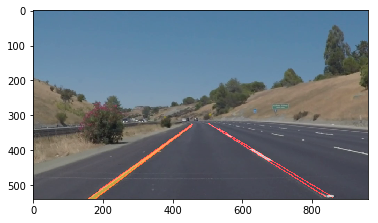

In [17]:
yellow_output = 'mysolidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)

%time yellow_clip.write_videofile(yellow_output, audio=False)

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

[0] is the line now!
[[253 686 630 432]]
[0] We have -ve slope here is -0.67374005305 (right line) avg: -0.67374005305
[0]
[856.45623342175065, 856.45623342175065]
[1] is the line now!
[[281 685 629 432]]
[0] We have -ve slope here is -0.727011494253 (right line) avg: -0.727011494253
[0]
[856.45623342175065, 856.45623342175065, 889.29022988505744, 889.29022988505744]
[2] is the line now!
[[ 663  427 1093  675]]
[1] We have +ve slope here is 0.576744186047 (left line) avg: 0.288372093023
[1]
[235.80930232558137, 235.80930232558137]
[3] is the line now!
[[226 686 409 680]]
[1] We have -ve slope here is -0.0327868852459 (right line) avg: -0.379899189749
[1]
[771.85721688336162, 835.37876860749952, 856.45623342175065, 856.45623342175065, 889.29022988505744, 889.29022988505744]
[4] is the line now!
[[ 573  669 1138  669]]
[5] is the line now!
[[ 964  677 1085  677]]
[6] is the line now!
[[ 913  580 1070  675]]
[2] We have +ve slope here is 0.605095541401 (left line) avg: 0.393946575816
[2]


  0%|          | 0/251 [00:00<?, ?it/s]

[0] is the line now!
[[253 686 630 432]]
[0] We have -ve slope here is -0.67374005305 (right line) avg: -0.67374005305
[0]
[856.45623342175065, 856.45623342175065]
[1] is the line now!
[[281 685 629 432]]
[0] We have -ve slope here is -0.727011494253 (right line) avg: -0.727011494253
[0]
[856.45623342175065, 856.45623342175065, 889.29022988505744, 889.29022988505744]
[2] is the line now!
[[ 663  427 1093  675]]
[1] We have +ve slope here is 0.576744186047 (left line) avg: 0.288372093023
[1]
[235.80930232558137, 235.80930232558137]
[3] is the line now!
[[226 686 409 680]]
[1] We have -ve slope here is -0.0327868852459 (right line) avg: -0.379899189749
[1]
[771.85721688336162, 835.37876860749952, 856.45623342175065, 856.45623342175065, 889.29022988505744, 889.29022988505744]
[4] is the line now!
[[ 573  669 1138  669]]
[5] is the line now!
[[ 964  677 1085  677]]
[6] is the line now!
[[ 913  580 1070  675]]
[2] We have +ve slope here is 0.605095541401 (left line) avg: 0.393946575816
[2]


  0%|          | 1/251 [00:00<00:31,  8.06it/s]

[0] is the line now!
[[633 667 747 667]]
[1] is the line now!
[[255 685 632 431]]
[0] We have -ve slope here is -0.67374005305 (right line) avg: -0.67374005305
[0]
[856.80371352785141, 856.80371352785141]
[2] is the line now!
[[276 685 642 429]]
[0] We have -ve slope here is -0.699453551913 (right line) avg: -0.699453551913
[0]
[856.80371352785141, 856.80371352785141, 878.04918032786884, 878.04918032786884]
[3] is the line now!
[[252 686 613 668]]
[1] We have -ve slope here is -0.0498614958449 (right line) avg: -0.374657523879
[1]
[780.41369601743793, 856.80371352785141, 856.80371352785141, 878.04918032786884, 878.04918032786884, 897.66506213765649]
[4] is the line now!
[[ 653  428 1098  674]]
[1] We have +ve slope here is 0.552808988764 (left line) avg: 0.276404494382
[1]
[247.50786516853933, 247.50786516853933]
[5] is the line now!
[[ 957  606 1075  677]]
[2] We have +ve slope here is 0.601694915254 (left line) avg: 0.384834634673
[2]
[237.71325461816804, 237.71325461816804, 247.5078

  1%|          | 3/251 [00:00<00:28,  8.83it/s]


[3] is the line now!
[[280 685 646 429]]
[1] We have -ve slope here is -0.699453551913 (right line) avg: -0.686162946169
[1]
[855.23670212765956, 855.23670212765956, 872.26126322520645, 877.1232876712329, 877.1232876712329, 877.125624927334]
[4] is the line now!
[[194 677 429 677]]
[5] is the line now!
[[ 872  672 1152  667]]
[1] We have -ve slope here is -0.0178571428571 (right line) avg: -0.352010044513
[1]
[855.23670212765956, 855.23670212765956, 872.26126322520645, 877.1232876712329, 877.1232876712329, 877.125624927334, 978.95275881542011, 1072.5155712790872]
[6] is the line now!
[[277 685 643 429]]
[2] We have -ve slope here is -0.699453551913 (right line) avg: -0.46782454698
[2]
[729.81118370787453, 814.58739951334564, 855.23670212765956, 855.23670212765956, 872.26126322520645, 877.1232876712329, 877.1232876712329, 877.125624927334, 978.95275881542011, 1072.5155712790872]
[7] is the line now!
[[ 949  677 1086  677]]
[8] is the line now!
[[249 685 644 429]]
[2] We have -ve slope 

  2%|▏         | 5/251 [00:00<00:24, 10.11it/s]

[0] is the line now!
[[279 685 643 430]]
[0] We have -ve slope here is -0.700549450549 (right line) avg: -0.700549450549
[0]
[880.4532967032967, 880.4532967032967]
[1] is the line now!
[[646 667 724 667]]
[2] is the line now!
[[253 685 647 430]]
[0] We have -ve slope here is -0.647208121827 (right line) avg: -0.647208121827
[0]
[848.74365482233497, 848.74365482233497, 880.4532967032967, 880.4532967032967]
[3] is the line now!
[[225 686 407 680]]
[1] We have -ve slope here is -0.032967032967 (right line) avg: -0.340087577397
[1]
[762.51970491437498, 818.41564400066932, 848.74365482233497, 848.74365482233497, 880.4532967032967, 880.4532967032967]
[4] is the line now!
[[ 913  676 1091  676]]
[5] is the line now!
[[ 757  668 1042  677]]
[1] We have +ve slope here is 0.0315789473684 (left line) avg: 0.0157894736842
[1]
[656.04736842105262, 656.04736842105262]
[6] is the line now!
[[282 685 645 430]]
[2] We have -ve slope here is -0.702479338843 (right line) avg: -0.460884831212
[2]
[727.270

  3%|▎         | 7/251 [00:00<00:21, 11.16it/s]


[860.61968085106378, 860.61968085106378]
[1] is the line now!
[[281 686 647 430]]
[0] We have -ve slope here is -0.699453551913 (right line) avg: -0.699453551913
[0]
[860.61968085106378, 860.61968085106378, 882.54644808743171, 882.54644808743171]
[2] is the line now!
[[283 669 308 669]]
[3] is the line now!
[[579 669 823 669]]
[4] is the line now!
[[230 687 403 681]]
[1] We have -ve slope here is -0.0346820809249 (right line) avg: -0.367067816419
[1]
[771.42559777630368, 828.92833001674092, 860.61968085106378, 860.61968085106378, 882.54644808743171, 882.54644808743171]
[5] is the line now!
[[ 942  677 1084  677]]
[6] is the line now!
[[273 676 733 668]]
[1] We have -ve slope here is -0.0173913043478 (right line) avg: -0.192229560383
[1]
[728.47866998463246, 771.42559777630368, 808.90426776093614, 828.92833001674092, 860.61968085106378, 860.61968085106378, 882.54644808743171, 882.54644808743171]
[7] is the line now!
[[274 675 660 424]]
[2] We have -ve slope here is -0.650259067358 (rig

  4%|▎         | 9/251 [00:00<00:22, 10.73it/s]

[0] is the line now!
[[292 684 650 424]]
[0] We have -ve slope here is -0.72625698324 (right line) avg: -0.72625698324
[0]
[896.06703910614522, 896.06703910614533]
[1] is the line now!
[[291 668 315 668]]
[2] is the line now!
[[629 667 758 667]]
[3] is the line now!
[[269 685 631 432]]
[0] We have -ve slope here is -0.698895027624 (right line) avg: -0.698895027624
[0]
[873.00276243093924, 873.00276243093924, 896.06703910614522, 896.06703910614533]
[4] is the line now!
[[280 675 446 675]]
[5] is the line now!
[[230 686 411 679]]
[1] We have -ve slope here is -0.0386740331492 (right line) avg: -0.368784530387
[1]
[770.82044198895028, 830.57044198895028, 873.00276243093924, 873.00276243093924, 896.06703910614522, 896.06703910614533]
[6] is the line now!
[[ 987  677 1079  677]]
[7] is the line now!
[[685 427 896 569]]
[1] We have +ve slope here is 0.672985781991 (left line) avg: 0.336492890995
[1]
[196.50236966824647, 196.50236966824647]
[8] is the line now!
[[190 682 619 668]]
[2] We have

  4%|▍         | 11/251 [00:00<00:23, 10.12it/s]

[0] is the line now!
[[274 685 646 425]]
[0] We have -ve slope here is -0.698924731183 (right line) avg: -0.698924731183
[0]
[876.50537634408602, 876.50537634408602]
[1] is the line now!
[[292 685 651 425]]
[0] We have -ve slope here is -0.724233983287 (right line) avg: -0.724233983287
[0]
[876.50537634408602, 876.50537634408602, 896.47632311977713, 896.47632311977713]
[2] is the line now!
[[575 669 832 669]]
[3] is the line now!
[[215 686 418 679]]
[1] We have -ve slope here is -0.0344827586207 (right line) avg: -0.379358370954
[1]
[767.56204975506671, 837.57179905868793, 876.50537634408602, 876.50537634408602, 896.47632311977713, 896.47632311977713]
[4] is the line now!
[[ 663  424 1069  677]]
[1] We have +ve slope here is 0.62315270936 (left line) avg: 0.31157635468
[1]
[217.42487684729065, 217.42487684729065]
[5] is the line now!
[[295 685 654 425]]
[2] We have -ve slope here is -0.724233983287 (right line) avg: -0.494316908398
[2]
[748.28325809240221, 767.56204975506671, 830.82348

  5%|▌         | 13/251 [00:01<00:21, 10.96it/s]

[0] is the line now!
[[342 652 645 424]]
[0] We have -ve slope here is -0.752475247525 (right line) avg: -0.752475247525
[0]
[909.34653465346537, 909.34653465346537]
[1] is the line now!
[[646 667 741 667]]
[2] is the line now!
[[271 685 644 424]]
[0] We have -ve slope here is -0.699731903485 (right line) avg: -0.699731903485
[0]
[874.62734584450402, 874.62734584450402, 909.34653465346537, 909.34653465346537]
[3] is the line now!
[[219 686 416 679]]
[1] We have -ve slope here is -0.0355329949239 (right line) avg: -0.367632449205
[1]
[766.51150637579781, 831.93509886909544, 874.62734584450402, 874.62734584450402, 909.34653465346537, 909.34653465346537]
[4] is the line now!
[[ 921  676 1090  676]]
[5] is the line now!
[[ 677  428 1076  677]]
[1] We have +ve slope here is 0.624060150376 (left line) avg: 0.312030075188
[1]
[216.75563909774436, 216.75563909774436]
[6] is the line now!
[[ 671  429 1096  674]]
[2] We have +ve slope here is 0.576470588235 (left line) avg: 0.40017691287
[2]
[16

  6%|▌         | 15/251 [00:01<00:19, 11.81it/s]

[0] is the line now!
[[272 684 634 431]]
[0] We have -ve slope here is -0.698895027624 (right line) avg: -0.698895027624
[0]
[874.09944751381215, 874.09944751381227]
[1] is the line now!
[[297 684 633 431]]
[0] We have -ve slope here is -0.752976190476 (right line) avg: -0.752976190476
[0]
[874.09944751381215, 874.09944751381227, 907.63392857142856, 907.63392857142856]
[2] is the line now!
[[630 667 759 667]]
[3] is the line now!
[[ 991  677 1083  677]]
[4] is the line now!
[[259 685 601 668]]
[1] We have -ve slope here is -0.0497076023392 (right line) avg: -0.401341896408
[1]
[788.94755116959061, 874.09944751381215, 874.09944751381227, 907.63392857142856, 907.63392857142856, 909.20647974101917]
[5] is the line now!
[[ 879  672 1135  672]]
[6] is the line now!
[[ 674  429 1099  674]]
[1] We have +ve slope here is 0.576470588235 (left line) avg: 0.288235294118
[1]
[234.7294117647059, 234.7294117647059]
[7] is the line now!
[[503 521 656 429]]
[2] We have -ve slope here is -0.60130718954

  7%|▋         | 17/251 [00:01<00:18, 12.75it/s]

[0] is the line now!
[[298 684 635 430]]
[0] We have -ve slope here is -0.753709198813 (right line) avg: -0.753709198813
[0]
[908.60534124629078, 908.60534124629089]
[1] is the line now!
[[575 668 831 668]]
[2] is the line now!
[[281 680 622 433]]
[0] We have -ve slope here is -0.724340175953 (right line) avg: -0.724340175953
[0]
[883.53958944281521, 883.53958944281521, 908.60534124629078, 908.60534124629089]
[3] is the line now!
[[230 685 409 679]]
[1] We have -ve slope here is -0.0335195530726 (right line) avg: -0.378929864513
[1]
[772.153868837956, 833.98231458575663, 883.53958944281521, 883.53958944281521, 908.60534124629078, 908.60534124629089]
[4] is the line now!
[[ 912  675 1091  675]]
[5] is the line now!
[[287 675 787 667]]
[1] We have -ve slope here is -0.016 (right line) avg: -0.197464932256
[1]
[731.67243555759433, 772.153868837956, 822.40490168580743, 833.98231458575663, 883.53958944281521, 883.53958944281521, 908.60534124629078, 908.60534124629089]
[6] is the line now!
[

  8%|▊         | 19/251 [00:01<00:17, 13.37it/s]


[1] We have -ve slope here is -0.0335195530726 (right line) avg: -0.393213264908
[1]
[776.61869072365857, 841.00386514226318, 885.00282485875709, 885.00282485875709, 909.87209302325584, 909.87209302325584]
[4] is the line now!
[[ 783  668 1068  677]]
[1] We have +ve slope here is 0.0315789473684 (left line) avg: 0.0157894736842
[1]
[655.63684210526321, 655.63684210526321]
[5] is the line now!
[[ 961  677 1083  677]]
[6] is the line now!
[[188 682 609 668]]
[2] We have -ve slope here is -0.0332541567696 (right line) avg: -0.273226895529
[2]
[733.36665635941495, 776.61869072365857, 834.39517937704079, 841.00386514226318, 885.00282485875709, 885.00282485875709, 909.87209302325584, 909.87209302325584]
[7] is the line now!
[[341 654 636 424]]
[2] We have -ve slope here is -0.779661016949 (right line) avg: -0.442038269336
[2]
[705.13633929743264, 733.36665635941495, 776.61869072365857, 804.73504984343481, 834.39517937704079, 841.00386514226318, 885.00282485875709, 885.00282485875709, 909.87

  8%|▊         | 21/251 [00:01<00:16, 13.91it/s]


[663.11680048124504, 693.69623350995346, 738.78903739251746, 740.82360636620979, 742.84516255109634, 757.34187201358998, 760.98696361163854, 771.7150011308197, 798.93680936028773, 809.70342296480794, 820.96321062769107, 824.4264305942778, 827.77552421569578, 834.16379923104262, 839.72801560047947, 859.58416091153856, 861.16110064617317, 873.70165745856355, 873.70165745856355, 882.72605085457656, 908.63392857142856, 908.63392857142856, 1024.0882728294334, 1100.5990907383487]
[0] is the line now!
[[270 684 631 432]]
[0] We have -ve slope here is -0.698060941828 (right line) avg: -0.698060941828
[0]
[872.47645429362888, 872.47645429362888]
[1] is the line now!
[[300 683 633 432]]
[0] We have -ve slope here is -0.753753753754 (right line) avg: -0.753753753754
[0]
[872.47645429362888, 872.47645429362888, 909.12612612612611, 909.12612612612611]
[2] is the line now!
[[293 669 567 669]]
[3] is the line now!
[[ 659  666 1100  673]]
[1] We have +ve slope here is 0.015873015873 (left line) avg: 

  9%|▉         | 23/251 [00:01<00:15, 14.30it/s]

[8]
[628.36275389195168, 633.36582955276685, 642.41181733869189, 646.4318977500559, 650.60275508717677, 676.88697505736206, 716.55110204365383, 743.20590654681143, 753.43498224068844, 768.04008462236879, 771.39615617591016, 796.02100309264483, 799.56644862268638, 806.07597071078885, 806.51378834839841, 874.70391061452517, 874.70391061452517, 909.37237237237241, 909.37237237237241, 913.77475684639865, 1067.0566113916002, 1123.9634542668705]
[0] is the line now!
[[270 684 629 433]]
[0] We have -ve slope here is -0.699164345404 (right line) avg: -0.699164345404
[0]
[872.77437325905294, 872.77437325905294]
[1] is the line now!
[[297 684 643 424]]
[0] We have -ve slope here is -0.751445086705 (right line) avg: -0.751445086705
[0]
[872.77437325905294, 872.77437325905294, 907.17919075144505, 907.17919075144505]
[2] is the line now!
[[585 668 810 668]]
[3] is the line now!
[[ 656  425 1090  676]]
[1] We have +ve slope here is 0.578341013825 (left line) avg: 0.289170506912
[1]
[235.304147465437

 10%|▉         | 25/251 [00:01<00:15, 14.30it/s]

[0] is the line now!
[[599 667 786 667]]
[1] is the line now!
[[270 684 640 425]]
[0] We have -ve slope here is -0.7 (right line) avg: -0.7
[0]
[873.0, 873.0]
[2] is the line now!
[[295 684 640 424]]
[0] We have -ve slope here is -0.753623188406 (right line) avg: -0.753623188406
[0]
[873.0, 873.0, 906.31884057971013, 906.31884057971013]
[3] is the line now!
[[ 664  425 1052  667]]
[1] We have +ve slope here is 0.623711340206 (left line) avg: 0.311855670103
[1]
[217.9278350515464, 217.9278350515464]
[4] is the line now!
[[ 944  676 1088  676]]
[5] is the line now!
[[299 683 643 424]]
[1] We have -ve slope here is -0.752906976744 (right line) avg: -0.753265082575
[1]
[873.0, 873.0, 906.31884057971013, 906.31884057971013, 908.22625968992247, 908.34944809571959]
[6] is the line now!
[[220 685 539 669]]
[2] We have -ve slope here is -0.0501567398119 (right line) avg: -0.518895634987
[2]
[799.15703969720562, 873.0, 873.0, 906.31884057971013, 906.31884057971013, 908.22625968992247, 908.349448

 11%|█         | 27/251 [00:02<00:17, 13.10it/s]

[0] is the line now!
[[628 667 766 667]]
[1] is the line now!
[[297 684 641 425]]
[0] We have -ve slope here is -0.752906976744 (right line) avg: -0.752906976744
[0]
[907.61337209302326, 907.61337209302326]
[2] is the line now!
[[271 685 628 426]]
[0] We have -ve slope here is -0.725490196078 (right line) avg: -0.725490196078
[0]
[881.6078431372548, 881.60784313725492, 907.61337209302326, 907.61337209302326]
[3] is the line now!
[[235 686 393 681]]
[1] We have -ve slope here is -0.0316455696203 (right line) avg: -0.378567882849
[1]
[774.9634524695955, 829.77717795979152, 881.6078431372548, 881.60784313725492, 907.61337209302326, 907.61337209302326]
[4] is the line now!
[[259 685 645 424]]
[1] We have -ve slope here is -0.676165803109 (right line) avg: -0.527366842979
[1]
[764.15161372150351, 774.9634524695955, 821.58801233158044, 829.77717795979152, 881.6078431372548, 881.60784313725492, 907.61337209302326, 907.61337209302326]
[5] is the line now!
[[ 930  676 1086  676]]
[6] is the lin

 12%|█▏        | 29/251 [00:02<00:16, 13.08it/s]

[0] is the line now!
[[265 685 635 426]]
[0] We have -ve slope here is -0.7 (right line) avg: -0.7
[0]
[870.5, 870.5]
[1] is the line now!
[[292 684 570 475]]
[0] We have -ve slope here is -0.751798561151 (right line) avg: -0.751798561151
[0]
[870.5, 870.5, 903.52517985611507, 903.52517985611507]
[2] is the line now!
[[638 667 743 667]]
[3] is the line now!
[[ 916  676 1091  676]]
[4] is the line now!
[[161 647 335 653]]
[1] We have +ve slope here is 0.0344827586207 (left line) avg: 0.0172413793103
[1]
[644.22413793103453, 644.22413793103453]
[5] is the line now!
[[231 686 572 669]]
[1] We have -ve slope here is -0.049853372434 (right line) avg: -0.400825966793
[1]
[778.59079832907867, 870.5, 870.5, 898.27245300533764, 903.52517985611507, 903.52517985611507]
[6] is the line now!
[[ 783  668 1068  677]]
[2] We have +ve slope here is 0.0315789473684 (left line) avg: 0.022020568663
[2]
[644.22413793103453, 644.22413793103453, 650.7578947368421, 650.7578947368421]
[7] is the line now!
[[29

 12%|█▏        | 31/251 [00:02<00:16, 13.47it/s]

[0] is the line now!
[[291 685 638 424]]
[0] We have -ve slope here is -0.752161383285 (right line) avg: -0.752161383285
[0]
[903.87896253602298, 903.87896253602298]
[1] is the line now!
[[265 685 639 424]]
[0] We have -ve slope here is -0.697860962567 (right line) avg: -0.697860962567
[0]
[869.93315508021396, 869.93315508021396, 903.87896253602298, 903.87896253602298]
[2] is the line now!
[[608 668 787 668]]
[3] is the line now!
[[ 948  677 1082  677]]
[4] is the line now!
[[244 686 586 669]]
[1] We have -ve slope here is -0.0497076023392 (right line) avg: -0.373784282453
[1]
[777.20336491853516, 869.93315508021396, 869.93315508021396, 888.03758951746568, 903.87896253602298, 903.87896253602298]
[5] is the line now!
[[512 512 660 426]]
[1] We have -ve slope here is -0.581081081081 (right line) avg: -0.477432681767
[1]
[741.1055699662511, 756.44553306472812, 777.20336491853516, 869.93315508021396, 869.93315508021396, 888.03758951746568, 903.87896253602298, 903.87896253602298]
[6] is the

 13%|█▎        | 33/251 [00:02<00:15, 14.07it/s]

[868.51612903225805, 868.51612903225805]
[1] is the line now!
[[284 685 639 427]]
[0] We have -ve slope here is -0.72676056338 (right line) avg: -0.72676056338
[0]
[868.51612903225805, 868.51612903225805, 891.39999999999998, 891.40000000000009]
[2] is the line now!
[[1124  669 1137  669]]
[3] is the line now!
[[629 667 756 667]]
[4] is the line now!
[[229 686 412 679]]
[1] We have -ve slope here is -0.0382513661202 (right line) avg: -0.38250596475
[1]
[773.59386592780731, 836.59245747710304, 868.51612903225805, 868.51612903225805, 891.39999999999998, 891.40000000000009]
[5] is the line now!
[[ 908  675 1057  677]]
[1] We have +ve slope here is 0.0134228187919 (left line) avg: 0.00671140939597
[1]
[668.90604026845642, 668.90604026845642]
[6] is the line now!
[[323 658 654 426]]
[2] We have -ve slope here is -0.700906344411 (right line) avg: -0.488639424637
[2]
[745.57018371268009, 773.59386592780731, 815.83053415779159, 836.59245747710304, 868.51612903225805, 868.51612903225805, 891.399

 14%|█▍        | 35/251 [00:02<00:17, 12.26it/s]

[1]
[122.96623825052751, 122.96623825052751, 220.95261845386534, 220.95261845386534]
[5] is the line now!
[[250 686 401 681]]
[2] We have -ve slope here is -0.0331125827815 (right line) avg: -0.4612093489
[2]
[801.30233722491528, 859.54123711340208, 859.54123711340208, 865.94494890876399, 878.67479674796755, 878.67479674796755]
[6] is the line now!
[[ 946  677 1083  677]]
[7] is the line now!
[[ 611  668 1091  676]]
[2] We have +ve slope here is 0.0166666666667 (left line) avg: 0.308892654404
[2]
[122.96623825052751, 122.96623825052751, 220.95261845386534, 220.95261845386534, 479.26658815923156, 479.26658815923156]
[8] is the line now!
[[360 629 647 428]]
[3] We have -ve slope here is -0.700348432056 (right line) avg: -0.520994119689
[3]
[765.08319543857783, 801.30233722491528, 816.5578830879258, 859.54123711340208, 859.54123711340208, 865.94494890876399, 878.67479674796755, 878.67479674796755]
[9] is the line now!
[[309 667 651 427]]
[3] We have -ve slope here is -0.701754385965 (righ

 15%|█▍        | 37/251 [00:02<00:19, 11.10it/s]

[0] is the line now!
[[634 667 744 667]]
[1] is the line now!
[[260 684 642 427]]
[0] We have -ve slope here is -0.67277486911 (right line) avg: -0.67277486911
[0]
[858.9214659685864, 858.9214659685864]
[2] is the line now!
[[281 685 641 424]]
[0] We have -ve slope here is -0.725 (right line) avg: -0.725
[0]
[858.9214659685864, 858.9214659685864, 888.72499999999991, 888.72500000000002]
[3] is the line now!
[[248 685 664 426]]
[1] We have -ve slope here is -0.622596153846 (right line) avg: -0.673798076923
[1]
[852.10192307692307, 858.9214659685864, 858.9214659685864, 873.40192307692314, 888.72499999999991, 888.72500000000002]
[4] is the line now!
[[ 669  426 1074  669]]
[1] We have +ve slope here is 0.6 (left line) avg: 0.3
[1]
[225.30000000000001, 225.30000000000001]
[5] is the line now!
[[257 685 654 427]]
[2] We have -ve slope here is -0.649874055416 (right line) avg: -0.665823403087
[2]
[852.10192307692307, 856.11661459342508, 858.9214659685864, 858.9214659685864, 862.44850561906605

 16%|█▌        | 39/251 [00:03<00:17, 12.00it/s]

[1] We have +ve slope here is 0.598540145985 (left line) avg: 0.299270072993
[1]
[227.69343065693428, 227.69343065693428]
[5] is the line now!
[[257 684 640 426]]
[2] We have -ve slope here is -0.67362924282 (right line) avg: -0.449144410234
[2]
[713.45242254958794, 761.80294863665188, 799.4301134300689, 837.90361445783128, 837.90361445783128, 860.02343056436268, 888.0, 888.0]
[6] is the line now!
[[278 685 647 427]]
[2] We have -ve slope here is -0.69918699187 (right line) avg: -0.532491937446
[2]
[713.45242254958794, 761.80294863665188, 771.5222835274285, 799.4301134300689, 833.03275860993062, 837.90361445783128, 837.90361445783128, 860.02343056436268, 888.0, 888.0]
[7] is the line now!
[[ 890  673 1140  669]]
[3] We have -ve slope here is -0.016 (right line) avg: -0.403368953084
[3]
[713.45242254958794, 761.80294863665188, 771.5222835274285, 799.4301134300689, 833.03275860993062, 837.90361445783128, 837.90361445783128, 860.02343056436268, 888.0, 888.0, 1031.9983682450672, 1128.84060

 16%|█▋        | 41/251 [00:03<00:16, 12.66it/s]


[2]
[852.5835567470956, 857.47842922902896, 862.68007149240395, 864.19391768206503, 865.53083109919567, 865.53083109919567, 889.15211267605628, 889.15211267605639]
[7] is the line now!
[[227 686 550 670]]
[2] We have -ve slope here is -0.0495356037152 (right line) avg: -0.460477336681
[2]
[790.52835542663502, 852.5835567470956, 857.47842922902896, 862.68007149240395, 864.19391768206503, 865.53083109919567, 865.53083109919567, 889.15211267605628, 889.15211267605639, 923.26253517466648]
[8] is the line now!
[[206 685 401 681]]
[3] We have -ve slope here is -0.0205128205128 (right line) avg: -0.350486207639
[3]
[757.20015877365745, 790.52835542663502, 821.54496926328466, 852.5835567470956, 857.47842922902896, 862.68007149240395, 864.19391768206503, 865.53083109919567, 865.53083109919567, 889.15211267605628, 889.15211267605639, 923.26253517466648]
[9] is the line now!
[[581 471 680 429]]
[3] We have -ve slope here is -0.424242424242 (right line) avg: -0.36892526179
[3]
[679.86917801716027

 17%|█▋        | 43/251 [00:03<00:15, 13.27it/s]

[0] is the line now!
[[279 686 648 428]]
[0] We have -ve slope here is -0.69918699187 (right line) avg: -0.69918699187
[0]
[881.07317073170736, 881.07317073170736]
[1] is the line now!
[[255 686 636 429]]
[0] We have -ve slope here is -0.674540682415 (right line) avg: -0.674540682415
[0]
[858.00787401574803, 858.00787401574803, 881.07317073170736, 881.07317073170736]
[2] is the line now!
[[192 683 646 668]]
[1] We have -ve slope here is -0.0330396475771 (right line) avg: -0.353790164996
[1]
[750.92771167921194, 858.00787401574803, 858.00787401574803, 881.07317073170736, 881.07317073170736, 896.54844658734839]
[3] is the line now!
[[721 668 749 668]]
[4] is the line now!
[[ 947  677 1084  677]]
[5] is the line now!
[[239 686 654 427]]
[1] We have -ve slope here is -0.624096385542 (right line) avg: -0.488943275269
[1]
[746.768902025947, 750.92771167921194, 802.8574427892986, 858.00787401574803, 858.00787401574803, 881.07317073170736, 881.07317073170736, 896.54844658734839]
[6] is the lin

 18%|█▊        | 45/251 [00:03<00:15, 13.50it/s]


[[1067  677 1169  665]]
[6] We have -ve slope here is -0.117647058824 (right line) avg: -0.381076457756
[6]
[686.26450431634737, 686.8086799446246, 703.98091517573653, 715.97983882778362, 721.7870248742056, 740.78633257507431, 757.75052845340394, 768.79423047414457, 804.39927392693232, 806.38556945274649, 816.12444142921004, 817.25947765851322, 819.5281931638001, 847.63157894736844, 847.63157894736844, 871.61879187765339, 881.47154471544718, 881.47154471544718, 1083.6085804254722, 1110.4783791165669]
[15] is the line now!
[[ 666  431 1076  677]]
[6] We have +ve slope here is 0.6 (left line) avg: 0.309954994587
[6]
[224.56997360487537, 224.56997360487537, 245.57914264005879, 245.57914264005879, 298.81018518518522, 298.81018518518522, 548.53549066484516, 548.53549066484516]
[16] is the line now!
[[318 643 665 426]]
[7] We have -ve slope here is -0.625360230548 (right line) avg: -0.411611929355
[7]
[686.26450431634737, 686.8086799446246, 699.72193302093956, 703.98091517573653, 715.979838

 19%|█▊        | 47/251 [00:03<00:16, 12.46it/s]

[0] is the line now!
[[263 685 651 424]]
[0] We have -ve slope here is -0.672680412371 (right line) avg: -0.672680412371
[0]
[861.9149484536083, 861.9149484536083]
[1] is the line now!
[[293 683 632 437]]
[0] We have -ve slope here is -0.725663716814 (right line) avg: -0.725663716814
[0]
[861.9149484536083, 861.9149484536083, 895.6194690265487, 895.6194690265487]
[2] is the line now!
[[614 668 773 668]]
[3] is the line now!


 20%|█▉        | 49/251 [00:03<00:15, 12.81it/s]

[[ 663  427 1092  675]]
[1] We have +ve slope here is 0.578088578089 (left line) avg: 0.289044289044
[1]
[235.36363636363637, 235.36363636363637]
[4] is the line now!
[[ 652  424 1073  677]]
[1] We have +ve slope here is 0.600950118765 (left line) avg: 0.444997203905
[1]
[133.8618230542221, 133.8618230542221, 235.36363636363637, 235.36363636363637]
[5] is the line now!
[[257 686 599 669]]
[2] We have -ve slope here is -0.0497076023392 (right line) avg: -0.500345011989
[2]
[814.58866808121581, 861.9149484536083, 861.9149484536083, 895.6194690265487, 895.6194690265487, 968.70666218151086]
[6] is the line now!
[[ 947  677 1087  677]]
[7] is the line now!
[[ 856  671 1129  671]]
[8] is the line now!
[[374 682 574 669]]
[2] We have -ve slope here is -0.065 (right line) avg: -0.355230007993
[2]
[814.58866808121581, 814.85602298929894, 861.9149484536083, 861.9149484536083, 872.90202458785438, 895.6194690265487, 895.6194690265487, 968.70666218151086]
[9] is the line now!
[[510 525 655 427]]
[3

 21%|██        | 53/251 [00:04<00:14, 13.93it/s]


[2] We have -ve slope here is -0.674479166667 (right line) avg: -0.555222356528
[2]
[749.6404744965696, 774.1078112226254, 795.11242237799252, 830.70462172880048, 840.90703747128191, 873.29999999999995, 873.29999999999995, 879.97152049754459, 884.69044705121689, 887.55314212365533, 897.71468926553666, 897.71468926553666]
[9] is the line now!
[[572 429 683 429]]
[10] is the line now!
[[204 685 384 682]]
[3] We have -ve slope here is -0.0166666666667 (right line) avg: -0.420583434063
[3]
[749.6404744965696, 770.79902054876743, 774.1078112226254, 795.11242237799252, 830.70462172880048, 840.90703747128191, 843.50403868003286, 873.29999999999995, 873.29999999999995, 879.97152049754459, 884.69044705121689, 887.55314212365533, 897.71468926553666, 897.71468926553666]
[11] is the line now!
[[ 905  715 1091  715]]
[12] is the line now!
[[390 600 645 428]]
[3] We have -ve slope here is -0.674509803922 (right line) avg: -0.484065026527
[3]
[740.22194211012879, 749.6404744965696, 770.7990205487674

 22%|██▏       | 55/251 [00:04<00:13, 14.25it/s]


[7]
[589.65273509573512, 602.94378499248319, 604.88091944174812, 619.59163354885163, 629.57147371889562, 635.06091514679451, 642.16721632799749, 650.10914864946153, 665.17987351242778, 685.33580125915501, 741.9534994870146, 743.97502277941123, 764.35393767338428, 766.99771879067396, 780.71170568775813, 790.44391811141111, 803.23262055838768, 821.34043388198472, 861.64643799472287, 861.64643799472299, 879.66849276269693, 888.611764530507, 895.26271186440681, 895.26271186440681, 994.00192228732806, 1076.4393114172119]
[19] is the line now!
[[452 557 641 434]]
[8] We have -ve slope here is -0.650793650794 (right line) avg: -0.323125831661
[8]
[589.65273509573512, 602.94378499248319, 604.88091944174812, 619.59163354885163, 629.57147371889562, 635.06091514679451, 641.12365809463074, 642.16721632799749, 650.10914864946153, 665.17987351242778, 685.33580125915501, 703.05287591072249, 741.9534994870146, 743.97502277941123, 764.35393767338428, 766.99771879067396, 780.71170568775813, 790.4439181

 23%|██▎       | 57/251 [00:04<00:13, 14.34it/s]

[3] is the line now!
[[599 667 788 667]]
[4] is the line now!
[[ 669  425 1086  675]]
[1] We have +ve slope here is 0.599520383693 (left line) avg: 0.299760191847
[1]
[224.46043165467626, 224.46043165467626]
[5] is the line now!
[[564 668 598 668]]
[6] is the line now!
[[ 955  676 1083  676]]
[7] is the line now!
[[221 685 314 683]]
[1] We have -ve slope here is -0.0215053763441 (right line) avg: -0.386899477163
[1]
[770.50478445299404, 804.48643582914076, 873.55191256830608, 873.55191256830608, 907.18348623853217, 907.18348623853217]
[8] is the line now!
[[335 682 534 669]]
[2] We have -ve slope here is -0.0653266331658 (right line) avg: -0.279708529164
[2]
[770.50478445299404, 775.70235726989165, 804.48643582914076, 818.36435457349887, 873.55191256830608, 873.55191256830608, 907.18348623853217, 907.18348623853217]
[9] is the line now!
[[515 458 687 428]]
[2] We have -ve slope here is -0.174418604651 (right line) avg: -0.24461188766
[2]
[583.97512214470669, 596.04836682216205, 770.504

 24%|██▎       | 59/251 [00:04<00:13, 14.39it/s]

[0] is the line now!
[[270 685 636 429]]
[0] We have -ve slope here is -0.699453551913 (right line) avg: -0.699453551913
[0]
[873.85245901639337, 873.85245901639348]
[1] is the line now!
[[296 685 635 429]]
[0] We have -ve slope here is -0.755162241888 (right line) avg: -0.755162241888
[0]
[873.85245901639337, 873.85245901639348, 908.52802359882003, 908.52802359882003]
[2] is the line now!
[[595 668 790 668]]
[3] is the line now!
[[286 675 450 675]]
[4] is the line now!
[[ 663  426 1065  677]]
[1] We have +ve slope here is 0.624378109453 (left line) avg: 0.312189054726
[1]
[219.01865671641792, 219.01865671641792]
[5] is the line now!
[[ 661  427 1091  675]]
[1] We have +ve slope here is 0.576744186047 (left line) avg: 0.444466620386
[1]
[133.2075639245632, 133.2075639245632, 219.01865671641792, 219.01865671641792]
[6] is the line now!
[[ 914  676 1090  676]]
[7] is the line now!
[[272 685 654 427]]
[2] We have -ve slope here is -0.675392670157 (right line) avg: -0.728572384644
[2]
[873

 24%|██▍       | 61/251 [00:04<00:13, 14.23it/s]

[0] is the line now!
[[294 685 635 428]]
[0] We have -ve slope here is -0.75366568915 (right line) avg: -0.75366568915
[0]
[906.5777126099706, 906.5777126099706]
[1] is the line now!
[[268 685 633 429]]
[0] We have -ve slope here is -0.701369863014 (right line) avg: -0.701369863014
[0]
[872.96712328767126, 872.96712328767126, 906.5777126099706, 906.5777126099706]
[2] is the line now!
[[759 668 782 668]]
[3] is the line now!
[[1016  645 1037  644]]
[1] We have -ve slope here is -0.047619047619 (right line) avg: -0.374494455316
[1]
[872.96712328767126, 872.96712328767126, 906.5777126099706, 906.5777126099706, 1025.4863666014351, 1032.3507501630788]
[4] is the line now!
[[233 686 576 669]]
[1] We have -ve slope here is -0.0495626822157 (right line) avg: -0.212028568766
[1]
[735.40265652249161, 791.12845560924961, 872.96712328767126, 872.96712328767126, 906.5777126099706, 906.5777126099706, 1025.4863666014351, 1032.3507501630788]
[5] is the line now!
[[605 668 758 668]]
[6] is the line now

 25%|██▌       | 63/251 [00:04<00:13, 14.20it/s]

[0] is the line now!
[[288 685 643 427]]
[0] We have -ve slope here is -0.72676056338 (right line) avg: -0.72676056338
[0]
[894.3070422535211, 894.3070422535211]
[1] is the line now!
[[265 685 631 429]]
[0] We have -ve slope here is -0.699453551913 (right line) avg: -0.699453551913
[0]
[870.35519125683061, 870.35519125683061, 894.3070422535211, 894.3070422535211]
[2] is the line now!
[[570 669 836 669]]
[3] is the line now!
[[279 676 441 676]]
[4] is the line now!
[[218 686 409 680]]
[1] We have -ve slope here is -0.0314136125654 (right line) avg: -0.365433582239
[1]
[765.66452092810346, 829.46233513575373, 870.35519125683061, 870.35519125683061, 894.3070422535211, 894.3070422535211]
[5] is the line now!
[[ 914  676 1087  676]]
[6] is the line now!
[[285 672 512 672]]
[7] is the line now!
[[ 672  667 1152  675]]
[1] We have +ve slope here is 0.0166666666667 (left line) avg: 0.00833333333333
[1]
[661.39999999999998, 661.39999999999998]
[8] is the line now!
[[475 539 663 430]]
[2] We hav

 26%|██▌       | 65/251 [00:04<00:13, 14.13it/s]

[0] is the line now!
[[260 685 644 426]]
[0] We have -ve slope here is -0.674479166667 (right line) avg: -0.674479166667
[0]
[860.36458333333326, 860.36458333333326]
[1] is the line now!
[[622 667 775 667]]
[2] is the line now!
[[289 684 645 426]]
[0] We have -ve slope here is -0.724719101124 (right line) avg: -0.724719101124
[0]
[860.36458333333326, 860.36458333333326, 893.44382022471905, 893.44382022471905]
[3] is the line now!
[[285 685 642 426]]
[1] We have -ve slope here is -0.725490196078 (right line) avg: -0.725104648601
[1]
[860.36458333333326, 860.36458333333326, 891.51718440185061, 891.65482485128882, 893.44382022471905, 893.44382022471905]
[4] is the line now!
[[1026  677 1070  677]]
[5] is the line now!
[[322 683 519 670]]
[1] We have -ve slope here is -0.0659898477157 (right line) avg: -0.395547248158
[1]
[810.36621390699668, 860.36458333333326, 860.36458333333326, 875.28902179419651, 891.51718440185061, 891.65482485128882, 893.44382022471905, 893.44382022471905]
[6] is th

 27%|██▋       | 67/251 [00:05<00:13, 13.99it/s]

[0] is the line now!
[[283 685 654 426]]
[0] We have -ve slope here is -0.698113207547 (right line) avg: -0.698113207547
[0]
[882.56603773584902, 882.56603773584902]
[1] is the line now!
[[262 685 645 427]]
[0] We have -ve slope here is -0.67362924282 (right line) avg: -0.67362924282
[0]
[861.49086161879893, 861.49086161879904, 882.56603773584902, 882.56603773584902]
[2] is the line now!
[[1124  669 1135  669]]
[3] is the line now!
[[287 669 848 669]]
[4] is the line now!
[[ 925  676 1087  676]]
[5] is the line now!
[[286 685 660 424]]
[1] We have -ve slope here is -0.697860962567 (right line) avg: -0.685745102693
[1]
[861.49086161879893, 861.49086161879904, 876.59176777760717, 881.12309937029636, 882.56603773584902, 882.56603773584902]
[6] is the line now!
[[233 686 404 680]]
[1] We have -ve slope here is -0.0350877192982 (right line) avg: -0.360416410996
[1]
[769.97702376202017, 825.6082300423011, 861.49086161879893, 861.49086161879904, 876.59176777760717, 881.12309937029636, 882.566

 28%|██▊       | 71/251 [00:05<00:13, 13.42it/s]

[0] is the line now!
[[296 684 649 428]]
[0] We have -ve slope here is -0.725212464589 (right line) avg: -0.725212464589
[0]
[898.66288951841364, 898.66288951841364]
[1] is the line now!
[[267 685 648 428]]
[0] We have -ve slope here is -0.674540682415 (right line) avg: -0.674540682415
[0]
[865.10236220472439, 865.10236220472439, 898.66288951841364, 898.66288951841364]
[2] is the line now!
[[601 668 789 668]]
[3] is the line now!
[[284 676 435 676]]
[4] is the line now!
[[ 677  431 1099  674]]
[1] We have +ve slope here is 0.575829383886 (left line) avg: 0.287914691943
[1]
[236.08175355450237, 236.08175355450237]
[5] is the line now!
[[ 957  677 1082  677]]
[6] is the line now!
[[211 685 375 682]]
[1] We have -ve slope here is -0.0182926829268 (right line) avg: -0.346416682671
[1]
[758.09392004353117, 811.90625600153635, 865.10236220472439, 865.10236220472439, 898.66288951841364, 898.66288951841364]
[7] is the line now!
[[ 672  431 1005  631]]
[2] We have +ve slope here is 0.6006006006

 29%|██▉       | 73/251 [00:05<00:12, 13.74it/s]

[0] is the line now!
[[305 684 646 428]]
[0] We have -ve slope here is -0.75073313783 (right line) avg: -0.75073313783
[0]
[912.97360703812319, 912.97360703812319]
[1] is the line now!
[[653 667 717 667]]
[2] is the line now!
[[722 668 750 668]]
[3] is the line now!
[[278 685 643 429]]
[0] We have -ve slope here is -0.701369863014 (right line) avg: -0.701369863014
[0]
[879.98082191780827, 879.98082191780827, 912.97360703812319, 912.97360703812319]
[4] is the line now!
[[ 673  428 1085  675]]
[1] We have +ve slope here is 0.599514563107 (left line) avg: 0.299757281553
[1]
[226.26334951456312, 226.26334951456312]
[5] is the line now!
[[ 915  676 1167  676]]
[6] is the line now!
[[ 680  427 1107  673]]
[1] We have +ve slope here is 0.576112412178 (left line) avg: 0.437934846866
[1]
[129.20430413132948, 129.20430413132948, 226.26334951456312, 226.26334951456312]
[7] is the line now!
[[ 767  668 1052  677]]
[2] We have +ve slope here is 0.0315789473684 (left line) avg: 0.302482880367
[2]
[1

 30%|██▉       | 75/251 [00:05<00:12, 14.15it/s]

[0] is the line now!
[[308 684 650 426]]
[0] We have -ve slope here is -0.754385964912 (right line) avg: -0.754385964912
[0]
[916.35087719298247, 916.35087719298247]
[1] is the line now!
[[283 684 650 427]]
[0] We have -ve slope here is -0.700272479564 (right line) avg: -0.700272479564
[0]
[882.17711171662131, 882.17711171662131, 916.35087719298247, 916.35087719298247]
[2] is the line now!
[[1138  668 1145  668]]
[3] is the line now!
[[ 967  677 1082  677]]
[4] is the line now!
[[592 668 802 668]]
[5] is the line now!
[[303 671 527 671]]
[6] is the line now!
[[501 471 678 427]]
[1] We have -ve slope here is -0.248587570621 (right line) avg: -0.474430025093
[1]
[708.68944257146813, 748.66355701288512, 882.17711171662131, 882.17711171662131, 916.35087719298247, 916.35087719298247]
[7] is the line now!
[[204 684 502 684]]
[8] is the line now!
[[568 432 685 432]]
[9] is the line now!
[[ 874  672 1161  672]]
[10] is the line now!
[[573 452 743 449]]
[1] We have -ve slope here is -0.01764705

 31%|███       | 77/251 [00:05<00:12, 13.70it/s]

[0] is the line now!
[[285 685 639 437]]
[0] We have -ve slope here is -0.700564971751 (right line) avg: -0.700564971751
[0]
[884.66101694915255, 884.66101694915255]
[1] is the line now!
[[299 676 767 668]]
[0] We have -ve slope here is -0.017094017094 (right line) avg: -0.017094017094
[0]
[681.11111111111109, 681.11111111111109, 884.66101694915255, 884.66101694915255]
[2] is the line now!
[[302 685 647 435]]
[1] We have -ve slope here is -0.724637681159 (right line) avg: -0.370865849127
[1]
[674.95020438498705, 681.11111111111109, 681.11111111111109, 797.00148643626903, 884.66101694915255, 884.66101694915255]
[3] is the line now!
[[ 945  677 1083  677]]
[4] is the line now!
[[280 685 649 427]]
[1] We have -ve slope here is -0.69918699187 (right line) avg: -0.535026420498
[1]
[674.95020438498705, 681.11111111111109, 681.11111111111109, 774.23214690340888, 797.00148643626903, 834.80739773952928, 884.66101694915255, 884.66101694915255]
[5] is the line now!
[[301 685 643 668]]
[2] We have

 31%|███▏      | 79/251 [00:06<00:13, 12.36it/s]


[2]
[312.04851330203445, 312.04851330203445]
[8] is the line now!
[[283 685 655 434]]
[2] We have -ve slope here is -0.674731182796 (right line) avg: -0.478884073984
[2]
[747.66906845950962, 774.00188002254731, 820.52419293746743, 887.30977337110482, 887.67133823784468, 891.7722733711048, 893.07500000000005, 893.07500000000005, 919.70426829268285, 919.70426829268297]
[9] is the line now!
[[351 683 400 681]]
[3] We have -ve slope here is -0.0408163265306 (right line) avg: -0.369367137121
[3]
[747.66906845950962, 774.00188002254731, 812.64786512934506, 820.52419293746743, 828.74685484825648, 887.30977337110482, 887.67133823784468, 891.7722733711048, 893.07500000000005, 893.07500000000005, 919.70426829268285, 919.70426829268297]
[10] is the line now!
[[ 675  428 1088  676]]
[3] We have +ve slope here is 0.600484261501 (left line) avg: 0.282750173357
[3]
[237.14363298434677, 237.14363298434677, 312.04851330203445, 312.04851330203445]
[11] is the line now!
[[478 477 674 428]]
[4] We have -

 32%|███▏      | 81/251 [00:06<00:13, 12.77it/s]

[0] is the line now!
[[293 685 636 436]]
[0] We have -ve slope here is -0.725947521866 (right line) avg: -0.725947521866
[0]
[897.70262390670553, 897.70262390670553]
[1] is the line now!
[[313 669 834 669]]
[2] is the line now!
[[318 684 608 457]]
[0] We have -ve slope here is -0.78275862069 (right line) avg: -0.78275862069
[0]
[897.70262390670553, 897.70262390670553, 932.91724137931033, 932.91724137931033]
[3] is the line now!
[[ 907  675 1193  675]]
[4] is the line now!
[[736 668 764 668]]
[5] is the line now!
[[ 665  428 1121  670]]
[1] We have +ve slope here is 0.530701754386 (left line) avg: 0.265350877193
[1]
[251.54166666666669, 251.54166666666669]
[6] is the line now!
[[ 888  673 1175  673]]
[7] is the line now!
[[305 675 453 675]]
[8] is the line now!
[[278 685 650 434]]
[1] We have -ve slope here is -0.674731182796 (right line) avg: -0.728744901743
[1]
[887.59108268446425, 897.70262390670553, 897.70262390670553, 907.68418613274002, 932.91724137931033, 932.91724137931033]
[9] 

 34%|███▍      | 85/251 [00:06<00:14, 11.86it/s]


[22] is the line now!
[[426 522 524 524]]
[9] We have +ve slope here is 0.0204081632653 (left line) avg: 0.265646630096
[9]
[181.36867576867579, 181.36867576867579, 207.31889914658413, 207.31889914658413, 252.68571428571428, 252.68571428571428, 408.8345355791127, 408.8345355791127, 432.6334536533941, 432.6334536533941, 467.73764812682009, 467.73764812682009]
[23] is the line now!
[[485 478 599 476]]
[9] We have -ve slope here is -0.0175438596491 (right line) avg: -0.190053098484
[9]
[570.17575276485684, 574.93312355315652, 577.58256710653086, 589.84180599206036, 590.29637021445637, 597.11936504566688, 604.7918982464048, 613.7985808913005, 635.40288812393396, 639.37671688326145, 651.95273796037486, 669.40634324564894, 680.47815646756362, 688.9429481023501, 698.4786995808995, 759.24291469890113, 776.13443128151846, 777.29034560772948, 788.44915021929819, 815.23934979044975, 838.5122757019808, 845.63475802248786, 896.74269005847952, 896.74269005847952, 923.21194922731854, 924.67722039473

 35%|███▍      | 87/251 [00:06<00:13, 12.12it/s]

[5] We have -ve slope here is -0.0656934306569 (right line) avg: -0.207579123878
[5]
[551.24430937192108, 570.68264934326601, 587.92217104050167, 600.34884298495558, 606.12867088239648, 633.21856733832101, 663.4285259900347, 664.39889034036139, 694.76013597286237, 714.98781506399291, 753.24229048508994, 817.76213593323735, 828.62695670935238, 898.88046647230317, 898.88046647230317, 906.4361888111888, 915.5573426573427, 927.60186279237996, 931.83551663853382, 933.84615384615381, 933.84615384615381, 983.18396780170826]
[17] is the line now!
[[807 669 921 676]]
[6] We have +ve slope here is 0.0614035087719 (left line) avg: 0.016290726817
[6]
[633.82456140350882, 633.82456140350882, 655.85338345864659, 655.85338345864659]
[18] is the line now!
[[327 553 472 566]]
[6] We have +ve slope here is 0.0896551724138 (left line) avg: 0.0267713619023
[6]
[544.2457646579503, 544.2457646579503, 633.82456140350882, 633.82456140350882, 655.85338345864659, 655.85338345864659]
[19] is the line now!
[[341 

 35%|███▌      | 89/251 [00:06<00:14, 11.40it/s]

[9] is the line now!
[[227 611 481 562]]
[3] We have -ve slope here is -0.192913385827 (right line) avg: -0.16239707821
[3]
[573.46114144064802, 613.60646911904098, 640.11299461921249, 647.86413675376548, 709.73849097867685, 717.11946986671546, 733.08201699596862, 762.62747258637648, 783.26899945325317, 879.20268672889529, 913.67987804878044, 913.67987804878044, 949.30508474576277, 949.30508474576277]
[10] is the line now!
[[ 679  428 1091  675]]
[4] We have +ve slope here is 0.599514563107 (left line) avg: 0.139286172533
[4]
[333.42468884992087, 333.42468884992087, 591.16079295154179, 591.16079295154179]
[11] is the line now!
[[356 548 485 548]]
[12] is the line now!
[[136 650 613 427]]
[4] We have -ve slope here is -0.46750524109 (right line) avg: -0.223418710786
[4]
[563.95566971204244, 573.46114144064802, 613.60646911904098, 640.11299461921249, 647.86413675376548, 680.38494466694578, 709.73849097867685, 717.11946986671546, 733.08201699596862, 762.62747258637648, 783.26899945325317,

 37%|███▋      | 93/251 [00:07<00:14, 10.85it/s]

[0] is the line now!
[[187 668 813 668]]
[1] is the line now!
[[307 683 635 436]]
[0] We have -ve slope here is -0.753048780488 (right line) avg: -0.753048780488
[0]
[914.18597560975604, 914.18597560975604]
[2] is the line now!
[[332 683 638 436]]
[0] We have -ve slope here is -0.807189542484 (right line) avg: -0.807189542484
[0]
[914.18597560975604, 914.18597560975604, 950.9869281045751, 950.98692810457521]
[3] is the line now!
[[ 982  677 1079  677]]
[4] is the line now!
[[215 685 352 682]]
[1] We have -ve slope here is -0.021897810219 (right line) avg: -0.414543676351
[1]
[774.12689041553358, 827.91937407566434, 914.18597560975604, 914.18597560975604, 950.9869281045751, 950.98692810457521]
[5] is the line now!
[[ 93 673 473 673]]
[6] is the line now!
[[ 664  428 1093  675]]
[1] We have +ve slope here is 0.575757575758 (left line) avg: 0.287878787879
[1]
[236.84848484848484, 236.84848484848484]
[7] is the line now!
[[669 428 953 585]]
[2] We have +ve slope here is 0.552816901408 (lef

 38%|███▊      | 95/251 [00:07<00:14, 11.06it/s]

[0] is the line now!
[[311 683 628 436]]
[0] We have -ve slope here is -0.779179810726 (right line) avg: -0.779179810726
[0]
[925.32492113564672, 925.32492113564672]
[1] is the line now!
[[629 667 759 667]]
[2] is the line now!
[[ 983  677 1079  677]]
[3] is the line now!
[[ 669  426 1112  671]]
[0] We have +ve slope here is 0.553047404063 (left line) avg: 0.553047404063
[0]
[56.011286681715603, 56.011286681715603]
[4] is the line now!
[[ 667  427 1096  674]]
[1] We have +ve slope here is 0.575757575758 (left line) avg: 0.56440248991
[1]
[50.543539229769522, 50.543539229769522, 56.011286681715603, 56.011286681715603]
[5] is the line now!
[[335 682 629 436]]
[1] We have -ve slope here is -0.836734693878 (right line) avg: -0.807957252302
[1]
[925.32492113564672, 925.32492113564672, 944.20511169767587, 952.6656795210198]
[6] is the line now!
[[467 490 788 473]]
[2] We have -ve slope here is -0.0529595015576 (right line) avg: -0.556291335387
[2]
[749.78805362568778, 911.35757228488649, 925

 39%|███▊      | 97/251 [00:07<00:13, 11.14it/s]


[[341 557 493 547]]
[5] We have -ve slope here is -0.0657894736842 (right line) avg: -0.308169537941
[5]
[606.47709823075706, 609.77189591861838, 662.08581243799028, 688.43417201879697, 690.31626962648909, 694.11560693641616, 694.11560693641616, 698.92758220507108, 701.28985154457428, 742.63037116149053, 761.09259075347279, 817.91950503680494, 827.89255372494222, 856.04461738874875, 976.82352941176464, 976.82352941176475]
[14] is the line now!
[[377 533 783 490]]
[5] We have -ve slope here is -0.105911330049 (right line) avg: -0.274459836626
[5]
[606.47709823075706, 609.77189591861838, 636.47135840799342, 662.08581243799028, 688.43417201879697, 690.31626962648909, 694.11560693641616, 694.11560693641616, 698.92758220507108, 701.28985154457428, 704.90205207814017, 742.63037116149053, 761.09259075347279, 817.91950503680494, 827.89255372494222, 856.04461738874875, 976.82352941176464, 976.82352941176475]
[15] is the line now!
[[249 595 648 601]]
[6] We have +ve slope here is 0.015037593985

 39%|███▉      | 99/251 [00:07<00:13, 11.35it/s]

[0] is the line now!
[[101 675 450 675]]
[1] is the line now!
[[327 669 839 669]]
[2] is the line now!
[[306 687 613 439]]
[0] We have -ve slope here is -0.807817589577 (right line) avg: -0.807817589577
[0]
[934.19218241042347, 934.19218241042347]
[3] is the line now!
[[329 687 616 438]]
[0] We have -ve slope here is -0.867595818815 (right line) avg: -0.867595818815
[0]
[934.19218241042347, 934.19218241042347, 972.43902439024384, 972.43902439024396]
[4] is the line now!
[[ 915  676 1180  676]]
[5] is the line now!
[[474 480 637 430]]
[1] We have -ve slope here is -0.306748466258 (right line) avg: -0.587172142536
[1]
[758.31959556230095, 804.02865479575041, 934.19218241042347, 934.19218241042347, 972.43902439024384, 972.43902439024396]
[6] is the line now!
[[247 594 575 548]]
[1] We have -ve slope here is -0.140243902439 (right line) avg: -0.363708022488
[1]
[683.83588155447728, 757.13211293046322, 758.31959556230095, 804.02865479575041, 934.19218241042347, 934.19218241042347, 972.43902

 41%|████      | 103/251 [00:08<00:12, 11.91it/s]

[[101 668 462 592]]
[4] We have -ve slope here is -0.210526315789 (right line) avg: -0.454679138325
[4]
[680.44299674267097, 680.44299674267097, 696.36278624864372, 713.9225929708125, 757.48051341379119, 770.36780883923348, 802.06176190609267, 827.37533163388434, 831.04316903777499, 852.43329906915653, 890.39544046716219, 918.17948717948718, 918.17948717948718, 956.32889718552178]
[14] is the line now!
[[510 468 649 428]]
[5] We have -ve slope here is -0.287769784173 (right line) avg: -0.426860912633
[5]
[680.44299674267097, 680.44299674267097, 685.69906544274841, 696.36278624864372, 705.0327322987132, 713.9225929708125, 757.48051341379119, 770.36780883923348, 802.06176190609267, 827.37533163388434, 831.04316903777499, 852.43329906915653, 890.39544046716219, 918.17948717948718, 918.17948717948718, 956.32889718552178]
[15] is the line now!
[[440 534 798 502]]
[5] We have -ve slope here is -0.0893854748603 (right line) avg: -0.370615006337
[5]
[680.44299674267097, 680.44299674267097, 685

 42%|████▏     | 105/251 [00:08<00:11, 12.66it/s]


[4] is the line now!
[[ 924  676 1086  676]]
[5] is the line now!
[[ 819  669 1074  678]]
[1] We have +ve slope here is 0.0352941176471 (left line) avg: 0.0176470588235
[1]
[654.54705882352937, 654.54705882352937]
[6] is the line now!
[[465 483 639 430]]
[2] We have -ve slope here is -0.304597701149 (right line) avg: -0.631651897489
[2]
[620.50684931506851, 620.50684931506851, 776.71813233221189, 833.62556249523311, 918.5778037191775, 922.67365036454498, 939.42492012779553, 939.42492012779553]
[7] is the line now!
[[ 902  674 1145  670]]
[2] We have -ve slope here is -0.0164609053498 (right line) avg: -0.426588233442
[2]
[620.50684931506851, 620.50684931506851, 776.71813233221189, 833.62556249523311, 918.5778037191775, 922.67365036454498, 939.42492012779553, 939.42492012779553, 1058.7825865649995, 1158.4435272914907]
[8] is the line now!
[[127 690 321 683]]
[3] We have -ve slope here is -0.0360824742268 (right line) avg: -0.328961793638
[3]
[620.50684931506851, 620.50684931506851, 731

 43%|████▎     | 107/251 [00:08<00:11, 12.67it/s]

[0] is the line now!
[[378 668 829 668]]
[1] is the line now!
[[296 684 920 574]]
[0] We have -ve slope here is -0.176282051282 (right line) avg: -0.176282051282
[0]
[736.17948717948718, 736.17948717948718]
[2] is the line now!
[[ 912  675 1179  675]]
[3] is the line now!
[[311 684 925 576]]
[0] We have -ve slope here is -0.175895765472 (right line) avg: -0.175895765472
[0]
[736.17948717948718, 736.17948717948718, 738.70358306188928, 738.70358306188928]
[4] is the line now!
[[787 596 917 573]]
[1] We have -ve slope here is -0.176923076923 (right line) avg: -0.176409421198
[1]
[734.76743923828622, 734.83421448258582, 736.17948717948718, 736.17948717948718, 738.70358306188928, 738.70358306188928]
[5] is the line now!
[[ 633  430 1092  674]]
[1] We have +ve slope here is 0.531590413943 (left line) avg: 0.265795206972
[1]
[261.75163398692808, 261.75163398692808]
[6] is the line now!
[[ 639  430 1070  650]]
[2] We have +ve slope here is 0.510440835267 (left line) avg: 0.347343749737
[2]
[20

 44%|████▍     | 111/251 [00:08<00:10, 13.38it/s]

[0] is the line now!
[[221 686 414 679]]
[0] We have -ve slope here is -0.0362694300518 (right line) avg: -0.0362694300518
[0]
[694.01554404145077, 694.01554404145077]
[1] is the line now!
[[ 917  673 1189  673]]
[2] is the line now!
[[440 640 519 640]]
[3] is the line now!
[[ 806  644 1128  644]]
[4] is the line now!
[[163 679 458 674]]
[0] We have -ve slope here is -0.0169491525424 (right line) avg: -0.0169491525424
[0]
[681.76271186440681, 681.76271186440681, 694.01554404145077, 694.01554404145077]
[5] is the line now!
[[ 733  667 1090  667]]
[6] is the line now!
[[ 711  661 1126  661]]
[7] is the line now!
[[ 813  650 1130  655]]
[1] We have +ve slope here is 0.0157728706625 (left line) avg: 0.00788643533123
[1]
[643.5883280757098, 643.5883280757098]
[8] is the line now!
[[ 800  637 1089  637]]
[9] is the line now!
[[ 312  684 1082  630]]
[1] We have -ve slope here is -0.0701298701299 (right line) avg: -0.0435395113361
[1]
[677.10975126568349, 681.76271186440681, 681.76271186440681

 46%|████▌     | 115/251 [00:08<00:09, 14.20it/s]

[0] is the line now!
[[642 668 801 668]]
[1] is the line now!
[[ 957  672 1160  672]]
[2] is the line now!
[[598 438 613 427]]
[0] We have -ve slope here is -0.733333333333 (right line) avg: -0.733333333333
[0]
[876.5333333333333, 876.5333333333333]
[3] is the line now!
[[271 684 341 632]]
[0] We have -ve slope here is -0.742857142857 (right line) avg: -0.742857142857
[0]
[876.5333333333333, 876.5333333333333, 885.31428571428569, 885.31428571428569]
[4] is the line now!
[[249 682 332 624]]
[1] We have -ve slope here is -0.698795180723 (right line) avg: -0.72082616179
[1]
[861.48571428571427, 863.31428571428569, 876.5333333333333, 876.5333333333333, 885.31428571428569, 885.31428571428569]
[5] is the line now!
[[111 673 199 682]]
[1] We have +ve slope here is 0.102272727273 (left line) avg: 0.0511363636364
[1]
[667.32386363636363, 667.32386363636363]
[6] is the line now!
[[ 936  656 1191  674]]
[2] We have +ve slope here is 0.0705882352941 (left line) avg: 0.0576203208556
[2]
[602.067379

 47%|████▋     | 117/251 [00:09<00:09, 14.38it/s]

[[550 673 589 673]]
[1] is the line now!
[[769 671 811 670]]
[0] We have -ve slope here is -0.0238095238095 (right line) avg: -0.0238095238095
[0]
[689.30952380952385, 689.30952380952385]
[2] is the line now!
[[ 907  677 1168  673]]
[0] We have -ve slope here is -0.0153256704981 (right line) avg: -0.0153256704981
[0]
[689.30952380952385, 689.30952380952385, 690.9003831417624, 690.9003831417624]
[3] is the line now!
[[797 671 811 671]]
[4] is the line now!
[[197 688 730 670]]
[1] We have -ve slope here is -0.0337711069418 (right line) avg: -0.02454838872
[1]
[687.92032376557188, 689.30952380952385, 689.30952380952385, 690.9003831417624, 690.9003831417624, 692.83603257783238]
[5] is the line now!
[[ 905  677 1054  679]]
[1] We have +ve slope here is 0.0134228187919 (left line) avg: 0.00671140939597
[1]
[670.92617449664431, 670.92617449664431]
[6] is the line now!
[[260 690 851 660]]
[2] We have -ve slope here is -0.0507614213198 (right line) avg: -0.0332860662532
[2]
[687.92032376557188,

 48%|████▊     | 121/251 [00:09<00:08, 14.89it/s]


[0]
[12.526748971193456, 12.526748971193456, 62.717194570135746, 62.717194570135746]
[4] is the line now!
[[ 874  672 1186  672]]
[5] is the line now!
[[272 686 331 643]]
[1] We have -ve slope here is -0.728813559322 (right line) avg: -0.364406779661
[1]
[763.61864406779659, 785.11864406779659]
[6] is the line now!
[[ 90 674 271 686]]
[1] We have +ve slope here is 0.0662983425414 (left line) avg: 0.343848759748
[1]
[12.526748971193456, 12.526748971193456, 62.717194570135746, 62.717194570135746, 643.05361162267241, 643.05361162267241]
[7] is the line now!
[[457 487 626 433]]
[2] We have -ve slope here is -0.319526627219 (right line) avg: -0.349446728847
[2]
[646.69715508307422, 651.75365225821542, 763.61864406779659, 785.11864406779659]
[8] is the line now!
[[571 451 732 448]]
[2] We have -ve slope here is -0.0186335403727 (right line) avg: -0.239175666022
[2]
[587.56930529868578, 623.07658752826262, 646.69715508307422, 651.75365225821542, 763.61864406779659, 785.11864406779659]
[9] is

 50%|████▉     | 125/251 [00:09<00:08, 14.86it/s]

[10] is the line now!
[[576 698 616 696]]
[3] We have -ve slope here is -0.05 (right line) avg: -0.0223119751734
[3]
[681.96653279785812, 682.51271753681397, 686.69879518072287, 687.69879518072287, 709.74417670682726, 710.85169769989045]
[11] is the line now!
[[162 678 365 681]]
[4] We have +ve slope here is 0.0147783251232 (left line) avg: 0.355899536348
[4]
[30.400000000000034, 30.400000000000034, 43.815668202765039, 43.815668202765039, 136.02720535437044, 136.02720535437044, 168.32883368548963, 168.32883368548963, 273.0384071697153, 273.0384071697153, 620.34427511169906, 620.34427511169906]
[12] is the line now!
[[ 883  672 1187  672]]
[13] is the line now!
[[195 682 413 678]]
[4] We have -ve slope here is -0.0183486238532 (right line) avg: -0.0215193049094
[4]
[681.96653279785812, 682.51271753681397, 686.19626445732888, 686.69879518072287, 686.88747292757353, 687.69879518072287, 709.74417670682726, 710.85169769989045]
[14] is the line now!
[[493 469 623 429]]
[5] We have -ve slope 

 51%|█████     | 127/251 [00:09<00:08, 15.09it/s]

[0] is the line now!
[[212 686 417 679]]
[0] We have -ve slope here is -0.0341463414634 (right line) avg: -0.0341463414634
[0]
[693.23902439024391, 693.23902439024391]
[1] is the line now!
[[666 668 802 668]]
[2] is the line now!
[[536 455 751 451]]
[0] We have -ve slope here is -0.0186046511628 (right line) avg: -0.0186046511628
[0]
[464.97209302325581, 464.97209302325581, 693.23902439024391, 693.23902439024391]
[3] is the line now!
[[ 882  673 1189  673]]
[4] is the line now!
[[117 676 443 676]]
[5] is the line now!
[[ 888  674 1144  670]]
[1] We have -ve slope here is -0.015625 (right line) avg: -0.0171148255814
[1]
[464.97209302325581, 464.97209302325581, 689.19796511627908, 689.57936046511622, 693.23902439024391, 693.23902439024391]
[6] is the line now!
[[238 687 436 677]]
[1] We have -ve slope here is -0.0505050505051 (right line) avg: -0.0338099380432
[1]
[464.97209302325581, 464.97209302325581, 689.19796511627908, 689.57936046511622, 691.74113298684517, 693.23902439024391, 693.

 51%|█████▏    | 129/251 [00:09<00:08, 13.84it/s]


[1]
[211.64758604758606, 211.64758604758606, 657.58918918918914, 657.58918918918914]
[4] is the line now!
[[901 675 906 675]]
[5] is the line now!
[[128 677 141 677]]
[6] is the line now!
[[575 460 761 456]]
[2] We have -ve slope here is -0.0215053763441 (right line) avg: -0.0237649888663
[2]
[473.66486859810192, 474.08515652722707, 689.7714285714286, 689.7714285714286, 691.40217054263564, 692.61359911406419]
[7] is the line now!
[[ 907  676 1092  676]]
[8] is the line now!
[[540 449 721 449]]
[9] is the line now!
[[ 664  424 1054  677]]
[2] We have +ve slope here is 0.648717948718 (left line) avg: 0.438168938169
[2]
[133.05582505582504, 133.05582505582504, 211.64758604758606, 211.64758604758606, 657.58918918918914, 657.58918918918914]
[10] is the line now!
[[517 462 742 466]]
[3] We have +ve slope here is 0.0177777777778 (left line) avg: 0.333071148071
[3]
[133.05582505582504, 133.05582505582504, 211.64758604758606, 211.64758604758606, 289.80221644721644, 289.80221644721644, 657.5891

 53%|█████▎    | 133/251 [00:10<00:08, 13.32it/s]

[563.6871839398226, 599.72333934496965, 650.70869028499828, 680.22929936305729, 680.22929936305729, 758.51183511146803, 772.54093466914583, 803.93663722228598, 852.5145118733509, 852.51451187335101]
[5] is the line now!
[[ 674  425 1078  677]]
[2] We have +ve slope here is 0.623762376238 (left line) avg: 0.207920792079
[2]
[284.86138613861385, 284.86138613861385]
[6] is the line now!
[[673 425 915 588]]
[3] We have +ve slope here is 0.673553719008 (left line) avg: 0.324329023811
[3]
[206.72656697487932, 206.72656697487932, 284.86138613861385, 284.86138613861385]
[7] is the line now!
[[125 677 139 677]]
[8] is the line now!
[[ 664  426 1082  677]]
[3] We have +ve slope here is 0.6004784689 (left line) avg: 0.393366385083
[3]
[164.80472030456633, 164.80472030456633, 206.72656697487932, 206.72656697487932, 284.86138613861385, 284.86138613861385]
[9] is the line now!
[[603 669 828 669]]
[10] is the line now!
[[530 453 755 453]]
[11] is the line now!
[[ 913  677 1085  677]]
[12] is the line

 54%|█████▍    | 135/251 [00:10<00:09, 12.52it/s]

[0] is the line now!
[[263 668 808 668]]
[1] is the line now!
[[ 735  466 1061  677]]
[0] We have +ve slope here is 0.647239263804 (left line) avg: 0.647239263804
[0]
[-9.7208588957055326, -9.7208588957055326]
[2] is the line now!
[[237 686 616 431]]
[0] We have -ve slope here is -0.672823218997 (right line) avg: -0.672823218997
[0]
[845.45910290237475, 845.45910290237475]
[3] is the line now!
[[ 947  677 1085  677]]
[4] is the line now!
[[494 474 743 465]]
[1] We have -ve slope here is -0.0361445783133 (right line) avg: -0.354483898655
[1]
[649.11504593572181, 728.38153670089332, 845.45910290237475, 845.45910290237475]
[5] is the line now!
[[ 882  673 1186  673]]
[6] is the line now!
[[ 917  578 1161  719]]
[1] We have +ve slope here is 0.577868852459 (left line) avg: 0.612554058131
[1]
[-9.7208588957055326, -9.7208588957055326, 16.287928693553226, 16.287928693553226]
[7] is the line now!
[[415 678 598 669]]
[2] We have -ve slope here is -0.0491803278689 (right line) avg: -0.252716041

 55%|█████▌    | 139/251 [00:10<00:08, 13.30it/s]

[0] is the line now!
[[152 678 736 668]]
[0] We have -ve slope here is -0.0171232876712 (right line) avg: -0.0171232876712
[0]
[680.60273972602738, 680.60273972602738]
[1] is the line now!
[[455 488 800 476]]
[0] We have -ve slope here is -0.0347826086957 (right line) avg: -0.0347826086957
[0]
[503.82608695652175, 503.82608695652175, 680.60273972602738, 680.60273972602738]
[2] is the line now!
[[771 668 974 678]]
[1] We have +ve slope here is 0.0492610837438 (left line) avg: 0.0246305418719
[1]
[649.00985221674875, 649.00985221674875]
[3] is the line now!
[[560 444 686 424]]
[1] We have -ve slope here is -0.15873015873 (right line) avg: -0.0967563837129
[1]
[490.37487922705316, 498.18357487922708, 503.82608695652175, 503.82608695652175, 680.60273972602738, 680.60273972602738]
[4] is the line now!
[[ 98 673 230 686]]
[2] We have +ve slope here is 0.0984848484848 (left line) avg: 0.0492486440762
[2]
[649.00985221674875, 649.00985221674875, 668.17363288052945, 668.17363288052945]
[5] is t

 56%|█████▌    | 141/251 [00:10<00:08, 13.16it/s]

[0] is the line now!
[[192 684 653 668]]
[0] We have -ve slope here is -0.0347071583514 (right line) avg: -0.0347071583514
[0]
[690.66377440347071, 690.66377440347071]
[1] is the line now!
[[ 919  677 1080  677]]
[2] is the line now!
[[744 668 772 668]]
[3] is the line now!
[[220 687 339 684]]
[0] We have -ve slope here is -0.0252100840336 (right line) avg: -0.0252100840336
[0]
[690.66377440347071, 690.66377440347071, 692.54621848739498, 692.54621848739498]
[4] is the line now!
[[235 687 623 435]]
[1] We have -ve slope here is -0.649484536082 (right line) avg: -0.337347310058
[1]
[645.16737416616138, 690.66377440347071, 690.66377440347071, 692.54621848739498, 692.54621848739498, 766.27661786364035]
[5] is the line now!
[[418 507 730 491]]
[1] We have -ve slope here is -0.0512820512821 (right line) avg: -0.19431468067
[1]
[588.22353652007985, 632.8497168891347, 645.16737416616138, 690.66377440347071, 690.66377440347071, 692.54621848739498, 692.54621848739498, 766.27661786364035]
[6] is 

 57%|█████▋    | 143/251 [00:11<00:08, 13.12it/s]

[0] is the line now!
[[1148  667 1155  667]]
[1] is the line now!
[[607 668 821 668]]
[2] is the line now!
[[228 686 570 669]]
[0] We have -ve slope here is -0.0497076023392 (right line) avg: -0.0497076023392
[0]
[697.33333333333337, 697.33333333333337]
[3] is the line now!
[[396 529 739 529]]
[4] is the line now!
[[ 668  427 1011  649]]
[0] We have +ve slope here is 0.6472303207 (left line) avg: 0.6472303207
[0]
[-5.349854227405217, -5.349854227405217]
[5] is the line now!
[[ 664  427 1030  647]]
[1] We have +ve slope here is 0.601092896175 (left line) avg: 0.624161608437
[1]
[-5.349854227405217, -5.349854227405217, 12.55669199764219, 12.55669199764219]
[6] is the line now!
[[477 519 890 534]]
[1] We have +ve slope here is 0.0363196125908 (left line) avg: 0.330240610514
[1]
[-5.349854227405217, -5.349854227405217, 12.55669199764219, 12.55669199764219, 361.47522878480174, 361.47522878480174]
[7] is the line now!
[[574 443 683 424]]
[2] We have -ve slope here is -0.174311926606 (right l

 58%|█████▊    | 145/251 [00:11<00:08, 12.87it/s]

[0] is the line now!
[[482 672 740 668]]
[0] We have -ve slope here is -0.015503875969 (right line) avg: -0.015503875969
[0]
[679.47286821705427, 679.47286821705427]
[1] is the line now!
[[ 314  581 1006  593]]
[0] We have +ve slope here is 0.0173410404624 (left line) avg: 0.0173410404624
[0]
[575.55491329479764, 575.55491329479764]
[2] is the line now!
[[ 400  571 1126  648]]
[1] We have +ve slope here is 0.106060606061 (left line) avg: 0.0617008232615
[1]
[546.31967069539326, 546.31967069539326, 575.55491329479764, 575.55491329479764]
[3] is the line now!
[[ 372  573 1130  652]]
[1] We have +ve slope here is 0.104221635884 (left line) avg: 0.0829612295727
[1]
[542.13842259895148, 542.13842259895148, 546.31967069539326, 546.31967069539326, 575.55491329479764, 575.55491329479764]
[4] is the line now!
[[194 683 644 434]]
[2] We have -ve slope here is -0.553333333333 (right line) avg: -0.194780361757
[2]
[559.4385529715762, 679.47286821705427, 679.47286821705427, 720.78739018087856]
[5] 

 59%|█████▉    | 149/251 [00:11<00:10, 10.09it/s]

[18] We have +ve slope here is 0.0695187165775 (left line) avg: 0.176318716653
[18]
[291.97948182249206, 291.97948182249206, 307.54388119854912, 307.54388119854912, 499.48895800914806, 499.48895800914806, 506.22610015295385, 506.22610015295385, 510.76891079039734, 510.76891079039734, 512.16120154910607, 512.16120154910607, 524.5996317956035, 524.5996317956035, 529.69899890462329, 529.69899890462329, 531.60239544286617, 531.60239544286617, 536.43086264172553, 536.43086264172553, 538.52842809364552, 538.52842809364552, 541.58064803201535, 541.58064803201535, 561.11381412420178, 561.11381412420178]
[50] is the line now!
[[440 550 628 540]]
[19] We have -ve slope here is -0.0531914893617 (right line) avg: -0.219952285075
[19]
[575.35245234713966, 576.73341284113269, 579.02710762910351, 581.6972248098723, 588.6642253893724, 592.06526867981097, 593.98225146460277, 624.65055200969778, 643.56166085689165, 646.77900543295732, 651.19589355338223, 657.36772983114452, 657.36772983114452, 661.14595

 60%|██████    | 151/251 [00:11<00:09, 10.63it/s]

[1] We have -ve slope here is -0.622828784119 (right line) avg: -0.328285557704
[1]
[644.07247027660651, 688.27607361963192, 688.27607361963192, 762.77339052200523, 808.25623582766445, 808.25623582766445]
[3] is the line now!
[[206 685 643 433]]
[1] We have -ve slope here is -0.576659038902 (right line) avg: -0.452472298303
[1]
[644.07247027660651, 688.27607361963192, 688.27607361963192, 723.93968780861269, 762.77339052200523, 778.2092934503487, 808.25623582766445, 808.25623582766445]
[4] is the line now!
[[ 914  676 1084  676]]
[5] is the line now!
[[235 636 318 636]]
[6] is the line now!
[[248 686 400 681]]
[2] We have -ve slope here is -0.0328947368421 (right line) avg: -0.312613111149
[2]
[644.07247027660651, 688.27607361963192, 688.27607361963192, 723.93968780861269, 762.77339052200523, 763.52805156498778, 778.2092934503487, 806.04524445965762, 808.25623582766445, 808.25623582766445]
[7] is the line now!
[[156 645 501 633]]
[2] We have -ve slope here is -0.0347826086957 (right lin

 61%|██████    | 153/251 [00:12<00:08, 11.17it/s]

[0] is the line now!
[[216 684 632 434]]
[0] We have -ve slope here is -0.600961538462 (right line) avg: -0.600961538462
[0]
[813.80769230769226, 813.80769230769226]
[1] is the line now!
[[236 685 642 432]]
[0] We have -ve slope here is -0.62315270936 (right line) avg: -0.62315270936
[0]
[813.80769230769226, 813.80769230769226, 832.06403940886696, 832.06403940886696]
[2] is the line now!
[[248 667 782 667]]
[3] is the line now!
[[ 910  675 1128  675]]
[4] is the line now!
[[238 685 644 432]]
[1] We have -ve slope here is -0.62315270936 (right line) avg: -0.62315270936
[1]
[813.80769230769226, 813.80769230769226, 832.06403940886696, 832.06403940886696, 833.31034482758616, 833.31034482758616]
[5] is the line now!
[[220 685 323 683]]
[1] We have -ve slope here is -0.0194174757282 (right line) avg: -0.321285092544
[1]
[755.68272035965379, 786.77508489167349, 813.80769230769226, 813.80769230769226, 832.06403940886696, 832.06403940886696, 833.31034482758616, 833.31034482758616]
[6] is the li

 63%|██████▎   | 157/251 [00:12<00:07, 12.04it/s]

[0] is the line now!
[[159 669 269 669]]
[1] is the line now!
[[242 684 626 435]]
[0] We have -ve slope here is -0.6484375 (right line) avg: -0.6484375
[0]
[840.921875, 840.921875]
[2] is the line now!
[[ 517  669 1055  669]]
[3] is the line now!
[[222 684 620 436]]
[0] We have -ve slope here is -0.623115577889 (right line) avg: -0.623115577889
[0]
[822.3316582914573, 822.3316582914573, 840.921875, 840.921875]
[4] is the line now!
[[149 675 437 675]]
[5] is the line now!
[[ 716  667 1058  678]]
[1] We have +ve slope here is 0.0321637426901 (left line) avg: 0.016081871345
[1]
[655.48538011695905, 655.48538011695905]
[6] is the line now!
[[149 674 685 424]]
[1] We have -ve slope here is -0.466417910448 (right line) avg: -0.544766744169
[1]
[755.17024488112202, 797.16521975549392, 822.3316582914573, 822.3316582914573, 840.921875, 840.921875]
[7] is the line now!
[[324 633 953 676]]
[2] We have +ve slope here is 0.0683624801272 (left line) avg: 0.0335087409391
[2]
[622.14316793573755, 622.

 64%|██████▍   | 161/251 [00:12<00:07, 12.24it/s]

[0] is the line now!
[[235 685 628 430]]
[0] We have -ve slope here is -0.648854961832 (right line) avg: -0.648854961832
[0]
[837.48091603053433, 837.48091603053433]
[1] is the line now!
[[216 683 618 432]]
[0] We have -ve slope here is -0.624378109453 (right line) avg: -0.624378109453
[0]
[817.8656716417911, 817.8656716417911, 837.48091603053433, 837.48091603053433]
[2] is the line now!
[[190 681 618 667]]
[1] We have -ve slope here is -0.0327102803738 (right line) avg: -0.328544194913
[1]
[743.423397033524, 817.8656716417911, 817.8656716417911, 837.48091603053433, 837.48091603053433, 870.04031245640954]
[3] is the line now!
[[211 684 614 433]]
[1] We have -ve slope here is -0.622828784119 (right line) avg: -0.475686489516
[1]
[725.07150456294403, 743.423397033524, 784.36984928791719, 817.8656716417911, 817.8656716417911, 837.48091603053433, 837.48091603053433, 870.04031245640954]
[4] is the line now!
[[118 674 672 428]]
[2] We have -ve slope here is -0.4440433213 (right line) avg: -0

 65%|██████▍   | 163/251 [00:12<00:06, 12.58it/s]

[0] is the line now!
[[178 703 608 435]]
[0] We have -ve slope here is -0.623255813953 (right line) avg: -0.623255813953
[0]
[813.93953488372097, 813.93953488372097]
[1] is the line now!
[[208 700 622 432]]
[0] We have -ve slope here is -0.647342995169 (right line) avg: -0.647342995169
[0]
[813.93953488372097, 813.93953488372097, 834.64734299516908, 834.64734299516908]
[2] is the line now!
[[361 578 662 432]]
[1] We have -ve slope here is -0.485049833887 (right line) avg: -0.566196414528
[1]
[782.39690564463058, 806.82202641757749, 813.93953488372097, 813.93953488372097, 834.64734299516908, 834.64734299516908]
[3] is the line now!
[[231 669 255 669]]
[4] is the line now!
[[574 669 828 669]]
[5] is the line now!
[[134 707 561 670]]
[1] We have -ve slope here is -0.0866510538642 (right line) avg: -0.326423734196
[1]
[750.74078038227947, 782.39690564463058, 806.82202641757749, 813.93953488372097, 813.93953488372097, 834.64734299516908, 834.64734299516908, 853.12371488402084]
[6] is the li

 67%|██████▋   | 167/251 [00:13<00:06, 13.52it/s]

[0] is the line now!
[[224 686 649 431]]
[0] We have -ve slope here is -0.6 (right line) avg: -0.6
[0]
[820.39999999999998, 820.39999999999998]
[1] is the line now!
[[260 653 642 432]]
[0] We have -ve slope here is -0.578534031414 (right line) avg: -0.578534031414
[0]
[803.41884816753929, 803.41884816753929, 820.39999999999998, 820.39999999999998]
[2] is the line now!
[[226 687 654 430]]
[1] We have -ve slope here is -0.60046728972 (right line) avg: -0.589500660567
[1]
[803.41884816753929, 803.41884816753929, 815.53343201056896, 820.2271492880559, 820.39999999999998, 820.39999999999998]
[3] is the line now!
[[678 431 961 608]]
[1] We have +ve slope here is 0.625441696113 (left line) avg: 0.312720848057
[1]
[218.97526501766785, 218.97526501766785]
[4] is the line now!
[[539 494 689 424]]
[2] We have -ve slope here is -0.466666666667 (right line) avg: -0.548555995933
[2]
[789.6716818080497, 801.95508119804504, 803.41884816753929, 803.41884816753929, 815.53343201056896, 820.2271492880559,

 67%|██████▋   | 169/251 [00:13<00:05, 13.89it/s]

[0] is the line now!
[[237 686 665 429]]
[0] We have -ve slope here is -0.60046728972 (right line) avg: -0.60046728972
[0]
[828.31074766355141, 828.31074766355141]
[1] is the line now!
[[219 685 289 644]]
[0] We have -ve slope here is -0.585714285714 (right line) avg: -0.585714285714
[0]
[813.2714285714286, 813.2714285714286, 828.31074766355141, 828.31074766355141]
[2] is the line now!
[[538 669 574 669]]
[3] is the line now!
[[205 684 666 429]]
[1] We have -ve slope here is -0.553145336226 (right line) avg: -0.56942981097
[1]
[800.73311124883799, 808.24025410598074, 813.2714285714286, 813.2714285714286, 828.31074766355141, 828.31074766355141]
[4] is the line now!
[[ 674  428 1073  677]]
[1] We have +ve slope here is 0.624060150376 (left line) avg: 0.312030075188
[1]
[217.69172932330827, 217.69172932330827]
[5] is the line now!
[[ 744  667 1057  677]]
[2] We have +ve slope here is 0.0319488817891 (left line) avg: 0.218669677388
[2]
[217.69172932330827, 217.69172932330827, 504.309760023

 69%|██████▉   | 173/251 [00:13<00:05, 14.05it/s]

[0] is the line now!
[[270 685 671 425]]
[0] We have -ve slope here is -0.648379052369 (right line) avg: -0.648379052369
[0]
[860.06234413965092, 860.06234413965092]
[1] is the line now!
[[242 685 677 424]]
[0] We have -ve slope here is -0.6 (right line) avg: -0.6
[0]
[830.20000000000005, 830.20000000000005, 860.06234413965092, 860.06234413965092]
[2] is the line now!
[[602 668 787 668]]
[3] is the line now!
[[ 912  676 1195  676]]
[4] is the line now!
[[237 686 579 669]]
[1] We have -ve slope here is -0.0497076023392 (right line) avg: -0.32485380117
[1]
[762.99035087719301, 830.20000000000005, 830.20000000000005, 857.09035087719303, 860.06234413965092, 860.06234413965092]
[5] is the line now!
[[510 522 685 429]]
[1] We have -ve slope here is -0.531428571429 (right line) avg: -0.428141186299
[1]
[722.27671261487058, 740.35200501253132, 762.99035087719301, 830.20000000000005, 830.20000000000005, 857.09035087719303, 860.06234413965092, 860.06234413965092]
[6] is the line now!
[[475 478 6

 70%|██████▉   | 175/251 [00:13<00:05, 14.22it/s]


[[ 564  669 1141  669]]
[1] is the line now!
[[283 683 645 430]]
[0] We have -ve slope here is -0.698895027624 (right line) avg: -0.698895027624
[0]
[880.7872928176796, 880.7872928176796]
[2] is the line now!
[[219 686 407 680]]
[0] We have -ve slope here is -0.031914893617 (right line) avg: -0.031914893617
[0]
[692.98936170212767, 692.98936170212767, 880.7872928176796, 880.7872928176796]
[3] is the line now!
[[251 686 669 425]]
[1] We have -ve slope here is -0.624401913876 (right line) avg: -0.328158403746
[1]
[644.53797210628113, 692.98936170212767, 692.98936170212767, 768.36775934032369, 880.7872928176796, 880.7872928176796]
[4] is the line now!
[[664 667 949 676]]
[1] We have +ve slope here is 0.0315789473684 (left line) avg: 0.0157894736842
[1]
[656.51578947368421, 656.51578947368421]
[5] is the line now!
[[276 671 531 671]]
[6] is the line now!
[[258 686 634 433]]
[2] We have -ve slope here is -0.672872340426 (right line) avg: -0.443063049306
[2]
[644.53797210628113, 692.9893617

 71%|███████   | 177/251 [00:13<00:05, 14.44it/s]


[[259 685 643 426]]
[0] We have -ve slope here is -0.674479166667 (right line) avg: -0.674479166667
[0]
[859.69010416666663, 859.69010416666663, 880.22520107238608, 880.22520107238608]
[3] is the line now!
[[269 675 446 675]]
[4] is the line now!
[[ 675  426 1061  677]]
[1] We have +ve slope here is 0.650259067358 (left line) avg: 0.325129533679
[1]
[206.53756476683938, 206.53756476683938]
[5] is the line now!
[[253 685 655 424]]
[1] We have -ve slope here is -0.649253731343 (right line) avg: -0.661866449005
[1]
[852.45221159825871, 857.5225240982586, 859.69010416666663, 859.69010416666663, 880.22520107238608, 880.22520107238608]
[6] is the line now!
[[ 963  677 1083  677]]
[7] is the line now!
[[212 685 368 682]]
[2] We have -ve slope here is -0.0192307692308 (right line) avg: -0.447654555747
[2]
[779.90276581834416, 846.73687651486159, 852.45221159825871, 857.5225240982586, 859.69010416666663, 859.69010416666663, 880.22520107238608, 880.22520107238608]
[8] is the line now!
[[276 671

 72%|███████▏  | 181/251 [00:14<00:05, 13.93it/s]

[0] is the line now!
[[261 684 643 427]]
[0] We have -ve slope here is -0.67277486911 (right line) avg: -0.67277486911
[0]
[859.59424083769636, 859.59424083769636]
[1] is the line now!
[[ 961  677 1085  677]]
[2] is the line now!
[[284 684 656 424]]
[0] We have -ve slope here is -0.698924731183 (right line) avg: -0.698924731183
[0]
[859.59424083769636, 859.59424083769636, 882.49462365591398, 882.49462365591398]
[3] is the line now!
[[ 570  669 1082  669]]
[4] is the line now!
[[223 686 407 680]]
[1] We have -ve slope here is -0.0326086956522 (right line) avg: -0.365766713417
[1]
[767.56597709209916, 828.86705236091632, 859.59424083769636, 859.59424083769636, 882.49462365591398, 882.49462365591398]
[5] is the line now!
[[282 685 653 425]]
[1] We have -ve slope here is -0.700808625337 (right line) avg: -0.533287669377
[1]
[767.56597709209916, 773.23684810331554, 828.86705236091632, 835.38712276437218, 859.59424083769636, 859.59424083769636, 882.49462365591398, 882.49462365591398]
[6] is 

 74%|███████▎  | 185/251 [00:14<00:04, 13.62it/s]

[0] is the line now!
[[261 685 647 425]]
[0] We have -ve slope here is -0.673575129534 (right line) avg: -0.673575129534
[0]
[860.80310880829006, 860.80310880829018]
[1] is the line now!
[[284 685 625 446]]
[0] We have -ve slope here is -0.700879765396 (right line) avg: -0.700879765396
[0]
[860.80310880829006, 860.80310880829018, 884.04985337243397, 884.04985337243397]
[2] is the line now!
[[284 669 848 669]]
[3] is the line now!
[[282 685 618 450]]
[1] We have -ve slope here is -0.699404761905 (right line) avg: -0.70014226365
[1]
[860.80310880829006, 860.80310880829018, 882.44011834939261, 882.68791893590287, 884.04985337243397, 884.04985337243397]
[4] is the line now!
[[274 676 435 676]]
[5] is the line now!
[[221 686 405 680]]
[1] We have -ve slope here is -0.0326086956522 (right line) avg: -0.366375479651
[1]
[766.96898100292651, 828.3820692587567, 860.80310880829006, 860.80310880829018, 882.44011834939261, 882.68791893590287, 884.04985337243397, 884.04985337243397]
[6] is the line

 75%|███████▍  | 187/251 [00:14<00:05, 12.38it/s]

[0] is the line now!
[[266 684 652 424]]
[0] We have -ve slope here is -0.673575129534 (right line) avg: -0.673575129534
[0]
[863.17098445595843, 863.17098445595855]
[1] is the line now!
[[297 683 653 424]]
[0] We have -ve slope here is -0.727528089888 (right line) avg: -0.727528089888
[0]
[863.17098445595843, 863.17098445595855, 899.07584269662925, 899.07584269662925]
[2] is the line now!
[[291 668 839 668]]
[3] is the line now!
[[279 676 429 676]]
[4] is the line now!
[[289 684 634 443]]
[1] We have -ve slope here is -0.698550724638 (right line) avg: -0.713039407263
[1]
[863.17098445595843, 863.17098445595855, 890.06838869890896, 895.06698420452699, 899.07584269662925, 899.07584269662925]
[5] is the line now!
[[ 963  676 1080  676]]
[6] is the line now!
[[282 674 735 667]]
[1] We have -ve slope here is -0.0154525386313 (right line) avg: -0.364245972947
[1]
[776.71736437105506, 863.17098445595843, 863.17098445595855, 890.06838869890896, 895.06698420452699, 899.07584269662925, 899.0758

 76%|███████▌  | 191/251 [00:14<00:04, 13.63it/s]

[0] is the line now!
[[307 682 646 427]]
[0] We have -ve slope here is -0.752212389381 (right line) avg: -0.752212389381
[0]
[912.92920353982299, 912.92920353982299]
[1] is the line now!
[[279 684 647 427]]
[0] We have -ve slope here is -0.698369565217 (right line) avg: -0.698369565217
[0]
[878.84510869565224, 878.84510869565224, 912.92920353982299, 912.92920353982299]
[2] is the line now!
[[ 751  667 1064  677]]
[1] We have +ve slope here is 0.0319488817891 (left line) avg: 0.0159744408946
[1]
[655.00319488817888, 655.00319488817888]
[3] is the line now!
[[190 682 647 667]]
[1] We have -ve slope here is -0.0328227571116 (right line) avg: -0.365596161164
[1]
[751.46327062125397, 878.84510869565224, 878.84510869565224, 903.54071627342785, 912.92920353982299, 912.92920353982299]
[4] is the line now!
[[ 652  426 1100  674]]
[2] We have +ve slope here is 0.553571428571 (left line) avg: 0.195173436787
[2]
[298.74691921497032, 298.74691921497032, 655.00319488817888, 655.00319488817888]
[5] i

 77%|███████▋  | 193/251 [00:14<00:04, 14.00it/s]

[0]
[880.22520107238608, 880.22520107238608, 914.60869565217388, 914.60869565217399]
[3] is the line now!
[[604 668 788 668]]
[4] is the line now!
[[ 961  677 1085  677]]
[5] is the line now!
[[223 686 546 670]]
[1] We have -ve slope here is -0.0495356037152 (right line) avg: -0.3746337536
[1]
[769.54332705284742, 874.55002946571608, 880.22520107238608, 880.22520107238608, 914.60869565217388, 914.60869565217399]
[6] is the line now!
[[313 681 655 424]]
[1] We have -ve slope here is -0.751461988304 (right line) avg: -0.563047870952
[1]
[769.54332705284742, 792.79635547366024, 857.23398360802389, 874.55002946571608, 880.22520107238608, 880.22520107238608, 914.60869565217388, 914.60869565217399]
[7] is the line now!
[[ 671  427 1099  674]]
[2] We have +ve slope here is 0.577102803738 (left line) avg: 0.192367601246
[2]
[297.92133956386294, 297.92133956386294]
[8] is the line now!
[[277 685 650 424]]
[2] We have -ve slope here is -0.699731903485 (right line) avg: -0.60860921513
[2]
[769.54

 78%|███████▊  | 197/251 [00:15<00:03, 14.43it/s]

[[605 668 787 668]]
[3] is the line now!
[[ 914  676 1091  676]]
[4] is the line now!
[[305 685 651 424]]
[1] We have -ve slope here is -0.754335260116 (right line) avg: -0.754335260116
[1]
[891.49019607843138, 891.49019607843138, 915.07225433526014, 915.07225433526014, 915.82658959537571, 915.82658959537571]
[5] is the line now!
[[231 686 573 669]]
[1] We have -ve slope here is -0.0497076023392 (right line) avg: -0.402021431227
[1]
[778.86695061352805, 891.49019607843138, 891.49019607843138, 899.3582800932968, 915.07225433526014, 915.07225433526014, 915.82658959537571, 915.82658959537571]
[6] is the line now!
[[518 456 650 424]]
[2] We have -ve slope here is -0.242424242424 (right line) avg: -0.348822368293
[2]
[636.68998677577929, 650.73453939045658, 778.86695061352805, 891.49019607843138, 891.49019607843138, 899.3582800932968, 915.07225433526014, 915.07225433526014, 915.82658959537571, 915.82658959537571]
[7] is the line now!
[[559 488 667 428]]
[2] We have -ve slope here is -0.5555

 79%|███████▉  | 199/251 [00:15<00:03, 13.58it/s]


[[ 735  458 1096  675]]
[2] We have +ve slope here is 0.601108033241 (left line) avg: 0.200369344414
[2]
[310.72853185595568, 310.72853185595568]
[7] is the line now!
[[198 683 683 667]]
[2] We have -ve slope here is -0.0329896907216 (right line) avg: -0.362470381983
[2]
[754.76913563262633, 759.24050428968462, 763.94207640032869, 813.34369839287876, 834.30947882510816, 842.26781326781327, 842.26781326781338, 914.56727089436265, 928.13293051359517, 928.13293051359517]
[8] is the line now!
[[ 871  672 1160  672]]
[9] is the line now!
[[518 456 648 424]]
[3] We have -ve slope here is -0.246153846154 (right line) avg: -0.333391248026
[3]
[628.69666647730355, 640.03752872064229, 754.76913563262633, 759.24050428968462, 763.94207640032869, 813.34369839287876, 834.30947882510816, 842.26781326781327, 842.26781326781338, 914.56727089436265, 928.13293051359517, 928.13293051359517]
[10] is the line now!
[[299 674 726 667]]
[3] We have -ve slope here is -0.016393442623 (right line) avg: -0.254141

 80%|████████  | 201/251 [00:15<00:03, 13.71it/s]

[0] is the line now!
[[310 684 626 446]]
[0] We have -ve slope here is -0.753164556962 (right line) avg: -0.753164556962
[0]
[917.48101265822788, 917.48101265822788]
[1] is the line now!
[[306 669 836 669]]
[2] is the line now!
[[286 684 643 425]]
[0] We have -ve slope here is -0.725490196078 (right line) avg: -0.725490196078
[0]
[891.49019607843138, 891.49019607843138, 917.48101265822788, 917.48101265822788]
[3] is the line now!
[[222 686 405 680]]
[1] We have -ve slope here is -0.0327868852459 (right line) avg: -0.379138540662
[1]
[770.168756027001, 833.55110896817746, 891.49019607843138, 891.49019607843138, 917.48101265822788, 917.48101265822788]
[4] is the line now!
[[ 677  428 1104  674]]
[1] We have +ve slope here is 0.576112412178 (left line) avg: 0.288056206089
[1]
[232.98594847775178, 232.98594847775178]
[5] is the line now!
[[ 672  430 1084  677]]
[2] We have +ve slope here is 0.599514563107 (left line) avg: 0.391875658428
[2]
[166.65955753620881, 166.65955753620881, 232.9859

 81%|████████  | 203/251 [00:15<00:03, 12.28it/s]

[4] is the line now!
[[300 675 450 675]]
[5] is the line now!
[[218 686 415 679]]
[1] We have -ve slope here is -0.0355329949239 (right line) avg: -0.407542855289
[1]
[774.84434245309035, 848.13028494510309, 892.80056179775283, 892.80056179775283, 928.37060702875397, 928.37060702875397]
[6] is the line now!
[[ 666  428 1108  673]]
[1] We have +ve slope here is 0.554298642534 (left line) avg: 0.277149321267
[1]
[243.41855203619909, 243.41855203619909]
[7] is the line now!
[[ 662  429 1091  676]]
[2] We have +ve slope here is 0.575757575758 (left line) avg: 0.376685406097
[2]
[179.63426116367287, 179.63426116367287, 243.41855203619909, 243.41855203619909]
[8] is the line now!
[[ 975  677 1079  677]]
[9] is the line now!
[[315 684 632 427]]
[2] We have -ve slope here is -0.81072555205 (right line) avg: -0.541937087543
[2]
[769.50423932723561, 774.84434245309035, 848.13028494510309, 854.71018257607466, 892.80056179775283, 892.80056179775283, 928.37060702875397, 928.37060702875397]
[10] is 

 82%|████████▏ | 205/251 [00:15<00:04, 11.28it/s]

[0] is the line now!
[[317 684 649 425]]
[0] We have -ve slope here is -0.780120481928 (right line) avg: -0.780120481928
[0]
[931.29819277108436, 931.29819277108436]
[1] is the line now!
[[304 675 730 668]]
[0] We have -ve slope here is -0.0164319248826 (right line) avg: -0.0164319248826
[0]
[679.99530516431923, 679.99530516431923, 931.29819277108436, 931.29819277108436]
[2] is the line now!
[[291 685 648 425]]
[1] We have -ve slope here is -0.728291316527 (right line) avg: -0.372361620705
[1]
[666.2903302165937, 679.99530516431923, 679.99530516431923, 793.35723162504439, 931.29819277108436, 931.29819277108436]
[3] is the line now!
[[310 684 655 424]]
[1] We have -ve slope here is -0.753623188406 (right line) avg: -0.562992404555
[1]
[666.2903302165937, 679.99530516431923, 679.99530516431923, 792.76002498366154, 793.35723162504439, 858.52764541211468, 931.29819277108436, 931.29819277108436]
[4] is the line now!
[[731 668 748 668]]
[5] is the line now!
[[808 669 979 677]]
[2] We have +v

 83%|████████▎ | 209/251 [00:16<00:04, 10.34it/s]

[0] is the line now!
[[317 684 647 426]]
[0] We have -ve slope here is -0.781818181818 (right line) avg: -0.781818181818
[0]
[931.83636363636367, 931.83636363636367]
[1] is the line now!
[[287 685 643 427]]
[0] We have -ve slope here is -0.724719101124 (right line) avg: -0.724719101124
[0]
[892.99438202247188, 892.99438202247188, 931.83636363636367, 931.83636363636367]
[2] is the line now!
[[313 669 820 669]]
[3] is the line now!
[[717 668 745 668]]
[4] is the line now!
[[334 653 661 424]]
[1] We have -ve slope here is -0.700305810398 (right line) avg: -0.712512455761
[1]
[890.97916022403183, 892.99438202247188, 892.99438202247188, 894.97073325773977, 931.83636363636367, 931.83636363636367]
[5] is the line now!
[[311 671 547 671]]
[6] is the line now!
[[317 666 573 670]]
[1] We have +ve slope here is 0.015625 (left line) avg: 0.0078125
[1]
[663.5234375, 663.5234375]
[7] is the line now!
[[ 942  677 1086  677]]
[8] is the line now!
[[241 686 401 681]]
[2] We have -ve slope here is -0.03

 84%|████████▍ | 211/251 [00:16<00:03, 11.35it/s]

[0] is the line now!
[[317 685 649 426]]
[0] We have -ve slope here is -0.780120481928 (right line) avg: -0.780120481928
[0]
[932.29819277108436, 932.29819277108436]
[1] is the line now!
[[291 685 648 426]]
[0] We have -ve slope here is -0.725490196078 (right line) avg: -0.725490196078
[0]
[896.11764705882354, 896.11764705882354, 932.29819277108436, 932.29819277108436]
[2] is the line now!
[[190 683 634 668]]
[1] We have -ve slope here is -0.0337837837838 (right line) avg: -0.379636989931
[1]
[755.13102808691042, 896.11764705882354, 896.11764705882354, 908.68985161632213, 932.29819277108436, 932.29819277108436]
[3] is the line now!
[[ 669  668 1106  675]]
[1] We have +ve slope here is 0.0160183066362 (left line) avg: 0.00800915331808
[1]
[662.64187643020591, 662.64187643020591]
[4] is the line now!
[[ 678  428 1078  678]]
[2] We have +ve slope here is 0.625 (left line) avg: 0.213672768879
[2]
[283.12986270022884, 283.12986270022884, 662.64187643020591, 662.64187643020591]
[5] is the li

 86%|████████▌ | 215/251 [00:16<00:02, 12.46it/s]

[0] is the line now!
[[320 684 631 441]]
[0] We have -ve slope here is -0.781350482315 (right line) avg: -0.781350482315
[0]
[934.03215434083597, 934.03215434083597]
[1] is the line now!
[[302 682 644 425]]
[0] We have -ve slope here is -0.751461988304 (right line) avg: -0.751461988304
[0]
[908.9415204678362, 908.94152046783631, 934.03215434083597, 934.03215434083597]
[2] is the line now!
[[ 916  676 1088  676]]
[3] is the line now!
[[317 669 838 669]]
[4] is the line now!
[[237 686 401 681]]
[1] We have -ve slope here is -0.030487804878 (right line) avg: -0.390974896591
[1]
[778.66105049208386, 837.78093353301961, 908.9415204678362, 908.94152046783631, 934.03215434083597, 934.03215434083597]
[5] is the line now!
[[ 947  591 1092  675]]
[1] We have +ve slope here is 0.579310344828 (left line) avg: 0.289655172414
[1]
[316.69655172413792, 316.69655172413792]
[6] is the line now!
[[ 670  428 1110  672]]
[2] We have +ve slope here is 0.554545454545 (left line) avg: 0.377951933124
[2]
[174.

 87%|████████▋ | 219/251 [00:17<00:02, 13.34it/s]


[4] is the line now!
[[351 682 636 426]]
[1] We have -ve slope here is -0.898245614035 (right line) avg: -0.853232396059
[1]
[910.18497109826581, 910.18497109826592, 948.71232876712327, 948.71232876712327, 968.65580389329489, 981.48457101658255]
[5] is the line now!
[[ 879  672 1162  672]]
[6] is the line now!
[[313 684 519 670]]
[1] We have -ve slope here is -0.0679611650485 (right line) avg: -0.460596780554
[1]
[828.16679231327419, 909.04972910731408, 910.18497109826581, 910.18497109826592, 948.71232876712327, 948.71232876712327, 968.65580389329489, 981.48457101658255]
[7] is the line now!
[[327 683 614 451]]
[2] We have -ve slope here is -0.808362369338 (right line) avg: -0.576518643482
[2]
[804.98244709777669, 828.16679231327419, 871.52159641852268, 909.04972910731408, 910.18497109826581, 910.18497109826592, 948.71232876712327, 948.71232876712327, 968.65580389329489, 981.48457101658255]
[8] is the line now!
[[341 655 383 656]]
[2] We have +ve slope here is 0.0238095238095 (left li

 88%|████████▊ | 221/251 [00:17<00:02, 13.95it/s]

[0] We have -ve slope here is -0.839869281046 (right line) avg: -0.839869281046
[0]
[962.67647058823525, 962.67647058823536]
[1] is the line now!
[[327 668 828 668]]
[2] is the line now!
[[308 683 636 427]]
[0] We have -ve slope here is -0.780487804878 (right line) avg: -0.780487804878
[0]
[923.39024390243901, 923.39024390243912, 962.67647058823525, 962.67647058823536]
[3] is the line now!
[[214 685 367 682]]
[1] We have -ve slope here is -0.0196078431373 (right line) avg: -0.400047824008
[1]
[770.61023433763751, 828.81755141080828, 923.39024390243901, 923.39024390243912, 962.67647058823525, 962.67647058823536]
[4] is the line now!
[[343 675 443 675]]
[5] is the line now!
[[319 674 756 667]]
[1] We have -ve slope here is -0.0160183066362 (right line) avg: -0.208033065322
[1]
[740.36254783768732, 770.61023433763751, 824.27299738335921, 828.81755141080828, 923.39024390243901, 923.39024390243912, 962.67647058823525, 962.67647058823536]
[6] is the line now!
[[1024  677 1076  677]]
[7] is t

 90%|████████▉ | 225/251 [00:17<00:01, 13.89it/s]


[689.04328029793157, 709.28070803607488, 735.75217457691849, 750.58998047809621, 777.61819295497912, 820.38699690402473, 825.84845201238386, 829.3651094648385, 830.0175474491856, 831.49448252985405, 851.64419946817247, 858.8438080495356, 923.60975609756099, 923.60975609756099, 960.91503267973849, 960.9150326797386, 976.15522202778902, 999.79876160990716]
[16] is the line now!
[[ 725  455 1080  677]]
[7] We have +ve slope here is 0.625352112676 (left line) avg: 0.368045771419
[7]
[188.16681572097417, 188.16681572097417, 234.41650105871648, 234.41650105871648, 236.88235294117649, 236.88235294117649, 253.91237727207672, 253.91237727207672, 277.71227733161265, 277.71227733161265, 474.63039971313856, 474.63039971313856, 538.05918849291538, 538.05918849291538]
[17] is the line now!
[[206 685 383 682]]
[8] We have -ve slope here is -0.0169491525424 (right line) avg: -0.452017101773
[8]
[689.04328029793157, 709.28070803607488, 735.75217457691849, 750.58998047809621, 777.61819295497912, 778.11

 90%|█████████ | 227/251 [00:17<00:01, 14.25it/s]

[0] is the line now!
[[400 612 635 429]]
[0] We have -ve slope here is -0.778723404255 (right line) avg: -0.778723404255
[0]
[923.48936170212767, 923.48936170212767]
[1] is the line now!
[[605 668 783 668]]
[2] is the line now!
[[333 683 636 429]]
[0] We have -ve slope here is -0.838283828383 (right line) avg: -0.838283828383
[0]
[923.48936170212767, 923.48936170212767, 962.14851485148517, 962.14851485148517]
[3] is the line now!
[[254 686 596 669]]
[1] We have -ve slope here is -0.0497076023392 (right line) avg: -0.443995715361
[1]
[798.77491170169651, 923.48936170212767, 923.48936170212767, 933.62144635516188, 962.14851485148517, 962.14851485148517]
[4] is the line now!
[[307 683 633 429]]
[1] We have -ve slope here is -0.779141104294 (right line) avg: -0.611568409828
[1]
[798.77491170169651, 816.1228034209621, 870.75150181711751, 923.48936170212767, 923.48936170212767, 933.62144635516188, 962.14851485148517, 962.14851485148517]
[5] is the line now!
[[ 913  676 1094  676]]
[6] is the

 92%|█████████▏| 231/251 [00:17<00:01, 12.35it/s]

[0] is the line now!
[[325 684 631 428]]
[0] We have -ve slope here is -0.83660130719 (right line) avg: -0.83660130719
[0]
[955.89542483660125, 955.89542483660136]
[1] is the line now!
[[316 684 649 424]]
[0] We have -ve slope here is -0.780780780781 (right line) avg: -0.780780780781
[0]
[930.72672672672661, 930.72672672672672, 955.89542483660125, 955.89542483660136]
[2] is the line now!
[[634 667 751 667]]
[3] is the line now!
[[298 684 641 426]]
[1] We have -ve slope here is -0.752186588921 (right line) avg: -0.766483684851
[1]
[912.41213808560747, 917.31604198951129, 930.72672672672661, 930.72672672672672, 955.89542483660125, 955.89542483660136]
[4] is the line now!
[[ 927  676 1087  676]]
[5] is the line now!
[[239 686 396 681]]
[1] We have -ve slope here is -0.031847133758 (right line) avg: -0.399165409304
[1]
[781.40053282377471, 839.06950208458068, 912.41213808560747, 917.31604198951129, 930.72672672672661, 930.72672672672672, 955.89542483660125, 955.89542483660136]
[6] is the l

 93%|█████████▎| 233/251 [00:18<00:01, 12.24it/s]


[[669 425 881 557]]
[2] We have +ve slope here is 0.622641509434 (left line) avg: 0.207547169811
[2]
[286.15094339622647, 286.15094339622647]
[9] is the line now!
[[436 577 634 438]]
[2] We have -ve slope here is -0.70202020202 (right line) avg: -0.376501551865
[2]
[676.70198388223753, 723.61102308952832, 741.15467661302137, 776.99723092324086, 804.15379846331325, 841.51023670358768, 907.52890173410401, 907.52890173410401, 943.19254658385091, 943.19254658385091]
[10] is the line now!
[[662 427 892 554]]
[3] We have +ve slope here is 0.552173913043 (left line) avg: 0.293703855619
[3]
[232.56804757998358, 232.56804757998358, 286.15094339622647, 286.15094339622647]
[11] is the line now!
[[536 447 639 425]]
[3] We have -ve slope here is -0.21359223301 (right line) avg: -0.335774222151
[3]
[626.97498307292165, 639.5597279544719, 676.70198388223753, 723.61102308952832, 741.15467661302137, 776.99723092324086, 804.15379846331325, 841.51023670358768, 907.52890173410401, 907.52890173410401, 943

 94%|█████████▎| 235/251 [00:18<00:01, 12.96it/s]

[0] is the line now!
[[313 669 850 669]]
[1] is the line now!
[[316 684 630 439]]
[0] We have -ve slope here is -0.78025477707 (right line) avg: -0.78025477707
[0]
[930.56050955414014, 930.56050955414014]
[2] is the line now!
[[294 684 639 424]]
[0] We have -ve slope here is -0.753623188406 (right line) avg: -0.753623188406
[0]
[905.56521739130437, 905.56521739130437, 930.56050955414014, 930.56050955414014]
[3] is the line now!
[[ 661  427 1106  673]]
[1] We have +ve slope here is 0.552808988764 (left line) avg: 0.276404494382
[1]
[244.29662921348316, 244.29662921348316]
[4] is the line now!
[[ 665  425 1149  716]]
[1] We have +ve slope here is 0.601239669421 (left line) avg: 0.438822081902
[1]
[133.18331553533284, 133.18331553533284, 244.29662921348316, 244.29662921348316]
[5] is the line now!
[[313 684 619 445]]
[2] We have -ve slope here is -0.781045751634 (right line) avg: -0.762764042815
[2]
[905.56521739130437, 905.56521739130437, 917.15094250260495, 922.7451454011557, 930.560509

 95%|█████████▌| 239/251 [00:18<00:00, 13.11it/s]

[0] is the line now!
[[ 315  668 1142  668]]
[1] is the line now!
[[327 680 629 427]]
[0] We have -ve slope here is -0.837748344371 (right line) avg: -0.837748344371
[0]
[953.94370860927143, 953.94370860927154]
[2] is the line now!
[[295 683 638 425]]
[0] We have -ve slope here is -0.752186588921 (right line) avg: -0.752186588921
[0]
[904.8950437317784, 904.8950437317784, 953.94370860927143, 953.94370860927154]
[3] is the line now!
[[320 683 640 424]]
[1] We have -ve slope here is -0.809375 (right line) avg: -0.780780794461
[1]
[904.8950437317784, 904.8950437317784, 923.69970845481043, 932.84985422740522, 953.94370860927143, 953.94370860927154]
[4] is the line now!
[[ 959  676 1087  676]]
[5] is the line now!
[[307 675 769 667]]
[1] We have -ve slope here is -0.017316017316 (right line) avg: -0.399048405888
[1]
[797.50786060771713, 904.8950437317784, 904.8950437317784, 923.69970845481043, 932.84985422740522, 953.94370860927143, 953.94370860927154, 973.86822412812523]
[6] is the line no

 97%|█████████▋| 243/251 [00:18<00:00, 13.75it/s]

[0] is the line now!
[[294 684 634 428]]
[0] We have -ve slope here is -0.752941176471 (right line) avg: -0.752941176471
[0]
[905.36470588235295, 905.36470588235295]
[1] is the line now!
[[610 667 781 667]]
[2] is the line now!
[[324 683 642 426]]
[0] We have -ve slope here is -0.808176100629 (right line) avg: -0.808176100629
[0]
[905.36470588235295, 905.36470588235295, 944.84905660377353, 944.84905660377365]
[3] is the line now!
[[323 683 641 426]]
[1] We have -ve slope here is -0.808176100629 (right line) avg: -0.808176100629
[1]
[905.36470588235295, 905.36470588235295, 944.04088050314465, 944.04088050314465, 944.84905660377353, 944.84905660377365]
[4] is the line now!
[[ 896  673 1086  676]]
[1] We have +ve slope here is 0.0157894736842 (left line) avg: 0.00789473684211
[1]
[665.92631578947373, 665.92631578947373]
[5] is the line now!
[[251 685 593 668]]
[2] We have -ve slope here is -0.0497076023392 (right line) avg: -0.555353267866
[2]
[824.39367023428599, 905.36470588235295, 905.

 98%|█████████▊| 245/251 [00:19<00:00, 14.16it/s]

[0] is the line now!
[[292 684 632 428]]
[0] We have -ve slope here is -0.752941176471 (right line) avg: -0.752941176471
[0]
[903.85882352941178, 903.85882352941178]
[1] is the line now!
[[320 683 635 428]]
[0] We have -ve slope here is -0.809523809524 (right line) avg: -0.809523809524
[0]
[903.85882352941178, 903.85882352941178, 942.04761904761904, 942.04761904761904]
[2] is the line now!
[[591 668 808 668]]
[3] is the line now!
[[ 907  675 1193  675]]
[4] is the line now!
[[ 918  676 1091  676]]
[5] is the line now!
[[ 658  424 1149  719]]
[1] We have +ve slope here is 0.600814663951 (left line) avg: 0.300407331976
[1]
[226.33197556008147, 226.33197556008147]
[6] is the line now!
[[202 684 392 681]]
[1] We have -ve slope here is -0.0157894736842 (right line) avg: -0.412656641604
[1]
[767.35664160401006, 842.76140350877199, 903.85882352941178, 903.85882352941178, 942.04761904761904, 942.04761904761904]
[7] is the line now!
[[494 531 648 435]]
[2] We have -ve slope here is -0.623376623

 99%|█████████▉| 249/251 [00:19<00:00, 14.45it/s]


[0] We have -ve slope here is -0.751479289941 (right line) avg: -0.751479289941
[0]
[904.18343195266266, 904.18343195266266]
[1] is the line now!
[[616 668 773 668]]
[2] is the line now!
[[315 684 644 427]]
[0] We have -ve slope here is -0.781155015198 (right line) avg: -0.781155015198
[0]
[904.18343195266266, 904.18343195266266, 930.063829787234, 930.063829787234]
[3] is the line now!
[[ 910  676 1195  676]]
[4] is the line now!
[[ 654  426 1102  674]]
[1] We have +ve slope here is 0.553571428571 (left line) avg: 0.276785714286
[1]
[244.98214285714283, 244.98214285714283]
[5] is the line now!
[[250 686 592 669]]
[1] We have -ve slope here is -0.0497076023392 (right line) avg: -0.415431308768
[1]
[789.85782719209374, 904.18343195266266, 904.18343195266266, 914.93533479087785, 930.063829787234, 930.063829787234]
[6] is the line now!
[[ 911  578 1082  677]]
[2] We have +ve slope here is 0.578947368421 (left line) avg: 0.377506265664
[2]
[234.0917919799499, 234.0917919799499, 244.9821428

100%|██████████| 251/251 [00:19<00:00, 14.97it/s]



[3] is the line now!
[[299 676 439 676]]
[4] is the line now!
[[ 912  676 1195  676]]
[5] is the line now!
[[ 883  673 1160  673]]
[6] is the line now!
[[231 686 573 669]]
[1] We have -ve slope here is -0.0497076023392 (right line) avg: -0.388490164806
[1]
[775.74122807017545, 891.60486443381183, 892.72727272727275, 892.72727272727275, 929.03975535168195, 929.03975535168195]
[7] is the line now!
[[ 682  428 1081  677]]
[1] We have +ve slope here is 0.624060150376 (left line) avg: 0.312030075188
[1]
[215.19548872180451, 215.19548872180451]
[8] is the line now!
[[297 685 654 426]]
[2] We have -ve slope here is -0.725490196078 (right line) avg: -0.500823508563
[2]
[753.53857460049403, 775.74122807017545, 833.7445820433436, 891.60486443381183, 892.72727272727275, 892.72727272727275, 929.03975535168195, 929.03975535168195]
[9] is the line now!
[[ 945  677 1171  674]]
[2] We have -ve slope here is -0.0132743362832 (right line) avg: -0.338307117803
[2]
[753.53857460049403, 775.74122807017545

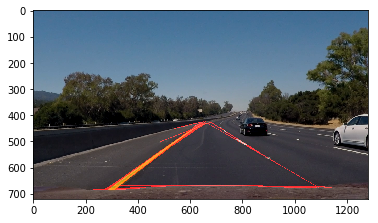

In [19]:
challenge_output = 'mychallenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))